''' This notebook will consist of Stats Testing: split half reliability & paired t-test to identify highest aligned layer by model for ROI'''
                                            Final Output will be 3 graphs (one for each ROI) 

# Helper Functions

In [2]:
import os
import torch
import pickle
import numpy as np
import pandas as pd
from itertools import combinations
from copy import deepcopy
from scipy.stats import pearsonr, ttest_rel
from fastprogress.fastprogress import progress_bar
from scipy.spatial.distance import squareform
from io import StringIO


def get_split_halves(N):
    subjects = list(range(0,N))
    splits = []
    for subsetA in combinations(subjects, N//2):
        subsetA = list(subsetA)
        subsetB = list(np.setdiff1d(subjects, subsetA))
        assert len(np.setdiff1d(subsetA,subsetB)) == len(subsetA), "oops"
        assert len(np.setdiff1d(subsetB,subsetA)) == len(subsetB), "oops"
        assert (len(subsetA) + len(subsetB)) == N, f"oops, total should be {N}"
        splits.append((subsetA,subsetB))
    
    return splits[0:len(splits)//2] if N%2==0 else splits

def compute_avg_rdm(rdms):
        
    # convert dissimilarity matrix back to similarity matix (-1.0 to 1.0)
    RSMS = 1 - rdms

    # fisherz transform for averaging (gives a group similarity matrix, values still z-transformed)
    group_zrsm = fisherz(RSMS).mean(axis=0, keepdims=True)

    # compute group rdm (1 - fisherz_inv(ZRSM))
    avg_rdm = 1 - fisherz_inv(group_zrsm)
    return np.squeeze(avg_rdm, axis =0)  # Ensures shape is (n_items, n_items)
    
    #return avg_rdm

def get_rdm_subset(rdms, brain_region, idxs):
    rdms = deepcopy(rdms)
    return rdms[brain_region][idxs]

def fisherz(r, eps=1e-5):
    return np.arctanh(r-eps)

def fisherz_inv(z):
    return np.tanh(z)

def compute_adjusted_ci(scores, CI=1.96):
    scores = np.array(scores)
    N = len(scores)
    mean = scores.mean()
    var = scores.var(ddof=1)    

    # sem = sd / np.sqrt(N)
    # to adjust for non-indepndence of split halves, divide by np.sqrt( (N + n2/n1)/N )
    # where n1 = number of train samples, n2 = number of test samples, in our case
    # n1 = 1 (the single group TrainRDM), and n2 = 1 (the single TestRDM)
    sem = np.sqrt( (1/N+1/1) * var)
    ci = sem * CI
    lower = mean - ci
    upper = mean + ci

    return mean, lower, upper

def compute_fisherz_ci(scores):
    scores = np.array(scores)
    out = compute_adjusted_ci(fisherz(scores))
    return [fisherz_inv(o) for o in out]

def compare_rdms(target_rdm, model_rdm):
    """
    Compute Pearson correlation between the upper triangular elements of two RDMs.
    
    Parameters:
      target_rdm (np.array): Target RDM.
      model_rdm (np.array): Model RDM.
      
    Returns:
      float: Pearson correlation coefficient.
    """
    assert target_rdm.shape == model_rdm.shape, "RDMs must have the same shape!"
    triu_inds = np.triu_indices(target_rdm.shape[0], k=1)
    target = target_rdm[triu_inds]
    predicted = model_rdm[triu_inds]
    return pearsonr(target, predicted)[0]

def update_df(df, brain_region, layer_name, split_num, split_idxs, group, sim):
    
    df = df.append({
        "analysis": "group_halves_rsa",
        "model_name": "ipcl_alexnet_gn",
        "dataset": "InanimateObjects",
        "brain_region": brain_region,
        "layer_name": layer_name,
        "split_num": split_num,
        "split_idxs": str(split_idxs),
        "group": group,        
        "pearsonr": sim,
    }, ignore_index=True)

    return 

def get_best_layer_and_corr(avg_rdm, model_activation_data):
    """
    For a given average brain RDM (from group1) and model activation data across layers,
    compute the RSA (Pearson correlation) for each layer and identify the best layer.
    
    Parameters:
      avg_rdm (np.array): The average brain RDM from group1.
      model_activation_data (dict): Dictionary mapping layer names to model activation RDMs.
      
    Returns:
      tuple: (best_layer, best_corr, all_correlations)
        - best_layer (str): Layer with the highest correlation.
        - best_corr (float): Highest Pearson correlation value.
        - all_correlations (dict): Dictionary of {layer: correlation}.
    """
    all_correlations = {}
    for layer, act_rdm in model_activation_data.items():
        all_correlations[layer] = compare_rdms(avg_rdm, act_rdm)
    best_layer = max(all_correlations, key=all_correlations.get)
    best_corr = all_correlations[best_layer]
    return best_layer, best_corr, all_correlations

def compute_model_rdm(activations):
    """
    Compute a model RDM from raw activations.
    
    Parameters:
      activations (np.array): Array of shape (n_images, n_features)
      
    Returns:
      np.array: RDM of shape (n_images, n_images) computed as 1 - Pearson correlation.
    """
    # Compute the correlation matrix across images (rows)
    # np.corrcoef computes correlation between rows when axis=1 (by default, rows are variables)
    # So, we need to compute correlation between each pair of images (rows).
    # corr_matrix = np.corrcoef(activations)
    # # Convert correlation to dissimilarity (RDM)
    # rdm = 1 - corr_matrix
    # return np.squeeze(rdm)
        # If activations have more than 2 dimensions, flatten all but the first dimension.
    if activations.ndim > 2:
        activations = activations.reshape(activations.shape[0], -1)
    corr_matrix = np.corrcoef(activations)  # shape: (n_images, n_images)
    rdm = 1 - corr_matrix
    return np.squeeze(rdm)

def run_classical_rsa_validation(rdms, model_activation_data, brain_region, model_name, num_splits=None, save_intermediates_path= "./Stats_intermediate_results"):
    """
    Run classical RSA validation over half-splits and save intermediate data along with a summary.
    
    The function first ensures that every activation in model_activation_data is converted to an RDM
    (if needed). Then, for each split of subjects into two halves, it computes average RDMs and compares 
    them with the model RDMs. In addition to the summary metrics (mean correlations, t-test, confidence 
    intervals, etc.), the function saves per-split intermediate information (including group RDMs and their averages).
    
    The results are saved to a CSV file with a descriptive name:
      {brain_region}_{model_name}_intermediates.csv
      
    Parameters:
      rdms (dict): Dictionary of brain RDMs, keyed by ROI. Each value is a 3D array (n_subjects x n_items x n_items).
      model_activation_data (dict): Dictionary mapping layer names to model activation RDMs.
      brain_region (str): The ROI to analyze (e.g., "EarlyV").
      model_name (str): A string representing the model name (used in the filename).
      num_splits (int or None): Number of splits to use (if None, use all).
      save_intermediates_path (str or None): If provided, this is the folder where the CSV will be saved.
    
    Returns:
      tuple: (summary_dict, group1_corrs, group2_corrs)
    """
    # --- Convert raw activations to RDMs if needed ---
    for key, acts in model_activation_data.items():
    # Skip items that do not have a 'shape' attribute (e.g. bytes, strings, etc.)
        if not hasattr(acts, "shape"):
            continue
    # If the activation is not already a 72x72 matrix (change (72, 72) if needed),
    # or if it has more than 2 dimensions, convert it.
        if acts.ndim > 2 or acts.shape != (72, 72):
            converted = compute_model_rdm(acts)
            model_activation_data[key] = converted
        # Optionally print conversion information:
        # print(f"Converted layer '{key}' to RDM with shape {converted.shape}")
    # # --- Convert raw activations to RDMs if needed ---
    # for key, acts in model_activation_data.items():
    #     # Here we assume desired RDM shape is (72, 72) (change as needed)
    #     if acts.shape != (72, 72):
    #         converted = compute_model_rdm(acts)
    #         model_activation_data[key] = converted
        #     print(f"Converted layer '{key}' to RDM with shape {converted.shape}")
        # else:
        #     print(f"Layer '{key}' is already an RDM with shape {acts.shape}")

    # Optionally, print shapes for verification.
    #for key, arr in model_activation_data.items():
        #print(f"After conversion - Layer: {key}, shape: {arr.shape}")
    
    # Get total number of subjects and splits.
    N = rdms[brain_region].shape[0]
    all_splits = get_split_halves(N)
    if num_splits is None or num_splits > len(all_splits):
        selected_splits = all_splits
    else:
        selected_splits = all_splits[:num_splits]
    
    group1_corrs = []
    group2_corrs = []
    best_layers = []
    
    # Prepare a list to collect intermediate results.
    intermediates = []
    
    # For each split, compute average RDMs and RSA.
    for i, (group1_idxs, group2_idxs) in enumerate(progress_bar(selected_splits)):
        group1_rdms = rdms[brain_region][group1_idxs]  # shape: (n_group1, n_items, n_items)
        group2_rdms = rdms[brain_region][group2_idxs]
        
        # Compute average RDMs (should have shape (n_items, n_items)).
        avg_rdm_group1 = compute_avg_rdm(group1_rdms)
        avg_rdm_group2 = compute_avg_rdm(group2_rdms)
        
        # Determine best layer using group1 average.
        best_layer, corr_group1, all_corrs = get_best_layer_and_corr(avg_rdm_group1, model_activation_data)
        # Compute RSA for group2 using the best layer.
        corr_group2 = compare_rdms(avg_rdm_group2, model_activation_data[best_layer])
        
        group1_corrs.append(corr_group1)
        group2_corrs.append(corr_group2)
        best_layers.append(best_layer)
        
        # Save intermediate information for this split.
        intermediates.append({
            "split": i,
            "group1_idxs": str(group1_idxs),
            "group2_idxs": str(group2_idxs),
            "best_layer": best_layer,
            "group1_corr": corr_group1,
            "group2_corr": corr_group2,
            "avg_rdm_group1": avg_rdm_group1.tolist(),  # save as list for CSV
            "avg_rdm_group2": avg_rdm_group2.tolist()
        })
    
    # Perform paired t-test on group1 and group2 correlations.
    t_stat, p_val = ttest_rel(group1_corrs, group2_corrs)
    # Compute 95% confidence interval (using Fisher z-transform).
    ci_mean, ci_lower, ci_upper = compute_fisherz_ci(group1_corrs)
    
    summary = {
        "group1_mean_corr": np.mean(group1_corrs),
        "group2_mean_corr": np.mean(group2_corrs),
        "t_stat": t_stat,
        "p_val": p_val,
        "confidence_interval": (ci_lower, ci_upper),
        "best_layer_mode": max(set(best_layers), key=best_layers.count),
        "total_splits_used": len(selected_splits)
    }
    
    # Create DataFrames for summary and intermediate results.
    summary_df = pd.DataFrame([summary])
    intermediates_df = pd.DataFrame(intermediates)
    
    # Create a descriptive filename.
    filename = f"{brain_region}_{model_name}_intermediates.csv"
    # if save_intermediates_path is not None:
    #     filepath = f"{save_intermediates_path}/{filename}"
    # else:
    #     filepath = filename
    
     # After computing your intermediates DataFrame (df_intermediates)
    if save_intermediates_path is not None:
        # Ensure the folder exists; if not, create it.
        if not os.path.exists(save_intermediates_path):
            os.makedirs(save_intermediates_path)
        
        filepath = f"{save_intermediates_path}/{brain_region}_{model_name}_intermediates.csv"
        intermediates_df.to_csv(filepath, index=False)
        print(f"Intermediate results saved to {filepath}")
    
    # Write summary at the top of the CSV file followed by the intermediates.
    with open(filepath, "w") as f:
        f.write("# SUMMARY\n")
        summary_df.to_csv(f, index=False)
        f.write("\n# INTERMEDIATES\n")
        intermediates_df.to_csv(f, index=False)
    
    print(f"Intermediate results saved to {filepath}")
    
    return summary, group1_corrs, group2_corrs


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import ast

# Helper function to read the SUMMARY section from an intermediate CSV file.
def read_summary_csv(filepath):
    """
    Read the SUMMARY section from the CSV file.
    The file is assumed to start with a line "# SUMMARY",
    followed by CSV lines, then a blank line or a line starting with '#' indicating the end of the summary.
    
    Returns:
      A pandas DataFrame with the summary results.
    """
    with open(filepath, "r") as f:
        lines = f.readlines()

    summary_lines = []
    found_summary = False
    for line in lines:
        if line.strip().startswith("# SUMMARY"):
            found_summary = True
            continue
        if found_summary:
            # Stop if we hit a blank line or a new comment section.
            if line.strip() == "" or line.strip().startswith("#"):
                break
            summary_lines.append(line)
    
    summary_csv = "".join(summary_lines)
    summary_df = pd.read_csv(StringIO(summary_csv))
    return summary_df

def compute_noise_ceiling(rdms_roi, num_splits=None):
    """
    Compute the noise ceiling for a set of subject-specific RDMs.
    
    For a given ROI, the noise ceiling is defined as the mean similarity (Pearson r)
    between the average RDMs computed on two split-halves of subjects.
    The similarity is computed by correlating the lower-triangular elements (excluding the diagonal)
    of the average RDMs for each half. This is repeated for all (or a specified number of) split-halves.
    
    The noise ceiling is estimated as the inverse Fisher-z of the mean of the Fisher-z transformed
    correlation values across splits. An adjusted 95% confidence interval (CI) is computed that
    takes into account the non-independence of the samples.
    
    Parameters:
      rdms_roi (np.array): 3D array of shape (N, n_items, n_items) containing subject-specific RDMs for the ROI.
      num_splits (int or None): Number of splits to use. If None, all possible splits are used.
    
    Returns:
      dict: A dictionary containing:
            - "noise_ceiling": the estimated noise ceiling (mean correlation).
            - "ci": a tuple with the lower and upper bounds of the 95% CI.
            - "split_correlations": an array of the Pearson correlations for each split.
    """
    # Total number of subjects
    N = rdms_roi.shape[0]
    all_splits = get_split_halves(N)
    
    # Determine which splits to use.
    if num_splits is None or num_splits > len(all_splits):
        selected_splits = all_splits
    else:
        selected_splits = all_splits[:num_splits]
    
    split_corrs = []
    
    # Iterate over each split.
    for (group1_idxs, group2_idxs) in selected_splits:
        # Extract RDMs for the two groups.
        group1_rdms = rdms_roi[group1_idxs]
        group2_rdms = rdms_roi[group2_idxs]
        
        # Compute average RDMs for each half (ensuring a 2D output).
        avg_rdm_group1 = np.squeeze(compute_avg_rdm(group1_rdms))
        avg_rdm_group2 = np.squeeze(compute_avg_rdm(group2_rdms))
        
        # Compute the Pearson correlation between the lower triangular elements.
        r = compare_rdms(avg_rdm_group1, avg_rdm_group2)
        split_corrs.append(r)
    
    split_corrs = np.array(split_corrs)
    
    # Convert correlations to Fisher-z values.
    z_values = fisherz(split_corrs)
    
    # Average Fisher-z values and then invert to obtain the noise ceiling.
    mean_z = np.mean(z_values)
    noise_ceiling = fisherz_inv(mean_z)
    
    # Compute an adjusted 95% CI on the Fisher-z values.
    z_mean, z_lower, z_upper = compute_adjusted_ci(z_values)
    ci_lower = fisherz_inv(z_lower)
    ci_upper = fisherz_inv(z_upper)
    
    return {
        "noise_ceiling": noise_ceiling,
        "ci": (ci_lower, ci_upper),
        "split_correlations": split_corrs
    }

import pandas as pd
from io import StringIO

def read_intermediate_data(filepath):
    """
    Read the intermediate section of the CSV file.
    The CSV file is assumed to have a summary section first (starting with '# SUMMARY'),
    then a line "# INTERMEDIATES", and then the CSV rows for the intermediate data.
    """
    with open(filepath, "r") as f:
        lines = f.readlines()
    # Find the index of the marker line "# INTERMEDIATES"
    start_idx = None
    for i, line in enumerate(lines):
        if line.strip() == "# INTERMEDIATES":
            start_idx = i + 1  # start reading from the line after the marker
            break
    if start_idx is None:
        raise ValueError("The file does not contain the marker '# INTERMEDIATES'")
    # Join the lines after the marker into a CSV string.
    csv_str = "".join(lines[start_idx:])
    inter_df = pd.read_csv(StringIO(csv_str))
    return inter_df

def parse_ci(ci_str):
    # Use ast.literal_eval to safely parse the string into a tuple
    try:
        return ast.literal_eval(ci_str)
    except Exception as e:
        print(f"Error parsing confidence_interval: {ci_str} -- {e}")
        return (np.nan, np.nan)

def get_group_color(model):
    """
    Returns a tuple (group, color) based on substrings found in the model name.
    Adjusted to use a professional, pastel-based ColorBrewer-inspired palette.
    """
    group_mapping = {
        "alexnet_pytorch": ("Top Neural", "#A6CEE3"),                # pastel blue
        "convnext_large_mlp": ("Top Neural", "#FB9A99"),       # pastel red
        "convnext_xlarge": ("Top Neural", "#FDBF6F"),          # pastel orange
        "vit_relpos_base_patch16": ("Top Neural", "#CAB2D6"),   # pastel purple
        "convnext_tiny_imagenet_full": ("Top Neural", "#FFFF99"),# pastel yellow
        "alexnet_training_seed_01": ("Top V1", "#B2DF8A"),      # pastel green
        "alexnet_training_seed_10": ("Top V1", "#33A02C"),      # a deeper green from Paired
        "alexnet_training_seed_07": ("Top V1", "#FFFFB3"),      # light, pastel yellow-green
        "alexnet_training_seed_09": ("Top V1", "#BEBADA"),      # pastel violet
        "alexnet_training_seed_02": ("Top V1", "#FB8072"),      # pastel salmon
        "efficientnet_b2_imagenet_full": ("Top V4", "#80B1D3"), # soft blue-gray
        "cvt_cvt-21-384-in1k_4_LucyV4": ("Top V4", "#FDB462"),  # pastel orange
        "ReAlnet01_cornet": ("Top IT", "#B3DE69"),             # light pastel green
        "ReAlnet03_cornet": ("Top IT", "#FDDAEC"),             # soft pastel pink
        "ReAlnet07_cornet": ("Top IT", "#D9D9D9"),             # light gray
        "ReAlnet10_cornet": ("Top IT", "#BC80BD"),             # muted pastel purple
        "ReAlnet08_cornet": ("Top IT", "#CCEBC5")              # pastel mint
    }
    for key, (grp, col) in group_mapping.items():
        if key in model:
            return grp, col
    return "Unknown", "grey"

# Step 1: Split halfs and getting avg rdms for each group indx

In [5]:
#import pickle

# Load data from a .pkl file
with open('reliable_roi_rdms/EarlyV_reliable_rdms.pkl', 'rb') as file:
    EarlyV_rdms = pickle.load(file)

# Print the loaded data
print(EarlyV_rdms)

[array([[0.        , 0.55737387, 0.76004587, ..., 0.36825542, 0.30084676,
        0.37823457],
       [0.55737387, 0.        , 0.39563551, ..., 0.31550152, 0.42981803,
        0.4645287 ],
       [0.76004587, 0.39563551, 0.        , ..., 0.41618874, 0.40760396,
        0.58574766],
       ...,
       [0.36825542, 0.31550152, 0.41618874, ..., 0.        , 0.14642267,
        0.42777197],
       [0.30084676, 0.42981803, 0.40760396, ..., 0.14642267, 0.        ,
        0.39238726],
       [0.37823457, 0.4645287 , 0.58574766, ..., 0.42777197, 0.39238726,
        0.        ]]), array([[0.        , 0.18881839, 0.67392237, ..., 0.50099667, 0.4282686 ,
        0.72098094],
       [0.18881839, 0.        , 0.37243738, ..., 0.19169265, 0.18704202,
        0.86660403],
       [0.67392237, 0.37243738, 0.        , ..., 0.30852417, 0.24471196,
        1.26647955],
       ...,
       [0.50099667, 0.19169265, 0.30852417, ..., 0.        , 0.23011042,
        0.97016358],
       [0.4282686 , 0.18704202, 0

In [ ]:
import numpy as np

with open('reliable_roi_rdms/EarlyV_reliable_rdms.pkl', 'rb') as file:
    EarlyV_rdms = pickle.load(file)
EarlyV_rdms_array = np.stack(EarlyV_rdms)
rdms = {"EarlyV": EarlyV_rdms_array}


# Load your NPZ file
alexnet_activations = np.load('alexnet_activations.npz')
model_activation_data = {key: alexnet_activations[key] for key in alexnet_activations}

# Inspect the shapes of each layer
for key, arr in model_activation_data.items():
    print(f"Before conversion - Layer: {key}, shape: {arr.shape}")


# Convert raw activations to RDMs if needed.
for key, activations in model_activation_data.items():
    if activations.shape != (72, 72):
        converted = compute_model_rdm(activations)
        model_activation_data[key] = converted
        print(f"Converted layer '{key}' to RDM with shape {converted.shape}")
    else:
        print(f"Layer '{key}' is already an RDM with shape {activations.shape}")

# Verify shapes after conversion
for key, arr in model_activation_data.items():
    print(f"After conversion - Layer: {key}, shape: {arr.shape}")

# Now you can call your function:
brain_region = "EarlyV"
summary, group1_corrs, group2_corrs = run_classical_rsa_validation(rdms, model_activation_data, brain_region, num_splits=126)


Before conversion - Layer: model.base_arch.backbone.conv_block_1.0, shape: (72, 290400)
Before conversion - Layer: model.base_arch.backbone.conv_block_1.1, shape: (72, 290400)
Before conversion - Layer: model.base_arch.backbone.conv_block_1.2, shape: (72, 290400)
Before conversion - Layer: model.base_arch.backbone.conv_block_1.3, shape: (72, 69984)
Before conversion - Layer: model.base_arch.backbone.conv_block_2.0, shape: (72, 186624)
Before conversion - Layer: model.base_arch.backbone.conv_block_2.1, shape: (72, 186624)
Before conversion - Layer: model.base_arch.backbone.conv_block_2.2, shape: (72, 186624)
Before conversion - Layer: model.base_arch.backbone.conv_block_2.3, shape: (72, 43264)
Before conversion - Layer: model.base_arch.backbone.conv_block_3.0, shape: (72, 64896)
Before conversion - Layer: model.base_arch.backbone.conv_block_3.1, shape: (72, 64896)
Before conversion - Layer: model.base_arch.backbone.conv_block_3.2, shape: (72, 64896)
Before conversion - Layer: model.base

Best layer (most frequently selected): model.base_arch.backbone.conv_block_3.0


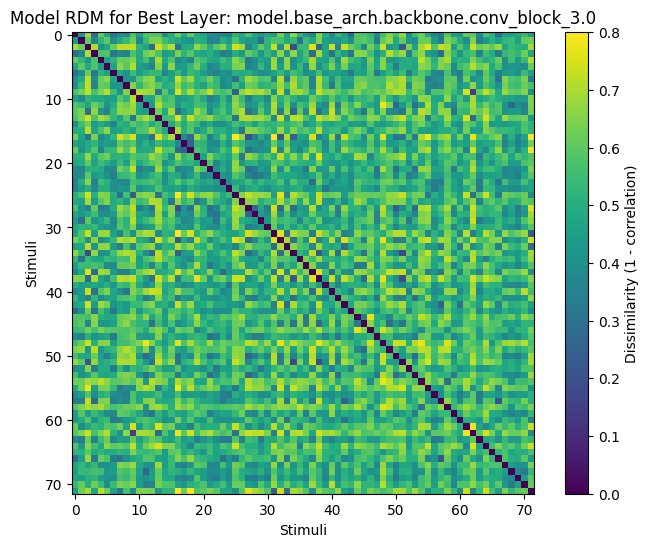

In [11]:
import matplotlib.pyplot as plt

# Print out the best layer name from the summary.
best_layer = summary["best_layer_mode"]
print(f"Best layer (most frequently selected): {best_layer}")

# Retrieve the RDM for the best layer.
best_model_rdm = model_activation_data[best_layer]

# Plot the best layer's RDM.
plt.figure(figsize=(8, 6))
plt.imshow(best_model_rdm, cmap='viridis', interpolation='nearest')
plt.title(f"Model RDM for Best Layer: {best_layer}")
plt.colorbar(label="Dissimilarity (1 - correlation)")
plt.xlabel("Stimuli")
plt.ylabel("Stimuli")
plt.show()


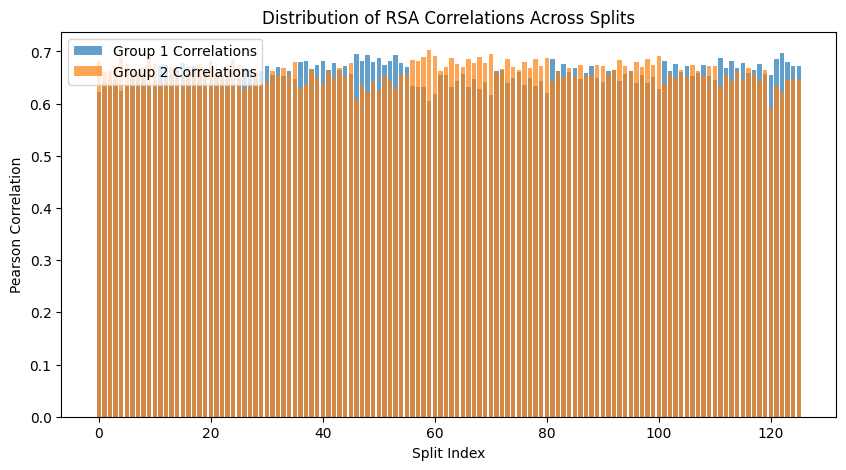

In [12]:
plt.figure(figsize=(10, 5))
plt.bar(range(len(group1_corrs)), group1_corrs, alpha=0.7, label="Group 1 Correlations")
plt.bar(range(len(group2_corrs)), group2_corrs, alpha=0.7, label="Group 2 Correlations")
plt.xlabel("Split Index")
plt.ylabel("Pearson Correlation")
plt.title("Distribution of RSA Correlations Across Splits")
plt.legend()
plt.show()


/tmp/ipykernel_213129/3204395347.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([group1_corrs, group2_corrs], labels=["Group 1", "Group 2"])


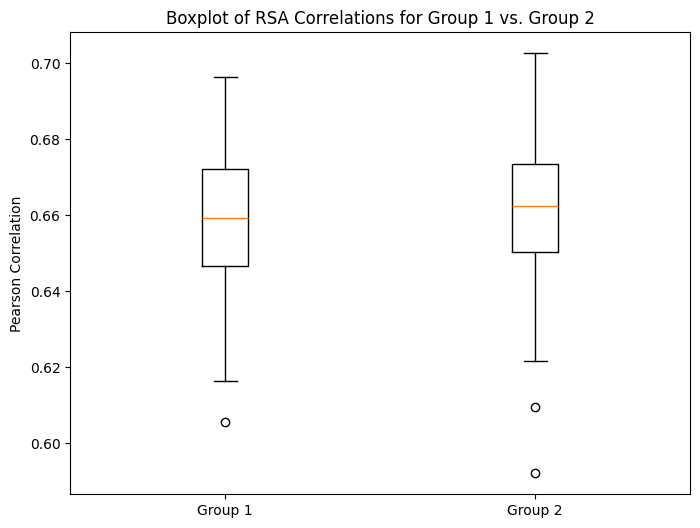

In [13]:
plt.figure(figsize=(8, 6))
plt.boxplot([group1_corrs, group2_corrs], labels=["Group 1", "Group 2"])
plt.title("Boxplot of RSA Correlations for Group 1 vs. Group 2")
plt.ylabel("Pearson Correlation")
plt.show()


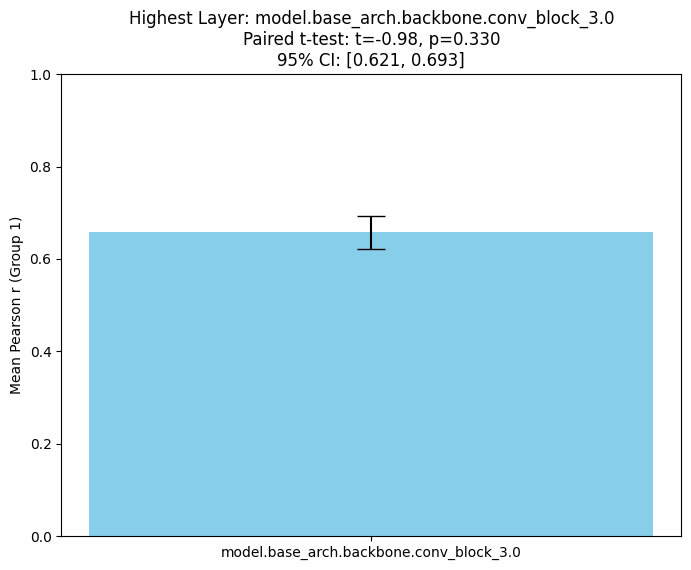

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Directly pull the values from the summary dictionary.
best_layer = summary["best_layer_mode"]
mean_corr = summary["group1_mean_corr"]
ci_lower, ci_upper = summary["confidence_interval"]
t_stat = summary["t_stat"]
p_val = summary["p_val"]

# Compute error bars (difference between mean and CI bounds)
error_lower = mean_corr - ci_lower
error_upper = ci_upper - mean_corr
errors = np.array([[error_lower], [error_upper]])

# Create a bar graph for the best layer.
plt.figure(figsize=(8, 6))
plt.bar(best_layer, mean_corr, yerr=errors, capsize=10, color='skyblue')
plt.ylabel("Mean Pearson r (Group 1)")
plt.ylim(0, 1)
plt.title(
    f"Highest Layer: {best_layer}\n"
    f"Paired t-test: t={t_stat:.2f}, p={p_val:.3f}\n"
    f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]"
)
plt.show()


# Saving Intermediates updated function

In [14]:
# defining rdms
with open('reliable_roi_rdms/EarlyV_reliable_rdms.pkl', 'rb') as file:
    EarlyV_rdms = pickle.load(file)
EarlyV_rdms_array = np.stack(EarlyV_rdms) # convert to array
rdms = {"EarlyV": EarlyV_rdms_array}


# defining model_activation_data
alexnet_activations = np.load('alexnet_activations.npz')
model_activation_data = {key: alexnet_activations[key] for key in alexnet_activations}

# defining brain region
brain_region = "EarlyV"

model_name = "Alexnet"

run_classical_rsa_validation(rdms, model_activation_data, brain_region, model_name, num_splits=None, save_intermediates_path= "./Stats_intermediate_results")

Converted layer 'model.base_arch.backbone.conv_block_1.0' to RDM with shape (72, 72)
Converted layer 'model.base_arch.backbone.conv_block_1.1' to RDM with shape (72, 72)
Converted layer 'model.base_arch.backbone.conv_block_1.2' to RDM with shape (72, 72)
Converted layer 'model.base_arch.backbone.conv_block_1.3' to RDM with shape (72, 72)
Converted layer 'model.base_arch.backbone.conv_block_2.0' to RDM with shape (72, 72)
Converted layer 'model.base_arch.backbone.conv_block_2.1' to RDM with shape (72, 72)
Converted layer 'model.base_arch.backbone.conv_block_2.2' to RDM with shape (72, 72)
Converted layer 'model.base_arch.backbone.conv_block_2.3' to RDM with shape (72, 72)
Converted layer 'model.base_arch.backbone.conv_block_3.0' to RDM with shape (72, 72)
Converted layer 'model.base_arch.backbone.conv_block_3.1' to RDM with shape (72, 72)
Converted layer 'model.base_arch.backbone.conv_block_3.2' to RDM with shape (72, 72)
Converted layer 'model.base_arch.backbone.conv_block_4.0' to RDM 

Intermediate results saved to ./Stats_intermediate_results/EarlyV_Alexnet_intermediates.csv
Intermediate results saved to ./Stats_intermediate_results/EarlyV_Alexnet_intermediates.csv


({'group1_mean_corr': 0.6582981057409688,
  'group2_mean_corr': 0.661427310142089,
  't_stat': -0.9777011999186577,
  'p_val': 0.33011053005454416,
  'confidence_interval': (0.6213176109622701, 0.6930378259322185),
  'best_layer_mode': 'model.base_arch.backbone.conv_block_3.0',
  'total_splits_used': 126},
 [0.6221526707524574,
  0.6407750872563711,
  0.6467864795862829,
  0.644501276980358,
  0.624023263670123,
  0.6359849658828862,
  0.6534738686667674,
  0.6557043277949466,
  0.6549788145576294,
  0.6341228825755836,
  0.6439006411980683,
  0.6743254668602463,
  0.6732835403475937,
  0.6555852417624589,
  0.6647752386869532,
  0.6781884658213977,
  0.6589649649556376,
  0.6713251055017881,
  0.6552973165359028,
  0.6639940431805489,
  0.6454799386586656,
  0.6514248439299275,
  0.6531609973505788,
  0.6535839118165755,
  0.6347103308361798,
  0.6467330497238573,
  0.6676614180018744,
  0.6669946346237359,
  0.652013171913138,
  0.6630356870866785,
  0.6721634415389082,
  0.655255127

In [ ]:
'''saving and loading intermediates example!'''

import pandas as pd

# Load the saved intermediate results
df_intermediates = pd.read_csv("rsa_intermediates_EarlyV.csv")
print(df_intermediates.head())

import matplotlib.pyplot as plt

# Suppose df_intermediates has columns 'best_layer' and 'group1_corr'
# and you have run the pipeline for multiple models, each saved with its own file or combined.

# If you have multiple rows with best layer assignments, you can compute the average group1 correlation
# for each best layer:
df_grouped = df_intermediates.groupby('best_layer')['group1_corr'].mean().reset_index()

# Create a bar plot:
plt.figure(figsize=(10, 6))
plt.bar(df_grouped['best_layer'], df_grouped['group1_corr'], color='skyblue', edgecolor='k')
plt.xlabel('Best Layer')
plt.ylabel('Mean Group1 Pearson r')
plt.title('Average Group1 Pearson r by Best Layer for ROI: EarlyV')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [4]:
# import os
# import pandas as pd
# from io import StringIO

# def read_intermediates_csv(filepath):
#     """
#     Read a CSV file that contains summary and intermediate sections.
#     This function will skip lines until it finds the "# INTERMEDIATES" marker,
#     then read the rest of the file into a DataFrame.
    
#     Parameters:
#       filepath (str): Path to the CSV file.
      
#     Returns:
#       pd.DataFrame: DataFrame of the intermediate results.
#     """
#     with open(filepath, "r") as f:
#         lines = f.readlines()
    
#     # Find the index after the "# INTERMEDIATES" line.
#     start_idx = None
#     for i, line in enumerate(lines):
#         if line.strip().startswith("# INTERMEDIATES"):
#             start_idx = i + 1  # Start reading from the next line.
#             break
#     if start_idx is None:
#         raise ValueError("Could not find '# INTERMEDIATES' marker in the file.")
    
#     # Join the lines after the marker.
#     csv_content = "".join(lines[start_idx:])
#     # Read into a DataFrame.
#     df = pd.read_csv(StringIO(csv_content))
#     return df

# def read_intermediate_data(fp):
#     """
#     Read the intermediate section of the CSV file.
#     This function ignores lines starting with '#' (comments).
#     """
#     with open(fp, "r") as f:
#         # Filter out comment lines.
#         lines = [line for line in f if not line.strip().startswith("#")]
#     csv_str = "".join(lines)
#     # Read CSV from the filtered string.
#     inter_df = pd.read_csv(StringIO(csv_str))
#     return inter_df


In [24]:
# Example usage:
save_dir = "./Stats_intermediate_results"
brain_region = "EarlyV"
model_name = "Alexnet"
filename = f"{brain_region}_{model_name}_intermediates.csv"
filepath = os.path.join(save_dir, filename)

df_intermediates = read_intermediates_csv(filepath)
print(df_intermediates.head())

   split      group1_idxs      group2_idxs  \
0      0  [0, 1, 2, 3, 4]  [5, 6, 7, 8, 9]   
1      1  [0, 1, 2, 3, 5]  [4, 6, 7, 8, 9]   
2      2  [0, 1, 2, 3, 6]  [4, 5, 7, 8, 9]   
3      3  [0, 1, 2, 3, 7]  [4, 5, 6, 8, 9]   
4      4  [0, 1, 2, 3, 8]  [4, 5, 6, 7, 9]   

                                best_layer  group1_corr  group2_corr  \
0  model.base_arch.backbone.conv_block_3.0     0.622153     0.682183   
1  model.base_arch.backbone.conv_block_3.0     0.640775     0.659706   
2  model.base_arch.backbone.conv_block_3.0     0.646786     0.663435   
3  model.base_arch.backbone.conv_block_3.0     0.644501     0.669915   
4  model.base_arch.backbone.conv_block_3.0     0.624023     0.689059   

                                      avg_rdm_group1  \
0  [[9.99999999995449e-06, 0.3572246974722869, 0....   
1  [[9.99999999995449e-06, 0.34659046756999934, 0...   
2  [[9.99999999995449e-06, 0.3183389570722932, 0....   
3  [[9.99999999995449e-06, 0.31799341364213707, 0...   
4  [[9.999

In [2]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import ast

# Helper function to read the SUMMARY section from an intermediate CSV file.
def read_summary_csv(filepath):
    """
    Read the SUMMARY section from the CSV file.
    The file is assumed to start with a line "# SUMMARY",
    followed by CSV lines, then a blank line or a line starting with '#' indicating the end of the summary.
    
    Returns:
      A pandas DataFrame with the summary results.
    """
    with open(filepath, "r") as f:
        lines = f.readlines()

    summary_lines = []
    found_summary = False
    for line in lines:
        if line.strip().startswith("# SUMMARY"):
            found_summary = True
            continue
        if found_summary:
            # Stop if we hit a blank line or a new comment section.
            if line.strip() == "" or line.strip().startswith("#"):
                break
            summary_lines.append(line)
    
    summary_csv = "".join(summary_lines)
    summary_df = pd.read_csv(StringIO(summary_csv))
    return summary_df

In [ ]:
# # Example of code to plot all intermediates in one plot

# import os
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from io import StringIO
# import ast

# # Helper function to read the SUMMARY section from an intermediate CSV file.
# def read_summary_csv(filepath):
#     """
#     Read the SUMMARY section from the CSV file.
#     The file is assumed to start with a line "# SUMMARY",
#     followed by CSV lines, then a blank line or a line starting with '#' indicating the end of the summary.
    
#     Returns:
#       A pandas DataFrame with the summary results.
#     """
#     with open(filepath, "r") as f:
#         lines = f.readlines()

#     summary_lines = []
#     found_summary = False
#     for line in lines:
#         if line.strip().startswith("# SUMMARY"):
#             found_summary = True
#             continue
#         if found_summary:
#             # Stop if we hit a blank line or a new comment section.
#             if line.strip() == "" or line.strip().startswith("#"):
#                 break
#             summary_lines.append(line)
    
#     summary_csv = "".join(summary_lines)
#     summary_df = pd.read_csv(StringIO(summary_csv))
#     return summary_df

# Suppose you have intermediate results saved for several models.
# For example, let’s say you have these files:
filepaths = [
    "./Stats_intermediate_results/EarlyV_ReAlnet03_cornet_intermediates.csv",
    "./Stats_intermediate_results/EarlyV_ReAlnet04_cornet_intermediates.csv"
    # Add more file paths as needed.
]

# Read all summaries and add a column for the model name.
summaries = []
for fp in filepaths:
    df = read_summary_csv(fp)
    # Extract model name from the filename, for example.
    model_name = os.path.basename(fp).split("_")[1]
    df["model"] = model_name
    summaries.append(df)

# Combine all summaries into one DataFrame.
all_summaries = pd.concat(summaries, ignore_index=True)

# We assume that the summary DataFrame has at least these columns:
#   "group1_mean_corr" (the best RSA from group1),
#   "confidence_interval" (a tuple saved as a string, e.g. "(0.55, 0.65)"),
#   "best_layer_mode" (the best layer identifier)
#   "model" (we added this from filename)

# Convert the confidence_interval string to a tuple and then compute error bars.
def parse_ci(ci_str):
    # Use ast.literal_eval to safely parse the string into a tuple
    try:
        return ast.literal_eval(ci_str)
    except Exception as e:
        print(f"Error parsing confidence_interval: {ci_str} -- {e}")
        return (np.nan, np.nan)

all_summaries["ci"] = all_summaries["confidence_interval"].apply(parse_ci)
all_summaries["ci_lower"] = all_summaries["ci"].apply(lambda x: x[0])
all_summaries["ci_upper"] = all_summaries["ci"].apply(lambda x: x[1])
# Calculate the error bars (assuming symmetric errors around the mean)
all_summaries["error"] = (all_summaries["ci_upper"] - all_summaries["ci_lower"]) / 2

# Plotting: Bar plot of group1_mean_corr for each model with error bars.
plt.figure(figsize=(8, 6))
x = np.arange(len(all_summaries))
plt.bar(x, all_summaries["group1_mean_corr"], yerr=all_summaries["error"], capsize=5)
plt.xticks(x, all_summaries["model"], rotation=45)
plt.xlabel("Model")
plt.ylabel("Group1 Mean RSA (Pearson r)")
plt.title("Best Overall Layer RSA with 95% Confidence Intervals")
plt.tight_layout()
plt.show()


# Loading Stats for Top 5 overall Models: 1-5

In [31]:
import os
import torch
import pickle
import numpy as np
import pandas as pd

# Load reliable ROI RDMs.
with open('reliable_roi_rdms/EarlyV_reliable_rdms.pkl', 'rb') as file:
    EarlyV_rdms = pickle.load(file)
EarlyV_rdms_array = np.stack(EarlyV_rdms)
rdms = {"EarlyV": EarlyV_rdms_array}

# List of models to run.
models_to_run = [
    ("convnext_large_mlp", "model_1_activations_stages.pt"),
    ("convnext_xlarge", "model_2_activations_stages.pt"),
    ("vit_base_patch16_clip_224", "model_3_activations_blocks.pt"),
    ("vit_large_patch_14_clip:laion2b_ft_in1k", "model_4_activations_blocks.pt"),
    ("vit_large_patch_14_clip: openai_ft_in1k", "model_5_activations_blocks.pt"),
]

# Specify brain region.
brain_region = "EarlyV"

# Create folder for intermediate results if it doesn't exist.
save_dir = "./Stats_intermediate_Top_5_models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

all_model_summaries = []

for model_name, act_file in models_to_run:
    # Load activation data from the .pt file.
    loaded_data = torch.load(act_file)
    
    # Convert every tensor to a NumPy array.
    model_activation_data = {}
    for key, value in loaded_data.items():
        if isinstance(value, torch.Tensor):
            model_activation_data[key] = value.detach().cpu().numpy()
        else:
            model_activation_data[key] = value

    # Now run RSA validation (the conversion loop inside the function will handle further reshaping).
    summary, g1_corrs, g2_corrs = run_classical_rsa_validation(
        rdms,
        model_activation_data,
        brain_region,
        model_name,
        num_splits=None,
        save_intermediates_path=save_dir
    )

    print(f"Model {model_name} summary:")
    print(summary)
    all_model_summaries.append(summary)


Intermediate results saved to ./Stats_intermediate_Top_5_models/EarlyV_convnext_large_mlp_intermediates.csv
Intermediate results saved to ./Stats_intermediate_Top_5_models/EarlyV_convnext_large_mlp_intermediates.csv
Model convnext_large_mlp summary:
{'group1_mean_corr': 0.6387961820235062, 'group2_mean_corr': 0.6504110343324111, 't_stat': -4.005001117372715, 'p_val': 0.00010572492932562205, 'confidence_interval': (0.6042803544295807, 0.6714804867595945), 'best_layer_mode': 'stages.2', 'total_splits_used': 126}


Intermediate results saved to ./Stats_intermediate_Top_5_models/EarlyV_convnext_xlarge_intermediates.csv
Intermediate results saved to ./Stats_intermediate_Top_5_models/EarlyV_convnext_xlarge_intermediates.csv
Model convnext_xlarge summary:
{'group1_mean_corr': 0.5749525783521027, 'group2_mean_corr': 0.5765037420294451, 't_stat': -0.422633856801441, 'p_val': 0.6732885494298982, 'confidence_interval': (0.5320057724655821, 0.615645306290037), 'best_layer_mode': 'stages.1', 'total_splits_used': 126}


Intermediate results saved to ./Stats_intermediate_Top_5_models/EarlyV_vit_base_patch16_clip_224_intermediates.csv
Intermediate results saved to ./Stats_intermediate_Top_5_models/EarlyV_vit_base_patch16_clip_224_intermediates.csv
Model vit_base_patch16_clip_224 summary:
{'group1_mean_corr': 0.5581767053311897, 'group2_mean_corr': 0.570102972723563, 't_stat': -3.505807983270164, 'p_val': 0.0006328045642074037, 'confidence_interval': (0.5173047611568622, 0.5971083850375455), 'best_layer_mode': 'blocks.6', 'total_splits_used': 126}


Intermediate results saved to ./Stats_intermediate_Top_5_models/EarlyV_vit_large_patch_14_clip:laion2b_ft_in1k_intermediates.csv
Intermediate results saved to ./Stats_intermediate_Top_5_models/EarlyV_vit_large_patch_14_clip:laion2b_ft_in1k_intermediates.csv
Model vit_large_patch_14_clip:laion2b_ft_in1k summary:
{'group1_mean_corr': 0.4329542826468786, 'group2_mean_corr': 0.43324336938162367, 't_stat': -0.08179699719058753, 'p_val': 0.9349389747156336, 'confidence_interval': (0.39379531032832715, 0.4709145892636711), 'best_layer_mode': 'blocks.11', 'total_splits_used': 126}


Intermediate results saved to ./Stats_intermediate_Top_5_models/EarlyV_vit_large_patch_14_clip: openai_ft_in1k_intermediates.csv
Intermediate results saved to ./Stats_intermediate_Top_5_models/EarlyV_vit_large_patch_14_clip: openai_ft_in1k_intermediates.csv
Model vit_large_patch_14_clip: openai_ft_in1k summary:
{'group1_mean_corr': 0.5060530689423413, 'group2_mean_corr': 0.5280186897454103, 't_stat': -3.8750131973067288, 'p_val': 0.00017114103755463706, 'confidence_interval': (0.43938637685709925, 0.5684834633122026), 'best_layer_mode': 'blocks.21', 'total_splits_used': 126}


# Loading Top Neural Vision Models: 145, 150, 15, 7, 1

In [2]:
import os
import torch
import pickle
import numpy as np
import pandas as pd

# Load reliable ROI RDMs.
with open('reliable_roi_rdms/EarlyV_reliable_rdms.pkl', 'rb') as file:
    EarlyV_rdms = pickle.load(file)
EarlyV_rdms_array = np.stack(EarlyV_rdms)
rdms = {"EarlyV": EarlyV_rdms_array}

# List of models to run.
models_to_run = [
    ("145: alexnet_training_seed_01", "model_145_features_classifiers_activations.pt"),
    ("150: alexnet_training_seed_10", "model_150_features_classifiers_activations.pt"),
    ("15: convnext_tiny_imagenet_full", "model_15_activation_features.pt"),
    ("7: vit_relpos_base_patch16", "Model_7_activations_block.pt"),
    ("1: convnext_large_mlp", "model_1_activations_stages.pt"),
]

# Specify brain region.
brain_region = "EarlyV"

# Create folder for intermediate results if it doesn't exist.
save_dir = "./Stats_EarlyV_Top_Avg_Vision"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

all_model_summaries = []

for model_name, act_file in models_to_run:
    # Load activation data from the .pt file.
    loaded_data = torch.load(act_file)
    
    # Convert every tensor to a NumPy array.
    model_activation_data = {}
    for key, value in loaded_data.items():
        if isinstance(value, torch.Tensor):
            model_activation_data[key] = value.detach().cpu().numpy()
        else:
            model_activation_data[key] = value

    # Now run RSA validation (the conversion loop inside the function will handle further reshaping).
    summary, g1_corrs, g2_corrs = run_classical_rsa_validation(
        rdms,
        model_activation_data,
        brain_region,
        model_name,
        num_splits=None,
        save_intermediates_path=save_dir
    )

    print(f"Model {model_name} summary:")
    print(summary)
    all_model_summaries.append(summary)


Intermediate results saved to ./Stats_EarlyV_Top_Avg_Vision/EarlyV_145: alexnet_training_seed_01_intermediates.csv
Intermediate results saved to ./Stats_EarlyV_Top_Avg_Vision/EarlyV_145: alexnet_training_seed_01_intermediates.csv
Model 145: alexnet_training_seed_01 summary:
{'group1_mean_corr': 0.24559311707507578, 'group2_mean_corr': 0.2500949555028748, 't_stat': -0.8649267160109464, 'p_val': 0.3887358759210173, 'confidence_interval': (0.186609183290362, 0.3032349652366731), 'best_layer_mode': 'classifier.1', 'total_splits_used': 126}


Intermediate results saved to ./Stats_EarlyV_Top_Avg_Vision/EarlyV_150: alexnet_training_seed_10_intermediates.csv
Intermediate results saved to ./Stats_EarlyV_Top_Avg_Vision/EarlyV_150: alexnet_training_seed_10_intermediates.csv
Model 150: alexnet_training_seed_10 summary:
{'group1_mean_corr': 0.24559311707507578, 'group2_mean_corr': 0.2500949555028748, 't_stat': -0.8649267160109464, 'p_val': 0.3887358759210173, 'confidence_interval': (0.186609183290362, 0.3032349652366731), 'best_layer_mode': 'classifier.1', 'total_splits_used': 126}


Intermediate results saved to ./Stats_EarlyV_Top_Avg_Vision/EarlyV_15: convnext_tiny_imagenet_full_intermediates.csv
Intermediate results saved to ./Stats_EarlyV_Top_Avg_Vision/EarlyV_15: convnext_tiny_imagenet_full_intermediates.csv
Model 15: convnext_tiny_imagenet_full summary:
{'group1_mean_corr': 0.682051254587607, 'group2_mean_corr': 0.6944037635529525, 't_stat': -3.438940210839076, 'p_val': 0.0007940653527132867, 'confidence_interval': (0.6389523240705466, 0.7218722520735961), 'best_layer_mode': 'features.5', 'total_splits_used': 126}


Intermediate results saved to ./Stats_EarlyV_Top_Avg_Vision/EarlyV_7: vit_relpos_base_patch16_intermediates.csv
Intermediate results saved to ./Stats_EarlyV_Top_Avg_Vision/EarlyV_7: vit_relpos_base_patch16_intermediates.csv
Model 7: vit_relpos_base_patch16 summary:
{'group1_mean_corr': 0.2411572483096316, 'group2_mean_corr': 0.21377064870234339, 't_stat': 7.072136373910205, 'p_val': 9.57390855194511e-11, 'confidence_interval': (0.20734013858188918, 0.2745252667394236), 'best_layer_mode': 'blocks.11', 'total_splits_used': 126}


Intermediate results saved to ./Stats_EarlyV_Top_Avg_Vision/EarlyV_1: convnext_large_mlp_intermediates.csv
Intermediate results saved to ./Stats_EarlyV_Top_Avg_Vision/EarlyV_1: convnext_large_mlp_intermediates.csv
Model 1: convnext_large_mlp summary:
{'group1_mean_corr': 0.6387961820235062, 'group2_mean_corr': 0.6504110343324111, 't_stat': -4.005001117372715, 'p_val': 0.00010572492932562205, 'confidence_interval': (0.6042803544295807, 0.6714804867595945), 'best_layer_mode': 'stages.2', 'total_splits_used': 126}


# Top V1 Models

In [16]:
import os
import torch
import pickle
import numpy as np
import pandas as pd

# Load reliable ROI RDMs.
with open('reliable_roi_rdms/EarlyV_reliable_rdms.pkl', 'rb') as file:
    EarlyV_rdms = pickle.load(file)
EarlyV_rdms_array = np.stack(EarlyV_rdms)
rdms = {"EarlyV": EarlyV_rdms_array}

# List of models to run.
models_to_run = [
    ("151: alexnet_training_seed_07", "model_151_features_classifiers_activations.pt"),
    ("163: alexnet_training_seed_09", "model_163_features_classifiers_activations.pt"),
    ("166: alexnet_training_seed_02", "model_166_features_classifiers.pt")
    
]

# Specify brain region.
brain_region = "EarlyV"

# Create folder for intermediate results if it doesn't exist.
save_dir = "./Stats_EarlyV_Top_V1"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

all_model_summaries = []

for model_name, act_file in models_to_run:
    # Load activation data from the .pt file.
    loaded_data = torch.load(act_file)
    
    # Convert every tensor to a NumPy array.
    model_activation_data = {}
    for key, value in loaded_data.items():
        if isinstance(value, torch.Tensor):
            model_activation_data[key] = value.detach().cpu().numpy()
        else:
            model_activation_data[key] = value

    # Now run RSA validation (the conversion loop inside the function will handle further reshaping).
    summary, g1_corrs, g2_corrs = run_classical_rsa_validation(
        rdms,
        model_activation_data,
        brain_region,
        model_name,
        num_splits=None,
        save_intermediates_path=save_dir
    )

    print(f"Model {model_name} summary:")
    print(summary)
    all_model_summaries.append(summary)


Intermediate results saved to ./Stats_EarlyV_Top_V1/EarlyV_151: alexnet_training_seed_07_intermediates.csv
Intermediate results saved to ./Stats_EarlyV_Top_V1/EarlyV_151: alexnet_training_seed_07_intermediates.csv
Model 151: alexnet_training_seed_07 summary:
{'group1_mean_corr': 0.27669875281126177, 'group2_mean_corr': 0.28525717405422174, 't_stat': -1.460371736024748, 'p_val': 0.14669682322458052, 'confidence_interval': (0.21028957383404562, 0.34117880644180915), 'best_layer_mode': 'classifier.1', 'total_splits_used': 126}


Intermediate results saved to ./Stats_EarlyV_Top_V1/EarlyV_163: alexnet_training_seed_09_intermediates.csv
Intermediate results saved to ./Stats_EarlyV_Top_V1/EarlyV_163: alexnet_training_seed_09_intermediates.csv
Model 163: alexnet_training_seed_09 summary:
{'group1_mean_corr': 0.2227464074291, 'group2_mean_corr': 0.23019112532586222, 't_stat': -1.1263490483887053, 'p_val': 0.26217555088592315, 'confidence_interval': (0.14807478168051086, 0.2955038490545936), 'best_layer_mode': 'classifier.1', 'total_splits_used': 126}


Intermediate results saved to ./Stats_EarlyV_Top_V1/EarlyV_166: alexnet_training_seed_02_intermediates.csv
Intermediate results saved to ./Stats_EarlyV_Top_V1/EarlyV_166: alexnet_training_seed_02_intermediates.csv
Model 166: alexnet_training_seed_02 summary:
{'group1_mean_corr': 0.2970596748035943, 'group2_mean_corr': 0.2997458999705795, 't_stat': -0.5046338312211611, 'p_val': 0.6147044864752631, 'confidence_interval': (0.23643160154202247, 0.35593661252618186), 'best_layer_mode': 'classifier.1', 'total_splits_used': 126}


# Top V2

In [17]:
import os
import torch
import pickle
import numpy as np
import pandas as pd

# Load reliable ROI RDMs.
with open('reliable_roi_rdms/EarlyV_reliable_rdms.pkl', 'rb') as file:
    EarlyV_rdms = pickle.load(file)
EarlyV_rdms_array = np.stack(EarlyV_rdms)
rdms = {"EarlyV": EarlyV_rdms_array}

# List of models to run.
models_to_run = [
    ("170: alexnet_training_seed_03", "model_170_features_classifiers_activations.pt"),
    ("157: alexnet_training_seed_06", "model_157_features_classifiers_activations.pt")
   
]

# Specify brain region.
brain_region = "EarlyV"

# Create folder for intermediate results if it doesn't exist.
save_dir = "./Stats_EarlyV_Top_V2"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

all_model_summaries = []

for model_name, act_file in models_to_run:
    # Load activation data from the .pt file.
    loaded_data = torch.load(act_file)
    
    # Convert every tensor to a NumPy array.
    model_activation_data = {}
    for key, value in loaded_data.items():
        if isinstance(value, torch.Tensor):
            model_activation_data[key] = value.detach().cpu().numpy()
        else:
            model_activation_data[key] = value

    # Now run RSA validation (the conversion loop inside the function will handle further reshaping).
    summary, g1_corrs, g2_corrs = run_classical_rsa_validation(
        rdms,
        model_activation_data,
        brain_region,
        model_name,
        num_splits=None,
        save_intermediates_path=save_dir
    )

    print(f"Model {model_name} summary:")
    print(summary)
    all_model_summaries.append(summary)


Intermediate results saved to ./Stats_EarlyV_Top_V2/EarlyV_170: alexnet_training_seed_03_intermediates.csv
Intermediate results saved to ./Stats_EarlyV_Top_V2/EarlyV_170: alexnet_training_seed_03_intermediates.csv
Model 170: alexnet_training_seed_03 summary:
{'group1_mean_corr': 0.2856908725186076, 'group2_mean_corr': 0.2928287140192461, 't_stat': -1.3318234625135936, 'p_val': 0.18534158523206717, 'confidence_interval': (0.2248534792144079, 0.34484263983476693), 'best_layer_mode': 'features.12', 'total_splits_used': 126}


Intermediate results saved to ./Stats_EarlyV_Top_V2/EarlyV_157: alexnet_training_seed_06_intermediates.csv
Intermediate results saved to ./Stats_EarlyV_Top_V2/EarlyV_157: alexnet_training_seed_06_intermediates.csv
Model 157: alexnet_training_seed_06 summary:
{'group1_mean_corr': 0.40960295789220974, 'group2_mean_corr': 0.41658551071714, 't_stat': -1.2412569435193066, 'p_val': 0.21683514493849865, 'confidence_interval': (0.34450512417658746, 0.4717176447683717), 'best_layer_mode': 'features.12', 'total_splits_used': 126}


# Top V4


In [18]:
import os
import torch
import pickle
import numpy as np
import pandas as pd

# Load reliable ROI RDMs.
with open('reliable_roi_rdms/EarlyV_reliable_rdms.pkl', 'rb') as file:
    EarlyV_rdms = pickle.load(file)
EarlyV_rdms_array = np.stack(EarlyV_rdms)
rdms = {"EarlyV": EarlyV_rdms_array}

# List of models to run.
models_to_run = [
    ("69: efficientnet_b2_imagenet_full", "model_69_activation_features.pt"),
    ("39: cvt_cvt-21-384-in1k_4_LucyV4", "model_39_activations_cvt_stages.pt")
   
]

# Specify brain region.
brain_region = "EarlyV"

# Create folder for intermediate results if it doesn't exist.
save_dir = "./Stats_EarlyV_Top_V4"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

all_model_summaries = []

for model_name, act_file in models_to_run:
    # Load activation data from the .pt file.
    loaded_data = torch.load(act_file)
    
    # Convert every tensor to a NumPy array.
    model_activation_data = {}
    for key, value in loaded_data.items():
        if isinstance(value, torch.Tensor):
            model_activation_data[key] = value.detach().cpu().numpy()
        else:
            model_activation_data[key] = value

    # Now run RSA validation (the conversion loop inside the function will handle further reshaping).
    summary, g1_corrs, g2_corrs = run_classical_rsa_validation(
        rdms,
        model_activation_data,
        brain_region,
        model_name,
        num_splits=None,
        save_intermediates_path=save_dir
    )

    print(f"Model {model_name} summary:")
    print(summary)
    all_model_summaries.append(summary)


Intermediate results saved to ./Stats_EarlyV_Top_V4/EarlyV_69: efficientnet_b2_imagenet_full_intermediates.csv
Intermediate results saved to ./Stats_EarlyV_Top_V4/EarlyV_69: efficientnet_b2_imagenet_full_intermediates.csv
Model 69: efficientnet_b2_imagenet_full summary:
{'group1_mean_corr': 0.4435273443242314, 'group2_mean_corr': 0.4276980668615534, 't_stat': 6.0324531683329665, 'p_val': 1.696342619112824e-08, 'confidence_interval': (0.416433372785113, 0.4700120532615781), 'best_layer_mode': 'features.6', 'total_splits_used': 126}


Intermediate results saved to ./Stats_EarlyV_Top_V4/EarlyV_39: cvt_cvt-21-384-in1k_4_LucyV4_intermediates.csv
Intermediate results saved to ./Stats_EarlyV_Top_V4/EarlyV_39: cvt_cvt-21-384-in1k_4_LucyV4_intermediates.csv
Model 39: cvt_cvt-21-384-in1k_4_LucyV4 summary:
{'group1_mean_corr': 0.5870828596667809, 'group2_mean_corr': 0.5957247461817515, 't_stat': -2.199076097959777, 'p_val': 0.029712415362722615, 'confidence_interval': (0.5398279060970301, 0.631517636865181), 'best_layer_mode': 'cvt.encoder.stages.2.layers.4', 'total_splits_used': 126}


In [3]:
import os
import torch
import pickle
import numpy as np
import pandas as pd

# Load reliable ROI RDMs.
with open('reliable_roi_rdms/EarlyV_reliable_rdms.pkl', 'rb') as file:
    EarlyV_rdms = pickle.load(file)
EarlyV_rdms_array = np.stack(EarlyV_rdms)
rdms = {"EarlyV": EarlyV_rdms_array}

# List of models to run.
models_to_run = [
    ("dino_large", "dino_large_block_activations.pt")

]

# Specify brain region.
brain_region = "EarlyV"

# Create folder for intermediate results if it doesn't exist.
save_dir = "./Stats_additional_models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

all_model_summaries = []

for model_name, act_file in models_to_run:
    # Load activation data from the .pt file.
    loaded_data = torch.load(act_file)
    
    # Convert every tensor to a NumPy array.
    model_activation_data = {}
    for key, value in loaded_data.items():
        if isinstance(value, torch.Tensor):
            model_activation_data[key] = value.detach().cpu().numpy()
        else:
            model_activation_data[key] = value

    # Now run RSA validation (the conversion loop inside the function will handle further reshaping).
    summary, g1_corrs, g2_corrs = run_classical_rsa_validation(
        rdms,
        model_activation_data,
        brain_region,
        model_name,
        num_splits=None,
        save_intermediates_path=save_dir
    )

    print(f"Model {model_name} summary:")
    print(summary)
    all_model_summaries.append(summary)


Intermediate results saved to ./Stats_additional_models/EarlyV_dino_large_intermediates.csv
Intermediate results saved to ./Stats_additional_models/EarlyV_dino_large_intermediates.csv
Model dino_large summary:
{'group1_mean_corr': 0.45970182804077736, 'group2_mean_corr': 0.46621427125425835, 't_stat': -1.6147483333219914, 'p_val': 0.10888664935563142, 'confidence_interval': (0.41272219915545255, 0.5048227455280869), 'best_layer_mode': 'blocks.18', 'total_splits_used': 126}


# Visualizing Bar graphs

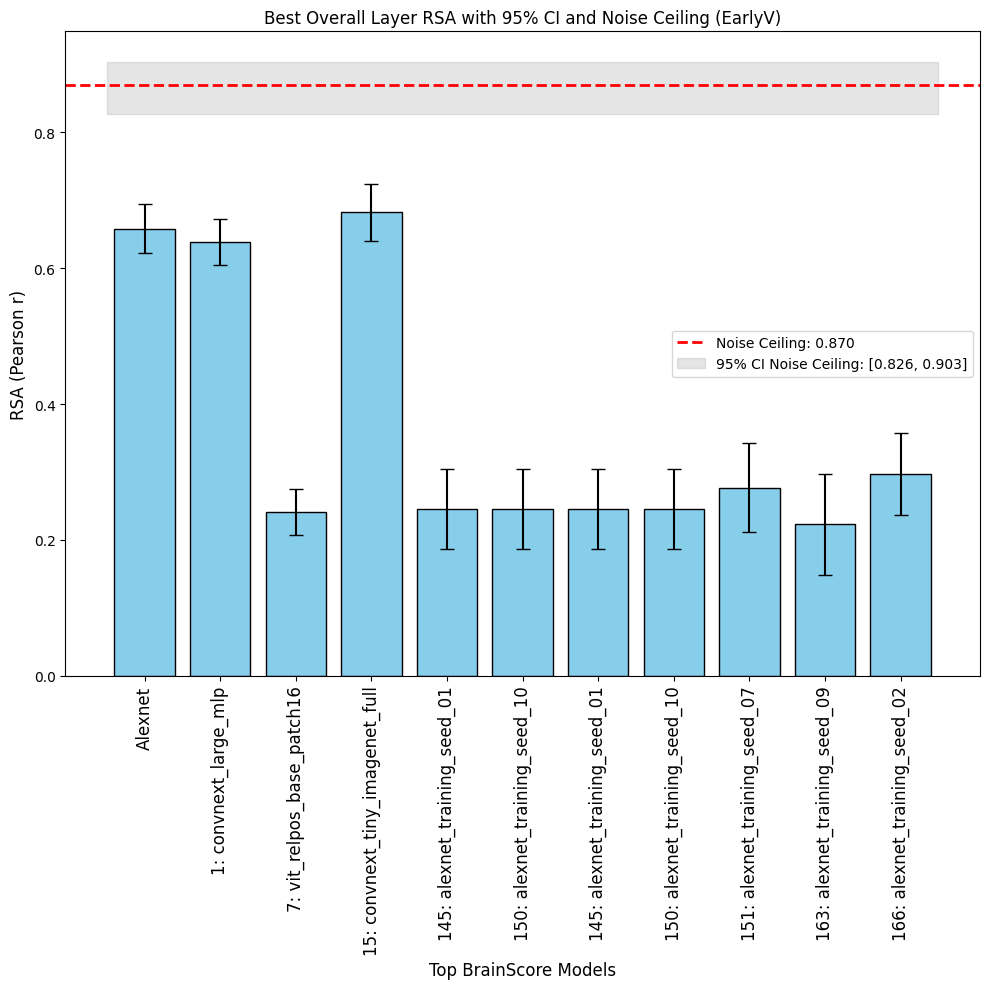

In [ ]:

# For example, let’s say you have these files:
filepaths = [
    "Stats_intermediate_Alexnet/EarlyV_Alexnet_intermediates.csv",
    #top neural avg
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_1: convnext_large_mlp_intermediates.csv",
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_7: vit_relpos_base_patch16_intermediates.csv",
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_15: convnext_tiny_imagenet_full_intermediates.csv",
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_145: alexnet_training_seed_01_intermediates.csv",
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_150: alexnet_training_seed_10_intermediates.csv",

    # Top V1
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_145: alexnet_training_seed_01_intermediates.csv",
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_150: alexnet_training_seed_10_intermediates.csv",
    "Stats_EarlyV_Top_V1/EarlyV_151: alexnet_training_seed_07_intermediates.csv",
    "Stats_EarlyV_Top_V1/EarlyV_163: alexnet_training_seed_09_intermediates.csv",
    "Stats_EarlyV_Top_V1/EarlyV_166: alexnet_training_seed_02_intermediates.csv"

   

  
]

summaries = []
for fp in filepaths:
    df = read_summary_csv(fp)
    # cleaning up the model name
    base = os.path.basename(fp)
    no_ext = os.path.splitext(base)[0]
    region_and_model = no_ext.split("_", 1)
    model_name_clean = region_and_model[1].replace("_intermediates", "")
    df["model"] = model_name_clean
    summaries.append(df)

# Combine all summaries into one DataFrame.
all_summaries = pd.concat(summaries, ignore_index=True)


# Convert the confidence_interval string to a tuple and then compute error bars.
def parse_ci(ci_str):
    # Use ast.literal_eval to safely parse the string into a tuple
    try:
        return ast.literal_eval(ci_str)
    except Exception as e:
        print(f"Error parsing confidence_interval: {ci_str} -- {e}")
        return (np.nan, np.nan)

all_summaries["ci"] = all_summaries["confidence_interval"].apply(parse_ci)
all_summaries["ci_lower"] = all_summaries["ci"].apply(lambda x: x[0])
all_summaries["ci_upper"] = all_summaries["ci"].apply(lambda x: x[1])
# Calculate the error bars (assuming symmetric errors around the mean)
all_summaries["error"] = (all_summaries["ci_upper"] - all_summaries["ci_lower"]) / 2

# # Plotting: Bar plot of group1_mean_corr for each model with error bars.
# plt.figure(figsize=(8, 6))
# x = np.arange(len(all_summaries))
# plt.bar(x, all_summaries["group1_mean_corr"], yerr=all_summaries["error"], capsize=5)
# plt.xticks(x, all_summaries["model"], rotation= 90)
# plt.xlabel("Model")
# plt.ylabel("Group1 Mean RSA (Pearson r)")
# plt.title("Best Overall Layer RSA with 95% Confidence Intervals")
# plt.tight_layout()
# plt.show()

# --- Compute the noise ceiling for the ROI (e.g., EarlyV) ---
# Assume you have your EarlyV RDMs loaded and converted to a NumPy array:
import pickle
with open('reliable_roi_rdms/EarlyV_reliable_rdms.pkl', 'rb') as file:
    EarlyV_rdms = pickle.load(file)
EarlyV_rdms_array = np.stack(EarlyV_rdms)  # shape: (N, 72, 72)

# Compute noise ceiling using our previously defined function:
noise_results = compute_noise_ceiling(EarlyV_rdms_array, num_splits=None)
noise_ceiling = noise_results["noise_ceiling"]
noise_ci_lower, noise_ci_upper = noise_results["ci"]

# --- Plotting: Bar plot of group1_mean_corr for each model with noise ceiling ---
plt.figure(figsize=(10, 10))
x = np.arange(len(all_summaries))
plt.bar(x, all_summaries["group1_mean_corr"], yerr=all_summaries["error"], capsize=5, color='skyblue', edgecolor='k')

# Add a horizontal line for the noise ceiling.
plt.axhline(noise_ceiling, color='red', linestyle='--', linewidth=2, label=f"Noise Ceiling: {noise_ceiling:.3f}")
# Fill the 95% CI for the noise ceiling.
plt.fill_between([-0.5, len(all_summaries)-0.5], noise_ci_lower, noise_ci_upper, color='grey', alpha=0.2, 
                 label=f"95% CI Noise Ceiling: [{noise_ci_lower:.3f}, {noise_ci_upper:.3f}]")

plt.xticks(x, all_summaries["model"], rotation=90, fontsize = 12)
plt.xlabel("Top BrainScore Models", fontsize = 12)
plt.ylabel("RSA (Pearson r)", fontsize = 12)
plt.title("Best Overall Layer RSA with 95% CI and Noise Ceiling (EarlyV)")
plt.legend()
plt.tight_layout()
plt.show()

# trying paired ttest

In [6]:
import pickle
with open('reliable_roi_rdms/EarlyV_reliable_rdms.pkl', 'rb') as file:
    EarlyV_rdms = pickle.load(file)
EarlyV_rdms_array = np.stack(EarlyV_rdms)

# Best plot for EarlyV!!!

Comparing alexnet_pytorch vs. 145: alexnet_training_seed_01, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 150: alexnet_training_seed_10, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 15: convnext_tiny_imagenet_full, one-sided p-value = 1.0000
Comparing alexnet_pytorch vs. 7: vit_relpos_base_patch16, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 1: convnext_large_mlp, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 151: alexnet_training_seed_07, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 163: alexnet_training_seed_09, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 166: alexnet_training_seed_02, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. dinov2, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. dino_large, one-sided p-value = 0.0000


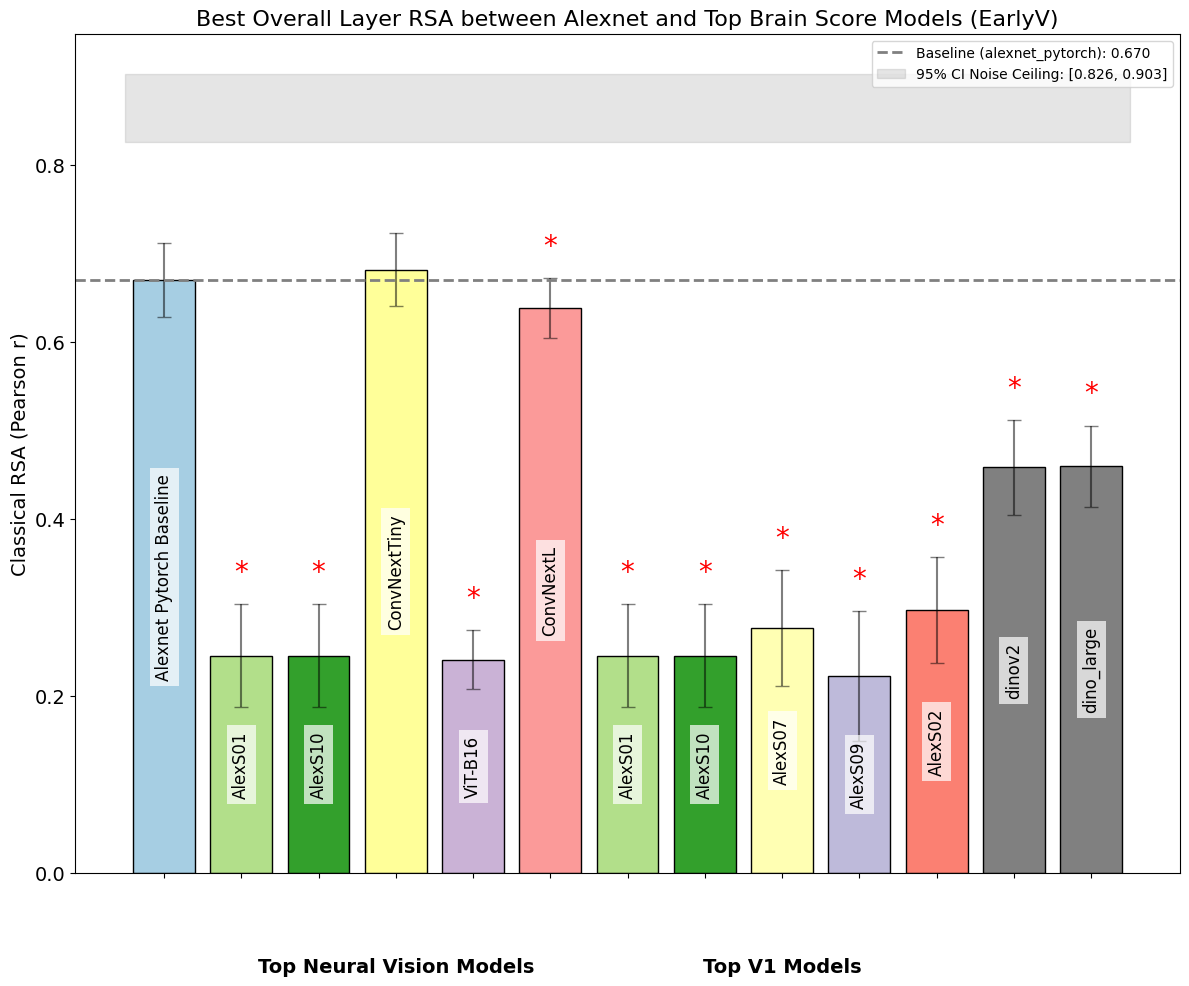

In [ ]:
# Best bar plot so far!

import pickle
with open('reliable_roi_rdms/EarlyV_reliable_rdms.pkl', 'rb') as file:
    EarlyV_rdms = pickle.load(file)
EarlyV_rdms_array = np.stack(EarlyV_rdms)

filepaths = [
    #"Stats_intermediate_Alexnet/EarlyV_Alexnet_intermediates.csv",
    "Stats_additional_models/EarlyV_alexnet_pytorch_intermediates.csv",
    # Top Neural (average)
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_145: alexnet_training_seed_01_intermediates.csv",
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_150: alexnet_training_seed_10_intermediates.csv",
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_15: convnext_tiny_imagenet_full_intermediates.csv",
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_7: vit_relpos_base_patch16_intermediates.csv",
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_1: convnext_large_mlp_intermediates.csv",
    
    # Top V1
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_145: alexnet_training_seed_01_intermediates.csv",
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_150: alexnet_training_seed_10_intermediates.csv",
    "Stats_EarlyV_Top_V1/EarlyV_151: alexnet_training_seed_07_intermediates.csv",
    "Stats_EarlyV_Top_V1/EarlyV_163: alexnet_training_seed_09_intermediates.csv",
    "Stats_EarlyV_Top_V1/EarlyV_166: alexnet_training_seed_02_intermediates.csv",

    "Stats_additional_models/EarlyV_dino_small_intermediates.csv",
    "Stats_additional_models/EarlyV_dino_large_intermediates.csv"

]

# --- Read Data with Order Preserved ---
summaries = []
intermediates_data = {}

for order, fp in enumerate(filepaths):
    summary_df = read_summary_csv(fp)
    base = os.path.basename(fp)
    no_ext = os.path.splitext(base)[0]
    parts = no_ext.split("_", 1)
    model_name_clean = parts[1].replace("_intermediates", "")
    summary_df["model"] = model_name_clean
    summary_df["order"] = order
    summaries.append(summary_df)

    inter_df = read_intermediate_data(fp)
    intermediates_data[model_name_clean] = inter_df

all_summaries = pd.concat(summaries, ignore_index=True)
all_summaries = all_summaries.sort_values("order")

# Create new columns based on the order value:
# For rows where the order is between 1 and 5, label them as Top Neural Vision Models.
all_summaries["Top Neural Vision Models"] = np.where(all_summaries["order"].between(1, 5),
                                                     all_summaries["model"],
                                                     np.nan)

# For rows where the order is between 6 and 10, label them as Top V1 Models.
all_summaries["Top V1 Models"] = np.where(all_summaries["order"].between(6, 10),
                                          all_summaries["model"],
                                          np.nan)

# saving data to CSV
#all_summaries.to_csv("EarlyV_bargraph.csv", index = False)

# Process confidence intervals
all_summaries["ci"] = all_summaries["confidence_interval"].apply(parse_ci)
all_summaries["ci_lower"] = all_summaries["ci"].apply(lambda x: x[0])
all_summaries["ci_upper"] = all_summaries["ci"].apply(lambda x: x[1])
all_summaries["error"] = (all_summaries["ci_upper"] - all_summaries["ci_lower"]) / 2

# # Assign group and color
all_summaries[["group", "color"]] = all_summaries["model"].apply(lambda m: pd.Series(get_group_color(m)))

# def get_ranking(order):
#     if order == 0:
#         return "Baseline"
#     elif 1 <= order <= 5:
#         return "Top Neural Vision Models"
#     elif 6 <= order <= 10:
#         return "Top V1 Models"
#     else:
#         return "Other"

# # Add a new column for ranking
# all_summaries["ranking_group"] = all_summaries["order"].apply(get_ranking)

# # Now save the DataFrame to CSV, which will include the new column
#all_summaries.to_csv("EarlyV_torch_plot.csv", index=False)


# Baseline
baseline = "alexnet_pytorch"
if baseline not in all_summaries["model"].unique():
    raise ValueError("Baseline not found in data!")
baseline_data = intermediates_data[baseline]
baseline_corrs = baseline_data["group1_corr"].values

# One-sided test: baseline > other model
significance = {}
for model, inter_df in intermediates_data.items():
    if model == baseline:
        continue
    model_corrs = inter_df["group1_corr"].values
    if len(baseline_corrs) == len(model_corrs):
        t_stat, p_val_two_sided = ttest_rel(baseline_corrs, model_corrs)
        if t_stat > 0:
            p_val_one_sided = p_val_two_sided / 2
        else:
            p_val_one_sided = 1 - (p_val_two_sided / 2)
        significance[model] = p_val_one_sided
        print(f"Comparing {baseline} vs. {model}, one-sided p-value = {p_val_one_sided:.4f}")
    else:
        significance[model] = np.nan

# Short names
model_short_names = {
    #'Alexnet': "Alexnet Baseline",
    'alexnet_pytorch': "Alexnet Pytorch Baseline",

    "1: convnext_large_mlp": "ConvNextL",
    "7: vit_relpos_base_patch16": "ViT-B16",
    "15: convnext_tiny_imagenet_full": "ConvNextTiny",
    "145: alexnet_training_seed_01": "AlexS01",
    "150: alexnet_training_seed_10": "AlexS10",
    "151: alexnet_training_seed_07": "AlexS07",
    "163: alexnet_training_seed_09": "AlexS09",
    "166: alexnet_training_seed_02": "AlexS02"
}

# Plot
plt.figure(figsize=(12, 10))
x = np.arange(len(all_summaries))
bar_colors = all_summaries["color"].tolist()

bars = plt.bar(x, all_summaries["group1_mean_corr"],
               color=bar_colors, edgecolor='k')
# Then use plt.errorbar to draw error bars manually:
plt.errorbar(x, all_summaries["group1_mean_corr"],
             yerr=all_summaries["error"],
             fmt='none', ecolor='black', alpha=0.5, capsize=5)

# plt.bar(
#     x, 
#     all_summaries["group1_mean_corr"], 
#     yerr=all_summaries["error"],
#     capsize=5, 
#     color=bar_colors, 
#     edgecolor='k'
# )

# Baseline line
baseline_mean = all_summaries.loc[all_summaries["model"] == baseline, "group1_mean_corr"].iloc[0]
plt.axhline(
    baseline_mean, 
    color='grey', 
    linestyle='--', 
    linewidth=2,
    label=f"Baseline ({baseline}): {baseline_mean:.3f}"
)

# Hide x-axis labels
plt.xticks(x, [""] * len(x))

# Place short names inside bars
for i, row in all_summaries.iterrows():
    model = row["model"]
    short_name = model_short_names.get(model, model)
    bar_height = row["group1_mean_corr"]
    if bar_height > 0:
        y_pos = bar_height / 2
        text_color = "black"
    else:
        y_pos = bar_height - 0.02
        text_color = "black"
    plt.text(
        x[i], y_pos, 
        short_name, 
        ha='center', va='center', 
        color=text_color, 
        rotation=90, 
        fontsize = 12,
        bbox =dict(facecolor='white', alpha=0.7, edgecolor='none')
    )

# Add stars if p < 0.05 (one-sided)
for i, row in all_summaries.iterrows():
    model = row["model"]
    if model == baseline:
        continue
    p_val = significance.get(model, np.nan)
    if not np.isnan(p_val) and p_val < 0.05:
        y_val = row["group1_mean_corr"] + row["error"] + 0.02
        plt.text(x[i], y_val, "*", ha='center', va='bottom', color='red', fontsize=20)


# --- Plotting Group Labels ---

# Since baseline is at index 0, we take indices 1 to 5 for Top Neural Vision
neural_indices = np.arange(1, 6)  # indices 1,2,3,4,5
if len(neural_indices) > 0:
    neural_mid = neural_indices.mean()  # midpoint of neural indices
    plt.text(neural_mid, -0.1, "Top Neural Vision Models",
             ha='center', va='top', fontsize=14, fontweight='bold',
             transform=plt.gca().get_xaxis_transform())

# Then indices 6 to 10 for Top V1 Models
v1_indices = np.arange(6, 11)  # indices 6,7,8,9,10
if len(v1_indices) > 0:
    v1_mid = v1_indices.mean()  # midpoint of V1 indices
    plt.text(v1_mid, -0.1, "Top V1 Models",
             ha='center', va='top', fontsize=14, fontweight='bold',
             transform=plt.gca().get_xaxis_transform())

# computing noise_ceiling
noise_results = compute_noise_ceiling(EarlyV_rdms_array, num_splits=None)
noise_ceiling = noise_results["noise_ceiling"]
noise_ci_lower, noise_ci_upper = noise_results["ci"]
# plt.axhline(noise_ceiling, color='black', linestyle='--', linewidth=2, label=f"Noise Ceiling: {noise_ceiling:.3f}")
# plt.fill_between([-0.5, len(all_summaries)-0.5], noise_ci_lower, noise_ci_upper,
#                  color='grey', alpha=0.2, label=f"95% CI Noise Ceiling: [{noise_ci_lower:.3f}, {noise_ci_upper:.3f}]")

plt.tight_layout()

# plt.axhline(
#     noise_ceiling, 
#     color='black', 
#     linestyle='--', 
#     linewidth=2,
#     label=f"Noise Ceiling: {noise_ceiling:.3f}"
# )
plt.fill_between(
    [-0.5, len(all_summaries)-0.5], 
    noise_ci_lower, 
    noise_ci_upper, 
    color='grey', alpha=0.2, 
    label=f"95% CI Noise Ceiling: [{noise_ci_lower:.3f}, {noise_ci_upper:.3f}]"
)

plt.xticks(fontsize=14)
plt.yticks(fontsize = 14)
plt.ylabel("Classical RSA (Pearson r)", fontsize=14)
plt.title("Best Overall Layer RSA between Alexnet and Top Brain Score Models (EarlyV)", fontsize=16)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


In [9]:
# loading back early V csv graph
import pandas as pd
loaded_data = pd.read_csv("EarlyV_updated_plot.csv")
print(loaded_data.head())


   group1_mean_corr  group2_mean_corr    t_stat         p_val  \
0          0.658298          0.661427 -0.977701  3.301105e-01   
1          0.245593          0.250095 -0.864927  3.887359e-01   
2          0.245593          0.250095 -0.864927  3.887359e-01   
3          0.682051          0.694404 -3.438940  7.940654e-04   
4          0.241157          0.213771  7.072136  9.573909e-11   

                         confidence_interval  \
0   (0.6213176109622701, 0.6930378259322185)   
1    (0.186609183290362, 0.3032349652366731)   
2    (0.186609183290362, 0.3032349652366731)   
3   (0.6389523240705466, 0.7218722520735961)   
4  (0.20734013858188918, 0.2745252667394236)   

                           best_layer_mode  total_splits_used  \
0  model.base_arch.backbone.conv_block_3.0                126   
1                             classifier.1                126   
2                             classifier.1                126   
3                               features.5                12

In [24]:
# --- Baseline Comparison ---
# Let baseline be "Alexnet" (the baseline model must appear in our filepaths).
baseline = "Alexnet"
if baseline not in all_summaries["model"].cat.categories:
    raise ValueError("Baseline model not found in the data!")

# Get baseline summary value (mean RSA) from the summary DataFrame.
baseline_mean = all_summaries[all_summaries["model"] == baseline]["group1_mean_corr"].values[0]

# Get the full distribution (per split) for baseline.
baseline_data = intermediates_data[baseline]
baseline_corrs = baseline_data["group1_corr"].values

# Now, for every other model, perform a one-sided paired t-test comparing its distribution to baseline.
significance = {}
for model, inter_df in intermediates_data.items():
    if model == baseline:
        continue
    model_corrs = inter_df["group1_corr"].values
    if len(baseline_corrs) == len(model_corrs):
        t_stat, p_val_two_sided = ttest_rel(baseline_corrs, model_corrs)
        
        # Adjust for one-sided test (alternative: baseline > model)
        if t_stat > 0:
            p_val_one_sided = p_val_two_sided / 2
        else:
            p_val_one_sided = 1 - (p_val_two_sided / 2)
        
        print(f"Comparing {baseline} vs. {model}, one-sided p-value = {p_val_one_sided:.4f}")
        significance[model] = p_val_one_sided
    else:
        significance[model] = np.nan


Comparing Alexnet vs. 1: convnext_large_mlp, one-sided p-value = 0.0000
Comparing Alexnet vs. 7: vit_relpos_base_patch16, one-sided p-value = 0.0000
Comparing Alexnet vs. 15: convnext_tiny_imagenet_full, one-sided p-value = 1.0000
Comparing Alexnet vs. 145: alexnet_training_seed_01, one-sided p-value = 0.0000
Comparing Alexnet vs. 150: alexnet_training_seed_10, one-sided p-value = 0.0000
Comparing Alexnet vs. 151: alexnet_training_seed_07, one-sided p-value = 0.0000
Comparing Alexnet vs. 163: alexnet_training_seed_09, one-sided p-value = 0.0000
Comparing Alexnet vs. 166: alexnet_training_seed_02, one-sided p-value = 0.0000


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
import ast
from collections import OrderedDict
from scipy.stats import ttest_rel

# --- Helper Functions ---

def read_summary_csv(filepath):
    """
    Reads the SUMMARY section from a CSV file.
    Assumes the file starts with a line "# SUMMARY" and then CSV lines until a blank or comment line.
    """
    with open(filepath, "r") as f:
        lines = f.readlines()
    summary_lines = []
    found_summary = False
    for line in lines:
        if line.strip().startswith("# SUMMARY"):
            found_summary = True
            continue
        if found_summary:
            if line.strip() == "" or line.strip().startswith("#"):
                break
            summary_lines.append(line)
    summary_csv = "".join(summary_lines)
    summary_df = pd.read_csv(StringIO(summary_csv))
    return summary_df

def parse_ci(ci_str):
    """Convert a string representation of a tuple to an actual tuple."""
    try:
        return ast.literal_eval(ci_str)
    except Exception as e:
        print(f"Error parsing confidence_interval: {ci_str} -- {e}")
        return (np.nan, np.nan)

# def get_group_color(model):
#     """
#     Returns a tuple (group, color) based on substrings found in the model name.
#     You can extend this mapping as needed.
#     """
#     group_mapping = {
#         "Alexnet": ("Top Neural", "teal"),
#         "convnext_large_mlp": ("Top Neural", "blue"),
#         "convnext_xlarge": ("Top Neural", "darkblue"),
#         "vit_relpos_base_patch16": ("Top Neural", "purple"),
#         "convnext_tiny_imagenet_full": ("Top Neural", "lightblue"),
#         "alexnet_training_seed_01": ("Top V1", "lightgreen"),
#         "alexnet_training_seed_10": ("Top V1", "limegreen"),
#         "alexnet_training_seed_07": ("Top V1", "darkgreen"),
#         "alexnet_training_seed_09": ("Top V1", "olive"),
#         "alexnet_training_seed_02": ("Top V1", "seagreen")
#     }
#     for key, (grp, col) in group_mapping.items():
#         if key in model:
#             return grp, col
#     return "Unknown", "grey"

# def get_group_color(model):
#     """
#     Returns a tuple (group, color) based on substrings found in the model name.
#     Adjust the colors as needed.
#     """
#     group_mapping = {
#         "Alexnet": ("Top Neural", "darkblue"),
#         "convnext_large_mlp": ("Top Neural", "darkorange"),
#         "convnext_xlarge": ("Top Neural", "orange"),
#         "vit_relpos_base_patch16": ("Top Neural", "purple"),
#         "convnext_tiny_imagenet_full": ("Top Neural", "peachpuff"),
#         "alexnet_training_seed_01": ("Top V1", "lightgreen"),
#         "alexnet_training_seed_10": ("Top V1", "limegreen"),
#         "alexnet_training_seed_07": ("Top V1", "darkgreen"),
#         "alexnet_training_seed_09": ("Top V1", "olive"),
#         "alexnet_training_seed_02": ("Top V1", "seagreen"),
#         "efficientnet_b2_imagenet_full": ("Top V4", "brown"),
#         "cvt_cvt-21-384-in1k_4_LucyV4": ("Top V4", "yellow"),
#         "ReAlnet01_cornet":("Top IT", "maroon"),
#         "ReAlnet03_cornet":("Top IT", "firebrick"),
#         "ReAlnet07_cornet":("Top IT", "crimson"),
#         "ReAlnet10_cornet":("Top IT", "indianred"),
#         "ReAlnet08_cornet":("Top IT", "lightcoral")
#     }
#     for key, (grp, col) in group_mapping.items():
#         if key in model:
#             return grp, col
#     return "Unknown", "grey"
def get_group_color(model):
    """
    Returns a tuple (group, color) based on substrings found in the model name.
    Adjusted to use a professional, pastel-based ColorBrewer-inspired palette.
    """
    group_mapping = {
        "Alexnet": ("Top Neural", "#A6CEE3"),                # pastel blue
        "convnext_large_mlp": ("Top Neural", "#FB9A99"),       # pastel red
        "convnext_xlarge": ("Top Neural", "#FDBF6F"),          # pastel orange
        "vit_relpos_base_patch16": ("Top Neural", "#CAB2D6"),   # pastel purple
        "convnext_tiny_imagenet_full": ("Top Neural", "#FFFF99"),# pastel yellow
        "alexnet_training_seed_01": ("Top V1", "#B2DF8A"),      # pastel green
        "alexnet_training_seed_10": ("Top V1", "#33A02C"),      # a deeper green from Paired
        "alexnet_training_seed_07": ("Top V1", "#FFFFB3"),      # light, pastel yellow-green
        "alexnet_training_seed_09": ("Top V1", "#BEBADA"),      # pastel violet
        "alexnet_training_seed_02": ("Top V1", "#FB8072"),      # pastel salmon
        "efficientnet_b2_imagenet_full": ("Top V4", "#80B1D3"), # soft blue-gray
        "cvt_cvt-21-384-in1k_4_LucyV4": ("Top V4", "#FDB462"),  # pastel orange
        "ReAlnet01_cornet": ("Top IT", "#B3DE69"),             # light pastel green
        "ReAlnet03_cornet": ("Top IT", "#FDDAEC"),             # soft pastel pink
        "ReAlnet07_cornet": ("Top IT", "#D9D9D9"),             # light gray
        "ReAlnet10_cornet": ("Top IT", "#BC80BD"),             # muted pastel purple
        "ReAlnet08_cornet": ("Top IT", "#CCEBC5")              # pastel mint
    }
    for key, (grp, col) in group_mapping.items():
        if key in model:
            return grp, col
    return "Unknown", "grey"


In [39]:
print(all_summaries["model"].unique())


['Alexnet', '145: alexnet_training_seed_01', '150: alexnet_training_seed_10', '15: convnext_tiny_imagenet_full', '7: vit_relpos_base_patch16', '1: convnext_large_mlp', '151: alexnet_training_seed_07', '163: alexnet_training_seed_09', '166: alexnet_training_seed_02']
Categories (9, object): ['Alexnet' < '145: alexnet_training_seed_01' < '150: alexnet_training_seed_10' < '15: convnext_tiny_imagenet_full' ... '1: convnext_large_mlp' < '151: alexnet_training_seed_07' < '163: alexnet_training_seed_09' < '166: alexnet_training_seed_02']


# Checking ttest bwt Alexnet (baseline) and anothe model

In [12]:
filepath = "Stats_intermediate_Alexnet/EarlyV_Alexnet_intermediates.csv"

inter_df = read_intermediate_data(filepath)
print("Columns in inter_df:", list(inter_df.columns))


Columns in inter_df: ['group1_mean_corr', 'group2_mean_corr', 't_stat', 'p_val', 'confidence_interval', 'best_layer_mode', 'total_splits_used']


In [14]:
print(inter_df['group1_mean_corr'])

0    0.658298
Name: group1_mean_corr, dtype: float64


In [13]:
baseline_fp = "Stats_intermediate_Alexnet/EarlyV_Alexnet_intermediates.csv"
current_fp = "Stats_EarlyV_Top_Avg_Vision/EarlyV_7: vit_relpos_base_patch16_intermediates.csv"

baseline_df = read_intermediate_data(baseline_fp)
current_df = read_intermediate_data(current_fp)

baseline_df["ci"] = baseline_df["confidence_interval"].apply(parse_ci)
current_df["ci"] = current_df["confidence_interval"].apply(parse_ci)

# Now extract per-split group1 correlations.
baseline_corrs = baseline_df["group1_mean_corr"].values
current_corrs = current_df["group1_mean_corr"].values

print("Baseline correlations:", baseline_corrs)
print("Current model correlations:", current_corrs)

# Run the paired t-test.
t_stat, p_val = ttest_rel(baseline_corrs, current_corrs)
print("T-statistic:", t_stat, "p-value:", p_val)


Baseline correlations: [0.65829811]
Current model correlations: [0.24115725]
T-statistic: nan p-value: nan


/home/zeus/miniconda3/envs/cloudspace/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/zeus/miniconda3/envs/cloudspace/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [19]:
import pandas as pd
from io import StringIO

def read_intermediate_data(filepath):
    """
    Read the intermediate section of the CSV file.
    The CSV file is assumed to have a summary section first (starting with '# SUMMARY'),
    then a line "# INTERMEDIATES", and then the CSV rows for the intermediate data.
    """
    with open(filepath, "r") as f:
        lines = f.readlines()
    # Find the index of the marker line "# INTERMEDIATES"
    start_idx = None
    for i, line in enumerate(lines):
        if line.strip() == "# INTERMEDIATES":
            start_idx = i + 1  # start reading from the line after the marker
            break
    if start_idx is None:
        raise ValueError("The file does not contain the marker '# INTERMEDIATES'")
    # Join the lines after the marker into a CSV string.
    csv_str = "".join(lines[start_idx:])
    inter_df = pd.read_csv(StringIO(csv_str))
    return inter_df

# Example usage:
filepath = "Stats_intermediate_Alexnet/EarlyV_Alexnet_intermediates.csv"
inter_df = read_intermediate_data(filepath)
print("Columns in intermediate data:", inter_df.columns)
# Now, extract the per-split group1_corr values:
group1_corrs = inter_df["group1_corr"].values
print("Per-split group1_corr values:", group1_corrs)


Columns in intermediate data: Index(['split', 'group1_idxs', 'group2_idxs', 'best_layer', 'group1_corr',
       'group2_corr', 'avg_rdm_group1', 'avg_rdm_group2'],
      dtype='object')
Per-split group1_corr values: [0.62215267 0.64077509 0.64678648 0.64450128 0.62402326 0.63598497
 0.65347387 0.65570433 0.65497881 0.63412288 0.64390064 0.67432547
 0.67328354 0.65558524 0.66477524 0.67818847 0.65896496 0.67132511
 0.65529732 0.66399404 0.64547994 0.65142484 0.653161   0.65358391
 0.63471033 0.64673305 0.66766142 0.66699463 0.65201317 0.66303569
 0.67216344 0.65525513 0.66944612 0.65225387 0.66289001 0.6464612
 0.67926956 0.68141862 0.6655741  0.67480765 0.68183839 0.66456938
 0.67724522 0.66364218 0.67229857 0.65577589 0.69498503 0.6817306
 0.69302861 0.68019871 0.68769203 0.6746451  0.68186902 0.69289284
 0.67826439 0.67041184 0.63276601 0.6318987  0.6319367  0.60559673
 0.61818315 0.65571598 0.65520771 0.63133648 0.64359179 0.65720332
 0.63191721 0.64704634 0.62867325 0.64049105 0.61

# Noise ceiling

In [4]:
def compute_noise_ceiling(rdms_roi, num_splits=None):
    """
    Compute the noise ceiling for a set of subject-specific RDMs.
    
    For a given ROI, the noise ceiling is defined as the mean similarity (Pearson r)
    between the average RDMs computed on two split-halves of subjects.
    The similarity is computed by correlating the lower-triangular elements (excluding the diagonal)
    of the average RDMs for each half. This is repeated for all (or a specified number of) split-halves.
    
    The noise ceiling is estimated as the inverse Fisher-z of the mean of the Fisher-z transformed
    correlation values across splits. An adjusted 95% confidence interval (CI) is computed that
    takes into account the non-independence of the samples.
    
    Parameters:
      rdms_roi (np.array): 3D array of shape (N, n_items, n_items) containing subject-specific RDMs for the ROI.
      num_splits (int or None): Number of splits to use. If None, all possible splits are used.
    
    Returns:
      dict: A dictionary containing:
            - "noise_ceiling": the estimated noise ceiling (mean correlation).
            - "ci": a tuple with the lower and upper bounds of the 95% CI.
            - "split_correlations": an array of the Pearson correlations for each split.
    """
    # Total number of subjects
    N = rdms_roi.shape[0]
    all_splits = get_split_halves(N)
    
    # Determine which splits to use.
    if num_splits is None or num_splits > len(all_splits):
        selected_splits = all_splits
    else:
        selected_splits = all_splits[:num_splits]
    
    split_corrs = []
    
    # Iterate over each split.
    for (group1_idxs, group2_idxs) in selected_splits:
        # Extract RDMs for the two groups.
        group1_rdms = rdms_roi[group1_idxs]
        group2_rdms = rdms_roi[group2_idxs]
        
        # Compute average RDMs for each half (ensuring a 2D output).
        avg_rdm_group1 = np.squeeze(compute_avg_rdm(group1_rdms))
        avg_rdm_group2 = np.squeeze(compute_avg_rdm(group2_rdms))
        
        # Compute the Pearson correlation between the lower triangular elements.
        r = compare_rdms(avg_rdm_group1, avg_rdm_group2)
        split_corrs.append(r)
    
    split_corrs = np.array(split_corrs)
    
    # Convert correlations to Fisher-z values.
    z_values = fisherz(split_corrs)
    
    # Average Fisher-z values and then invert to obtain the noise ceiling.
    mean_z = np.mean(z_values)
    noise_ceiling = fisherz_inv(mean_z)
    
    # Compute an adjusted 95% CI on the Fisher-z values.
    z_mean, z_lower, z_upper = compute_adjusted_ci(z_values)
    ci_lower = fisherz_inv(z_lower)
    ci_upper = fisherz_inv(z_upper)
    
    return {
        "noise_ceiling": noise_ceiling,
        "ci": (ci_lower, ci_upper),
        "split_correlations": split_corrs
    }


In [11]:
import pickle
import numpy as np

# Load the EarlyV RDMs (assumed to be a list of (72,72) arrays for each subject)
with open('reliable_roi_rdms/EarlyV_reliable_rdms.pkl', 'rb') as file:
    EarlyV_rdms = pickle.load(file)
    
# Convert list to a 3D NumPy array
EarlyV_rdms_array = np.stack(EarlyV_rdms)  # shape: (N, 72, 72)

# Compute the noise ceiling for EarlyV (using all splits)
noise_ceiling_results = compute_noise_ceiling(EarlyV_rdms_array, num_splits=None)

print("Estimated noise ceiling:", noise_ceiling_results["noise_ceiling"])
print("95% CI:", noise_ceiling_results["ci"])


Estimated noise ceiling: 0.8699811420782754
95% CI: (0.8261753123360056, 0.9033317742852648)


# pOTC Region

In [26]:
# Load reliable ROI RDMs.
with open('reliable_roi_rdms/pOTC_reliable_rdms.pkl', 'rb') as file:
    pOTC_rdms = pickle.load(file)
pOTC_rdms_array = np.stack(pOTC_rdms)
rdms = {"pOTC": pOTC_rdms_array}

# defining model_activation_data
alexnet_activations = np.load('alexnet_activations.npz')
model_activation_data = {key: alexnet_activations[key] for key in alexnet_activations}

# defining brain region
brain_region = "aOTC"

model_name = "Alexnet"

run_classical_rsa_validation(rdms, model_activation_data, brain_region, model_name, num_splits=None, save_intermediates_path= "./Stats_intermediate_results")

Intermediate results saved to ./Stats_intermediate_results/aOTC_Alexnet_intermediates.csv
Intermediate results saved to ./Stats_intermediate_results/aOTC_Alexnet_intermediates.csv


({'group1_mean_corr': 0.42427827207376145,
  'group2_mean_corr': 0.4372812687855873,
  't_stat': -4.286687997162875,
  'p_val': 3.590046047575404e-05,
  'confidence_interval': (0.3850024090026359, 0.46238078763982376),
  'best_layer_mode': 'model.base_arch.backbone.conv_block_5.3',
  'total_splits_used': 126},
 [0.44209903878947376,
  0.44767536368163907,
  0.447938170277505,
  0.44705882290677224,
  0.4664236056846536,
  0.44433392449336284,
  0.42453117520234374,
  0.4260706082922302,
  0.42390093442252297,
  0.4450954172489613,
  0.42243300315859805,
  0.43437209605747934,
  0.43698613533399916,
  0.45944401095364445,
  0.4313755793692519,
  0.4343561292291669,
  0.4527166639884053,
  0.4287444569752562,
  0.4547516801343744,
  0.4319261466573724,
  0.44246517366839455,
  0.4286494405160408,
  0.4343531528221309,
  0.43204746988794285,
  0.4527310542731815,
  0.43331349177984047,
  0.43612193611387573,
  0.4385582699630344,
  0.4613404171976929,
  0.43699881073809954,
  0.4398440310

In [4]:
import os
import torch
import pickle
import numpy as np
import pandas as pd

# Load reliable ROI RDMs.
with open('reliable_roi_rdms/pOTC_reliable_rdms.pkl', 'rb') as file:
    pOTC_rdms = pickle.load(file)
pOTC_rdms_array = np.stack(pOTC_rdms)
rdms = {"pOTC": pOTC_rdms_array}

# models_to_run = [
    
#     ("2:convnext_xlarge", "model_2_activations_stages.pt"),
#     ("69: efficientnet_b2_imagenet_full", "model_69_activation_features.pt"),
#     ("39: cvt_cvt-21-384-in1k_4_LucyV4", "model_39_activations_cvt_stages.pt")
# ]
models_to_run = [
    ("dino_large", "dino_large_block_activations.pt")

]
# Specify brain region.
brain_region = "pOTC"

# Create folder for intermediate results if it doesn't exist.
save_dir = "./Stats_additional_models"
#"./Stats_pOTC_Top_V4"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

all_model_summaries = []

for model_name, act_file in models_to_run:
    # Load activation data from the .pt file.
    loaded_data = torch.load(act_file, weights_only = False)
    
    # Convert every tensor to a NumPy array.
    model_activation_data = {}
    for key, value in loaded_data.items():
        if isinstance(value, torch.Tensor):
            model_activation_data[key] = value.detach().cpu().numpy()
        else:
            model_activation_data[key] = value

    # Now run RSA validation (the conversion loop inside the function will handle further reshaping).
    summary, g1_corrs, g2_corrs = run_classical_rsa_validation(
        rdms,
        model_activation_data,
        brain_region,
        model_name,
        num_splits=None,
        save_intermediates_path=save_dir
    )

    print(f"Model {model_name} summary:")
    print(summary)
    all_model_summaries.append(summary)


Intermediate results saved to ./Stats_additional_models/pOTC_dino_large_intermediates.csv
Intermediate results saved to ./Stats_additional_models/pOTC_dino_large_intermediates.csv
Model dino_large summary:
{'group1_mean_corr': 0.3108232610123064, 'group2_mean_corr': 0.3205254607063049, 't_stat': -1.8986513384522474, 'p_val': 0.05991552674256654, 'confidence_interval': (0.24706042451937657, 0.3725468625886767), 'best_layer_mode': 'blocks.18', 'total_splits_used': 126}


Here!!!

In [3]:
import os
import torch
import pickle
import numpy as np
import pandas as pd

# Load reliable ROI RDMs.
with open('reliable_roi_rdms/pOTC_reliable_rdms.pkl', 'rb') as file:
    pOTC_rdms = pickle.load(file)
pOTC_rdms_array = np.stack(pOTC_rdms)
rdms = {"pOTC": pOTC_rdms_array}

# List of models to run.
models_to_run = [
    ("11: swim_small_patch4_window7", "model_11_activations.pt"),
    ("143: omnivore_swinS", "model_143_activations.pt")
]

# Specify brain region.
brain_region = "pOTC"

# Create folder for intermediate results if it doesn't exist.
save_dir = "./Stats_pOTC_Top_V4"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

all_model_summaries = []

for model_name, act_file in models_to_run:
    # Load activation data from the .pt file.
    loaded_data = torch.load(act_file)
    
    # Convert every tensor to a NumPy array.
    model_activation_data = {}
    for key, value in loaded_data.items():
        if isinstance(value, torch.Tensor):
            model_activation_data[key] = value.detach().cpu().numpy()
        else:
            model_activation_data[key] = value

    # Now run RSA validation (the conversion loop inside the function will handle further reshaping).
    summary, g1_corrs, g2_corrs = run_classical_rsa_validation(
        rdms,
        model_activation_data,
        brain_region,
        model_name,
        num_splits=None,
        save_intermediates_path=save_dir
    )

    print(f"Model {model_name} summary:")
    print(summary)
    all_model_summaries.append(summary)


Intermediate results saved to ./Stats_pOTC_Top_V4/pOTC_11: swim_small_patch4_window7_intermediates.csv
Intermediate results saved to ./Stats_pOTC_Top_V4/pOTC_11: swim_small_patch4_window7_intermediates.csv
Model 11: swim_small_patch4_window7 summary:
{'group1_mean_corr': 0.35052583171789903, 'group2_mean_corr': 0.3222444621818635, 't_stat': 4.045843993055011, 'p_val': 9.067546317178696e-05, 'confidence_interval': (0.26364124210835155, 0.43311245996862513), 'best_layer_mode': 'layers.3.downsample.reduction', 'total_splits_used': 126}


Intermediate results saved to ./Stats_pOTC_Top_V4/pOTC_143: omnivore_swinS_intermediates.csv
Intermediate results saved to ./Stats_pOTC_Top_V4/pOTC_143: omnivore_swinS_intermediates.csv
Model 143: omnivore_swinS summary:
{'group1_mean_corr': 0.27799823578539323, 'group2_mean_corr': 0.24275988522692651, 't_stat': 5.534929927532551, 'p_val': 1.74847418131429e-07, 'confidence_interval': (0.1984871894732644, 0.3547637018116995), 'best_layer_mode': 'trunk.layers.2.blocks.16', 'total_splits_used': 126}


## Noise ceiling and visualizing

In [55]:
import pickle
import numpy as np

# Load the EarlyV RDMs (assumed to be a list of (72,72) arrays for each subject)
with open('reliable_roi_rdms/pOTC_reliable_rdms.pkl', 'rb') as file:
    pOTC_rdms = pickle.load(file)
    
# Convert list to a 3D NumPy array
pOTC_rdms_array = np.stack(pOTC_rdms)  # shape: (N, 72, 72)

# Compute the noise ceiling for EarlyV (using all splits)
noise_ceiling_results = compute_noise_ceiling(pOTC_rdms_array, num_splits=None)

print("Estimated noise ceiling:", noise_ceiling_results["noise_ceiling"])
print("95% CI:", noise_ceiling_results["ci"])


Estimated noise ceiling: 0.7388556149822155
95% CI: (0.6742815693917229, 0.7922165354590329)


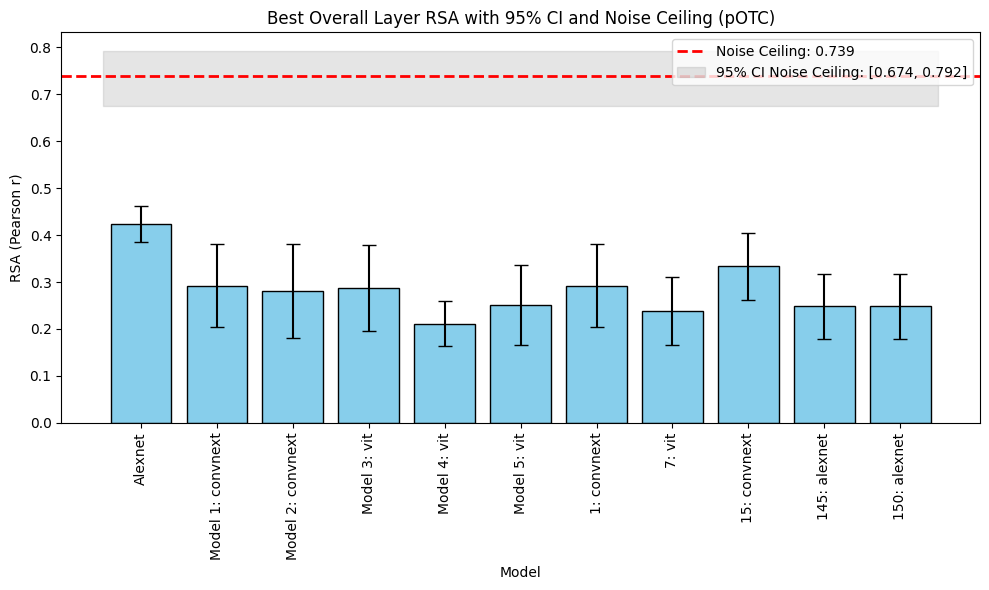

In [38]:


# Suppose you have intermediate results saved for several models.
# For example, let’s say you have these files:
filepaths = [
     "Stats_intermediate_Alexnet/pOTC_Alexnet_intermediates.csv",
    "Stats_pOTC_Top_5_models/pOTC_Model 1: convnext_large_mlp_intermediates.csv",
    "Stats_pOTC_Top_5_models/pOTC_Model 2: convnext_xlarge_intermediates.csv",
    "Stats_pOTC_Top_5_models/pOTC_Model 3: vit_base_patch16_clip_224_intermediates.csv",
    "Stats_pOTC_Top_5_models/pOTC_Model 4: vit_large_patch_14_clip:laion2b_ft_in1k_intermediates.csv",
    "Stats_pOTC_Top_5_models/pOTC_Model 5: vit_large_patch_14_clip: openai_ft_in1k_intermediates.csv",
    
    #top neural avg
    "Stats_pOTC_Top_Avg_Vision/pOTC_1: convnext_large_mlp_intermediates.csv",
    "Stats_pOTC_Top_Avg_Vision/pOTC_7: vit_relpos_base_patch16_intermediates.csv",
    "Stats_pOTC_Top_Avg_Vision/pOTC_15: convnext_tiny_imagenet_full_intermediates.csv",
    "Stats_pOTC_Top_Avg_Vision/pOTC_145: alexnet_training_seed_01_intermediates.csv",
    "Stats_pOTC_Top_Avg_Vision/pOTC_150: alexnet_training_seed_10_intermediates.csv"
   

    # Add more file paths as needed.
]

# Read all summaries and add a column for the model name.
summaries = []
for fp in filepaths:
    df = read_summary_csv(fp)
    # Extract model name from the filename, for example.
    model_name = os.path.basename(fp).split("_")[1]
    df["model"] = model_name
    summaries.append(df)

# Combine all summaries into one DataFrame.
all_summaries = pd.concat(summaries, ignore_index=True)

# We assume that the summary DataFrame has at least these columns:
#   "group1_mean_corr" (the best RSA from group1),
#   "confidence_interval" (a tuple saved as a string, e.g. "(0.55, 0.65)"),
#   "best_layer_mode" (the best layer identifier)
#   "model" (we added this from filename)

# Convert the confidence_interval string to a tuple and then compute error bars.
def parse_ci(ci_str):
    # Use ast.literal_eval to safely parse the string into a tuple
    try:
        return ast.literal_eval(ci_str)
    except Exception as e:
        print(f"Error parsing confidence_interval: {ci_str} -- {e}")
        return (np.nan, np.nan)

all_summaries["ci"] = all_summaries["confidence_interval"].apply(parse_ci)
all_summaries["ci_lower"] = all_summaries["ci"].apply(lambda x: x[0])
all_summaries["ci_upper"] = all_summaries["ci"].apply(lambda x: x[1])
# Calculate the error bars (assuming symmetric errors around the mean)
all_summaries["error"] = (all_summaries["ci_upper"] - all_summaries["ci_lower"]) / 2

# # Plotting: Bar plot of group1_mean_corr for each model with error bars.
# plt.figure(figsize=(8, 6))
# x = np.arange(len(all_summaries))
# plt.bar(x, all_summaries["group1_mean_corr"], yerr=all_summaries["error"], capsize=5)
# plt.xticks(x, all_summaries["model"], rotation= 90)
# plt.xlabel("Model")
# plt.ylabel("Group1 Mean RSA (Pearson r)")
# plt.title("Best Overall Layer RSA with 95% Confidence Intervals")
# plt.tight_layout()
# plt.show()

# --- Compute the noise ceiling for the ROI (e.g., EarlyV) ---
# Assume you have your EarlyV RDMs loaded and converted to a NumPy array:

import pickle
import numpy as np

# Load the EarlyV RDMs (assumed to be a list of (72,72) arrays for each subject)
with open('reliable_roi_rdms/pOTC_reliable_rdms.pkl', 'rb') as file:
    pOTC_rdms = pickle.load(file)
# Convert list to a 3D NumPy array
pOTC_rdms_array = np.stack(pOTC_rdms)  # shape: (N, 72, 72)

# Compute noise ceiling using our previously defined function:
noise_results = compute_noise_ceiling(pOTC_rdms_array, num_splits=None)
noise_ceiling = noise_results["noise_ceiling"]
noise_ci_lower, noise_ci_upper = noise_results["ci"]

# --- Plotting: Bar plot of group1_mean_corr for each model with noise ceiling ---
plt.figure(figsize=(10, 6))
x = np.arange(len(all_summaries))
plt.bar(x, all_summaries["group1_mean_corr"], yerr=all_summaries["error"], capsize=5, color='skyblue', edgecolor='k')

# Add a horizontal line for the noise ceiling.
plt.axhline(noise_ceiling, color='red', linestyle='--', linewidth=2, label=f"Noise Ceiling: {noise_ceiling:.3f}")
# Fill the 95% CI for the noise ceiling.
plt.fill_between([-0.5, len(all_summaries)-0.5], noise_ci_lower, noise_ci_upper, color='grey', alpha=0.2, 
                 label=f"95% CI Noise Ceiling: [{noise_ci_lower:.3f}, {noise_ci_upper:.3f}]")

plt.xticks(x, all_summaries["model"], rotation=90)
plt.xlabel("Model")
plt.ylabel("RSA (Pearson r)")
plt.title("Best Overall Layer RSA with 95% CI and Noise Ceiling (pOTC)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# updated pOTC bar plot!

In [9]:

# Load the EarlyV RDMs (assumed to be a list of (72,72) arrays for each subject)
with open('reliable_roi_rdms/pOTC_reliable_rdms.pkl', 'rb') as file:
    pOTC_rdms = pickle.load(file)
    
# Convert list to a 3D NumPy array
pOTC_rdms_array = np.stack(pOTC_rdms) 

Comparing alexnet_pytorch vs. 145: alexnet_training_seed_01, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 150: alexnet_training_seed_10, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 15: convnext_tiny_imagenet_full, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 7: vit_relpos_base_patch16, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 1: convnext_large_mlp, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 2:convnext_xlarge, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 69: efficientnet_b2_imagenet_full, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 39: cvt_cvt-21-384-in1k_4_LucyV4, one-sided p-value = 0.0001
Comparing alexnet_pytorch vs. dinov2, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. dino_large, one-sided p-value = 0.0000


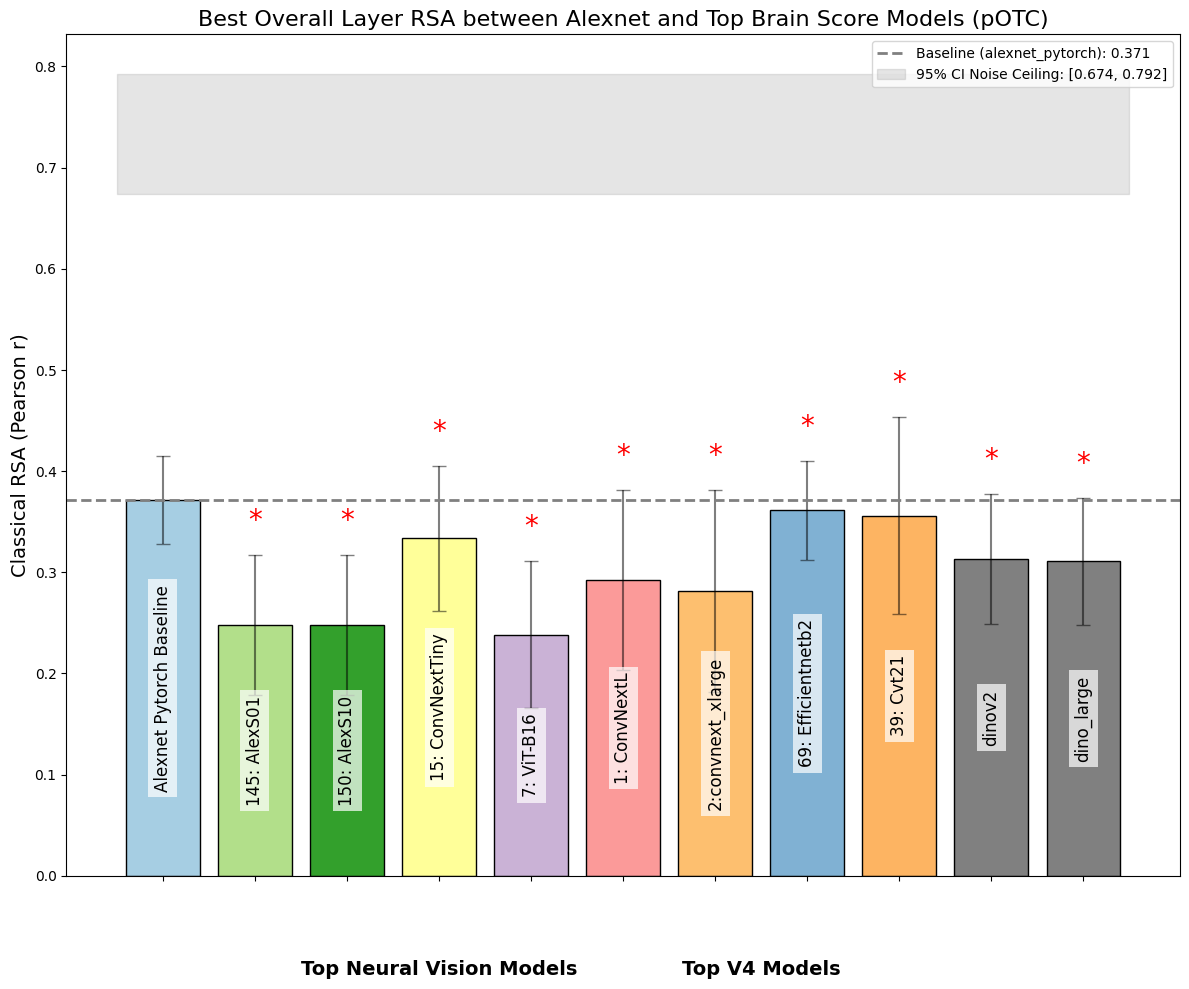

In [11]:
# Best bar plot so far!

# Load the EarlyV RDMs (assumed to be a list of (72,72) arrays for each subject)
with open('reliable_roi_rdms/pOTC_reliable_rdms.pkl', 'rb') as file:
    pOTC_rdms = pickle.load(file)
    
# Convert list to a 3D NumPy array
pOTC_rdms_array = np.stack(pOTC_rdms) 

filepaths = [
    #"Stats_intermediate_Alexnet/pOTC_Alexnet_intermediates.csv",
    "Stats_additional_models/pOTC_alexnet_pytorch_intermediates.csv",
    
    # Top Neural (average)
    "Stats_pOTC_Top_Avg_Vision/pOTC_145: alexnet_training_seed_01_intermediates.csv",
    "Stats_pOTC_Top_Avg_Vision/pOTC_150: alexnet_training_seed_10_intermediates.csv",
    "Stats_pOTC_Top_Avg_Vision/pOTC_15: convnext_tiny_imagenet_full_intermediates.csv",
    "Stats_pOTC_Top_Avg_Vision/pOTC_7: vit_relpos_base_patch16_intermediates.csv",
    "Stats_pOTC_Top_Avg_Vision/pOTC_1: convnext_large_mlp_intermediates.csv",
    
    # Top V4
    "Stats_pOTC_Top_V4/pOTC_2:convnext_xlarge_intermediates.csv",
    "Stats_pOTC_Top_V4/pOTC_69: efficientnet_b2_imagenet_full_intermediates.csv",
    "Stats_pOTC_Top_V4/pOTC_39: cvt_cvt-21-384-in1k_4_LucyV4_intermediates.csv",

    #"Stats_additional_models/pOTC_alexnet_pytorch_intermediates.csv",
    "Stats_additional_models/pOTC_dino_small_intermediates.csv",
    "Stats_additional_models/pOTC_dino_large_intermediates.csv"
]

# --- Read Data with Order Preserved ---
summaries = []
intermediates_data = {}

for order, fp in enumerate(filepaths):
    summary_df = read_summary_csv(fp)
    base = os.path.basename(fp)
    no_ext = os.path.splitext(base)[0]
    parts = no_ext.split("_", 1)
    model_name_clean = parts[1].replace("_intermediates", "")
    summary_df["model"] = model_name_clean
    summary_df["order"] = order
    summaries.append(summary_df)

    inter_df = read_intermediate_data(fp)
    intermediates_data[model_name_clean] = inter_df

all_summaries = pd.concat(summaries, ignore_index=True)
all_summaries = all_summaries.sort_values("order")


# saving data to CSV
#all_summaries.to_csv("pOTC_torch_plot.csv", index = False)

# Process confidence intervals
all_summaries["ci"] = all_summaries["confidence_interval"].apply(parse_ci)
all_summaries["ci_lower"] = all_summaries["ci"].apply(lambda x: x[0])
all_summaries["ci_upper"] = all_summaries["ci"].apply(lambda x: x[1])
all_summaries["error"] = (all_summaries["ci_upper"] - all_summaries["ci_lower"]) / 2

# Assign group and color
all_summaries[["group", "color"]] = all_summaries["model"].apply(lambda m: pd.Series(get_group_color(m)))

# Baseline
baseline = "alexnet_pytorch"
if baseline not in all_summaries["model"].unique():
    raise ValueError("Baseline not found in data!")
baseline_data = intermediates_data[baseline]
baseline_corrs = baseline_data["group1_corr"].values

# One-sided test: baseline > other model
significance = {}
for model, inter_df in intermediates_data.items():
    if model == baseline:
        continue
    model_corrs = inter_df["group1_corr"].values
    if len(baseline_corrs) == len(model_corrs):
        t_stat, p_val_two_sided = ttest_rel(baseline_corrs, model_corrs)
        if t_stat > 0:
            p_val_one_sided = p_val_two_sided / 2
        else:
            p_val_one_sided = 1 - (p_val_two_sided / 2)
        significance[model] = p_val_one_sided
        print(f"Comparing {baseline} vs. {model}, one-sided p-value = {p_val_one_sided:.4f}")
    else:
        significance[model] = np.nan

# Short names
model_short_names = {
    #'Alexnet': "Alexnet Baseline",
    'alexnet_pytorch': "Alexnet Pytorch Baseline",
    "1: convnext_large_mlp": "ConvNextL",
    "7: vit_relpos_base_patch16": "ViT-B16",
    "15: convnext_tiny_imagenet_full": "ConvNextTiny",
    "145: alexnet_training_seed_01": "AlexS01",
    "150: alexnet_training_seed_10": "AlexS10",
    "2: convnext_xlarge": "ConvNextXL",
    "69: efficientnet_b2_imagenet_full": "Efficientnetb2",
    "39: cvt_cvt-21-384-in1k_4_LucyV4": "Cvt21"
   
}

# Plot
plt.figure(figsize=(12, 10))
x = np.arange(len(all_summaries))
bar_colors = all_summaries["color"].tolist()

bars = plt.bar(x, all_summaries["group1_mean_corr"],
               color=bar_colors, edgecolor='k')
# Then use plt.errorbar to draw error bars manually:
plt.errorbar(x, all_summaries["group1_mean_corr"],
             yerr=all_summaries["error"],
             fmt='none', ecolor='black', alpha=0.5, capsize=5)
# plt.bar(
#     x, 
#     all_summaries["group1_mean_corr"], 
#     yerr=all_summaries["error"],
#     capsize=5, 
#     color=bar_colors, 
#     edgecolor='k'
# )

# Baseline line
baseline_mean = all_summaries.loc[all_summaries["model"] == baseline, "group1_mean_corr"].iloc[0]
plt.axhline(
    baseline_mean, 
    color='grey', 
    linestyle='--', 
    linewidth=2,
    label=f"Baseline ({baseline}): {baseline_mean:.3f}"
)

# Hide x-axis labels
plt.xticks(x, [""] * len(x))

# Place short names inside bars
for i, row in all_summaries.iterrows():
    model = row["model"]
    short_name = model_short_names.get(model, model)
    bar_height = row["group1_mean_corr"]
    if bar_height > 0:
        y_pos = bar_height / 2
        text_color = "black"
    else:
        y_pos = bar_height - 0.02
        text_color = "black"
    plt.text(
        x[i], y_pos, 
        short_name, 
        ha='center', va='center', 
        color=text_color, 
        rotation=90,
        fontsize =12,
        bbox =dict(facecolor='white', alpha=0.7, edgecolor='none')
    )

# Add stars if p < 0.05 (one-sided)
for i, row in all_summaries.iterrows():
    model = row["model"]
    if model == baseline:
        continue
    p_val = significance.get(model, np.nan)
    if not np.isnan(p_val) and p_val < 0.05:
        y_val = row["group1_mean_corr"] + row["error"] + 0.02
        plt.text(x[i], y_val, "*", ha='center', va='bottom', color='red', fontsize=20)


# --- Plotting Group Labels ---

# Since baseline is at index 0, we take indices 1 to 5 for Top Neural Vision
neural_indices = np.arange(1, 6)  # indices 1,2,3,4,5
if len(neural_indices) > 0:
    neural_mid = neural_indices.mean()  # midpoint of neural indices
    plt.text(neural_mid, -0.1, "Top Neural Vision Models",
             ha='center', va='top', fontsize=14, fontweight='bold',
             transform=plt.gca().get_xaxis_transform())

# Then indices 6 to 10 for Top V1 Models
v4_indices = np.arange(6, 8)  # indices 6,7,8,9,10
if len(v4_indices) > 0:
    v4_mid = v4_indices.mean()  # midpoint of V1 indices
    plt.text(v4_mid, -0.1, "Top V4 Models",
             ha='center', va='top', fontsize=14, fontweight='bold',
             transform=plt.gca().get_xaxis_transform())

# computing noise_ceiling
noise_results = compute_noise_ceiling(pOTC_rdms_array, num_splits=None)
noise_ceiling = noise_results["noise_ceiling"]
noise_ci_lower, noise_ci_upper = noise_results["ci"]
# plt.axhline(noise_ceiling, color='black', linestyle='--', linewidth=2, label=f"Noise Ceiling: {noise_ceiling:.3f}")
# plt.fill_between([-0.5, len(all_summaries)-0.5], noise_ci_lower, noise_ci_upper,
#                  color='grey', alpha=0.2, label=f"95% CI Noise Ceiling: [{noise_ci_lower:.3f}, {noise_ci_upper:.3f}]")

plt.tight_layout()

# plt.axhline(
#     noise_ceiling, 
#     color='black', 
#     linestyle='--', 
#     linewidth=2,
#     label=f"Noise Ceiling: {noise_ceiling:.3f}"
# )
plt.fill_between(
    [-0.5, len(all_summaries)-0.5], 
    noise_ci_lower, 
    noise_ci_upper, 
    color='grey', alpha=0.2, 
    label=f"95% CI Noise Ceiling: [{noise_ci_lower:.3f}, {noise_ci_upper:.3f}]"
)

plt.xticks(fontsize=14)
plt.ylabel("Classical RSA (Pearson r)", fontsize=14)
plt.title("Best Overall Layer RSA between Alexnet and Top Brain Score Models (pOTC)", fontsize=16)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


In [14]:
# opening csv file
import pandas as pd
loaded_data = pd.read_csv("pOTC_graph_data.csv")
print(loaded_data.head())


   group1_mean_corr  group2_mean_corr    t_stat     p_val  \
0          0.424278          0.437281 -4.286688  0.000036   
1          0.247964          0.255777 -1.378652  0.170464   
2          0.247964          0.255777 -1.378652  0.170464   
3          0.333479          0.304314  4.357184  0.000027   
4          0.238311          0.237166  0.200651  0.841297   

                          confidence_interval  \
0   (0.3850024090026359, 0.46238078763982376)   
1  (0.17769478040951106, 0.31631803550071197)   
2  (0.17769478040951106, 0.31631803550071197)   
3    (0.2603190344589254, 0.4037581226103312)   
4  (0.16448872623534808, 0.31011597669747304)   

                           best_layer_mode  total_splits_used  \
0  model.base_arch.backbone.conv_block_5.3                126   
1                             classifier.1                126   
2                             classifier.1                126   
3                               features.6                126   
4            

# aOTC region

In [5]:
import os
import torch
import pickle
import numpy as np
import pandas as pd

# Load reliable ROI RDMs.
with open('reliable_roi_rdms/aOTC_reliable_rdms.pkl', 'rb') as file:
    aOTC_rdms = pickle.load(file)
aOTC_rdms_array = np.stack(aOTC_rdms)
rdms = {"aOTC": aOTC_rdms_array}

# List of models to run.
# models_to_run = [
#     ("128: ReAlnet01_cornet", "model_128_activations_regions.pt"),
#     ("134: ReAlnet03_cornet", "model_134_activations_regions.pt"),
#     ("123: ReAlnet07_cornet", "model_123_activations_regions.pt"),
#     ("115: ReAlnet10_cornet:laion2b_ft_in1k", "model_115_activations_regions.pt"),
#     ("118: ReAlnet08_cornet: openai_ft_in1k", "model_118_activations_regions.pt"),
# ]
models_to_run = [
    ("dino_large", "dino_large_block_activations.pt")

]
# Specify brain region.
brain_region = "aOTC"

# Create folder for intermediate results if it doesn't exist.
save_dir = "./Stats_additional_models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

all_model_summaries = []

for model_name, act_file in models_to_run:
    # Load activation data from the .pt file.
    loaded_data = torch.load(act_file, weights_only = False)
    
    # Convert every tensor to a NumPy array.
    model_activation_data = {}
    for key, value in loaded_data.items():
        if isinstance(value, torch.Tensor):
            model_activation_data[key] = value.detach().cpu().numpy()
        else:
            model_activation_data[key] = value

    # Now run RSA validation (the conversion loop inside the function will handle further reshaping).
    summary, g1_corrs, g2_corrs = run_classical_rsa_validation(
        rdms,
        model_activation_data,
        brain_region,
        model_name,
        num_splits=None,
        save_intermediates_path=save_dir
    )

    print(f"Model {model_name} summary:")
    print(summary)
    all_model_summaries.append(summary)


Intermediate results saved to ./Stats_additional_models/aOTC_dino_large_intermediates.csv
Intermediate results saved to ./Stats_additional_models/aOTC_dino_large_intermediates.csv
Model dino_large summary:
{'group1_mean_corr': 0.20342968902903566, 'group2_mean_corr': 0.19052327667749439, 't_stat': 5.466003599790604, 'p_val': 2.394961874728413e-07, 'confidence_interval': (0.18021483488173026, 0.22645585143336266), 'best_layer_mode': 'blocks.22', 'total_splits_used': 126}


In [35]:
import os
import torch
import pickle
import numpy as np
import pandas as pd

# Load reliable ROI RDMs.
with open('reliable_roi_rdms/aOTC_reliable_rdms.pkl', 'rb') as file:
    aOTC_rdms = pickle.load(file)
aOTC_rdms_array = np.stack(aOTC_rdms)
rdms = {"aOTC": aOTC_rdms_array}

# List of models to run.
models_to_run = [
    ("145: alexnet_training_seed_01", "model_145_features_classifiers_activations.pt"),
    ("150: alexnet_training_seed_10", "model_150_features_classifiers_activations.pt"),
    ("15: convnext_tiny_imagenet_full", "model_15_activation_features.pt"),
    ("7: vit_relpos_base_patch16", "Model_7_activations_block.pt"),
    ("1: convnext_large_mlp", "model_1_activations_stages.pt"),
]

# Specify brain region.
brain_region = "aOTC"

# Create folder for intermediate results if it doesn't exist.
save_dir = "./Stats_aOTC_Top_Avg_Vision"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

all_model_summaries = []

for model_name, act_file in models_to_run:
    # Load activation data from the .pt file.
    loaded_data = torch.load(act_file)
    
    # Convert every tensor to a NumPy array.
    model_activation_data = {}
    for key, value in loaded_data.items():
        if isinstance(value, torch.Tensor):
            model_activation_data[key] = value.detach().cpu().numpy()
        else:
            model_activation_data[key] = value

    # Now run RSA validation (the conversion loop inside the function will handle further reshaping).
    summary, g1_corrs, g2_corrs = run_classical_rsa_validation(
        rdms,
        model_activation_data,
        brain_region,
        model_name,
        num_splits=None,
        save_intermediates_path=save_dir
    )

    print(f"Model {model_name} summary:")
    print(summary)
    all_model_summaries.append(summary)


Intermediate results saved to ./Stats_aOTC_Top_Avg_Vision/aOTC_145: alexnet_training_seed_01_intermediates.csv
Intermediate results saved to ./Stats_aOTC_Top_Avg_Vision/aOTC_145: alexnet_training_seed_01_intermediates.csv
Model 145: alexnet_training_seed_01 summary:
{'group1_mean_corr': 0.15107558393496182, 'group2_mean_corr': 0.12735910586982466, 't_stat': 4.08417899292682, 'p_val': 7.843013797487734e-05, 'confidence_interval': (0.08490184409366275, 0.21623764195141792), 'best_layer_mode': 'classifier.6', 'total_splits_used': 126}


Intermediate results saved to ./Stats_aOTC_Top_Avg_Vision/aOTC_150: alexnet_training_seed_10_intermediates.csv
Intermediate results saved to ./Stats_aOTC_Top_Avg_Vision/aOTC_150: alexnet_training_seed_10_intermediates.csv
Model 150: alexnet_training_seed_10 summary:
{'group1_mean_corr': 0.15107558393496182, 'group2_mean_corr': 0.12735910586982466, 't_stat': 4.08417899292682, 'p_val': 7.843013797487734e-05, 'confidence_interval': (0.08490184409366275, 0.21623764195141792), 'best_layer_mode': 'classifier.6', 'total_splits_used': 126}


Intermediate results saved to ./Stats_aOTC_Top_Avg_Vision/aOTC_15: convnext_tiny_imagenet_full_intermediates.csv
Intermediate results saved to ./Stats_aOTC_Top_Avg_Vision/aOTC_15: convnext_tiny_imagenet_full_intermediates.csv
Model 15: convnext_tiny_imagenet_full summary:
{'group1_mean_corr': 0.160245478100288, 'group2_mean_corr': 0.11456482896290957, 't_stat': 8.202534762778486, 'p_val': 2.428111973281235e-13, 'confidence_interval': (0.10748031182298426, 0.21231780623389804), 'best_layer_mode': 'features.2', 'total_splits_used': 126}


Intermediate results saved to ./Stats_aOTC_Top_Avg_Vision/aOTC_7: vit_relpos_base_patch16_intermediates.csv
Intermediate results saved to ./Stats_aOTC_Top_Avg_Vision/aOTC_7: vit_relpos_base_patch16_intermediates.csv
Model 7: vit_relpos_base_patch16 summary:
{'group1_mean_corr': 0.18013921636916652, 'group2_mean_corr': 0.15690957364591498, 't_stat': 4.701622520658914, 'p_val': 6.710014187995309e-06, 'confidence_interval': (0.11964811783132662, 0.2396125596572688), 'best_layer_mode': 'blocks.0', 'total_splits_used': 126}


Intermediate results saved to ./Stats_aOTC_Top_Avg_Vision/aOTC_1: convnext_large_mlp_intermediates.csv
Intermediate results saved to ./Stats_aOTC_Top_Avg_Vision/aOTC_1: convnext_large_mlp_intermediates.csv
Model 1: convnext_large_mlp summary:
{'group1_mean_corr': 0.1287019394903676, 'group2_mean_corr': 0.10406615523059007, 't_stat': 5.264806918533519, 'p_val': 5.924054349244542e-07, 'confidence_interval': (0.07134249762524061, 0.18541718516684852), 'best_layer_mode': 'stem', 'total_splits_used': 126}


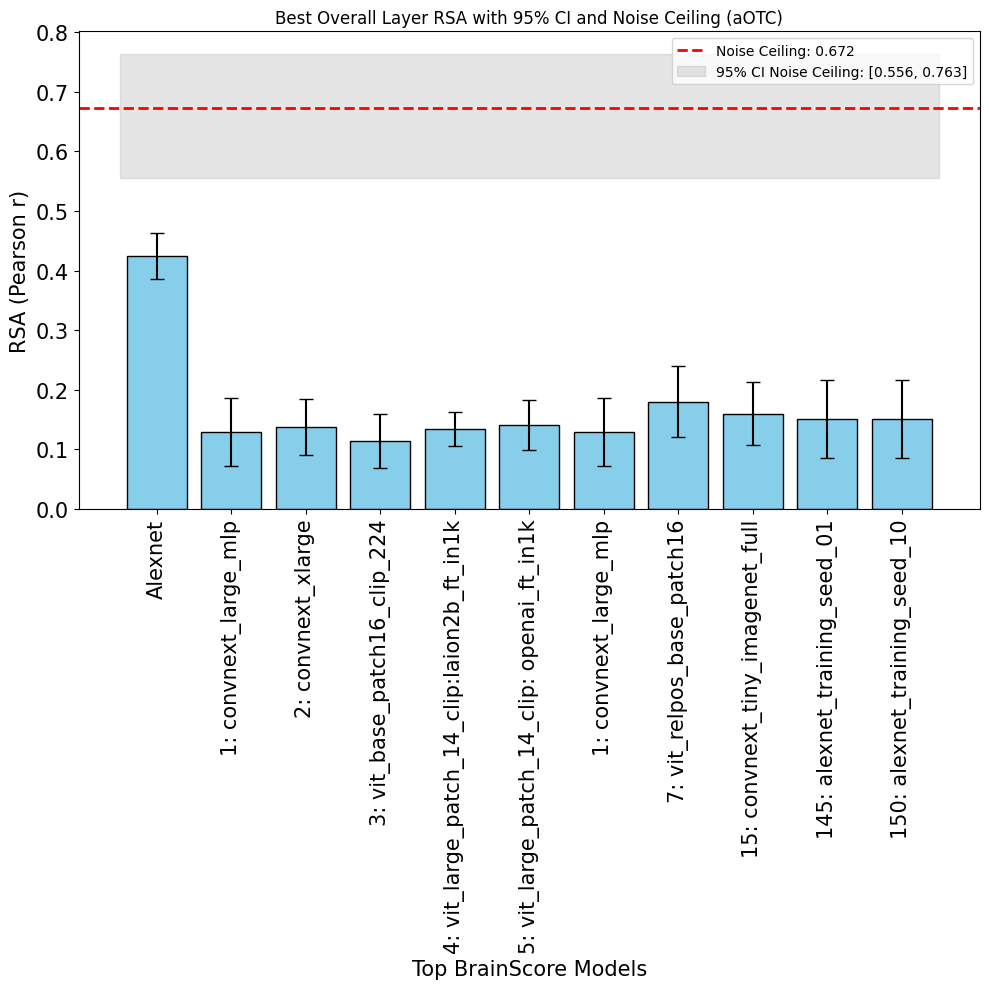

In [13]:


# Suppose you have intermediate results saved for several models.
# For example, let’s say you have these files:
filepaths = [
     "Stats_intermediate_Alexnet/aOTC_Alexnet_intermediates.csv",
    "Stats_aOTC_Top_5_models/aOTC_1: convnext_large_mlp_intermediates.csv",
    "Stats_aOTC_Top_5_models/aOTC_2: convnext_xlarge_intermediates.csv",
    "Stats_aOTC_Top_5_models/aOTC_3: vit_base_patch16_clip_224_intermediates.csv",
    "Stats_aOTC_Top_5_models/aOTC_4: vit_large_patch_14_clip:laion2b_ft_in1k_intermediates.csv",
    "Stats_aOTC_Top_5_models/aOTC_5: vit_large_patch_14_clip: openai_ft_in1k_intermediates.csv",
    
    #top neural avg
    "Stats_aOTC_Top_Avg_Vision/aOTC_1: convnext_large_mlp_intermediates.csv",
    "Stats_aOTC_Top_Avg_Vision/aOTC_7: vit_relpos_base_patch16_intermediates.csv",
    "Stats_aOTC_Top_Avg_Vision/aOTC_15: convnext_tiny_imagenet_full_intermediates.csv",
    "Stats_aOTC_Top_Avg_Vision/aOTC_145: alexnet_training_seed_01_intermediates.csv",
    "Stats_aOTC_Top_Avg_Vision/aOTC_150: alexnet_training_seed_10_intermediates.csv"
   

    # Add more file paths as needed.
]

# Read all summaries and add a column for the model name.
summaries = []
for fp in filepaths:
    df = read_summary_csv(fp)
    # cleaning up the model name
    base = os.path.basename(fp)
    no_ext = os.path.splitext(base)[0]
    region_and_model = no_ext.split("_", 1)
    model_name_clean = region_and_model[1].replace("_intermediates", "")
    df["model"] = model_name_clean
    summaries.append(df)
    
    # # Extract model name from the filename, for example.
    # model_name = os.path.basename(fp).split("_")[1]
    # df["model"] = model_name
    # summaries.append(df)

# Combine all summaries into one DataFrame.
all_summaries = pd.concat(summaries, ignore_index=True)

# We assume that the summary DataFrame has at least these columns:
#   "group1_mean_corr" (the best RSA from group1),
#   "confidence_interval" (a tuple saved as a string, e.g. "(0.55, 0.65)"),
#   "best_layer_mode" (the best layer identifier)
#   "model" (we added this from filename)

# Convert the confidence_interval string to a tuple and then compute error bars.
def parse_ci(ci_str):
    # Use ast.literal_eval to safely parse the string into a tuple
    try:
        return ast.literal_eval(ci_str)
    except Exception as e:
        print(f"Error parsing confidence_interval: {ci_str} -- {e}")
        return (np.nan, np.nan)

all_summaries["ci"] = all_summaries["confidence_interval"].apply(parse_ci)
all_summaries["ci_lower"] = all_summaries["ci"].apply(lambda x: x[0])
all_summaries["ci_upper"] = all_summaries["ci"].apply(lambda x: x[1])
# Calculate the error bars (assuming symmetric errors around the mean)
all_summaries["error"] = (all_summaries["ci_upper"] - all_summaries["ci_lower"]) / 2

# # Plotting: Bar plot of group1_mean_corr for each model with error bars.
# plt.figure(figsize=(8, 6))
# x = np.arange(len(all_summaries))
# plt.bar(x, all_summaries["group1_mean_corr"], yerr=all_summaries["error"], capsize=5)
# plt.xticks(x, all_summaries["model"], rotation= 90)
# plt.xlabel("Model")
# plt.ylabel("Group1 Mean RSA (Pearson r)")
# plt.title("Best Overall Layer RSA with 95% Confidence Intervals")
# plt.tight_layout()
# plt.show()

# --- Compute the noise ceiling for the ROI (e.g., EarlyV) ---
# Assume you have your EarlyV RDMs loaded and converted to a NumPy array:

import pickle
import numpy as np

# Load the EarlyV RDMs (assumed to be a list of (72,72) arrays for each subject)
with open('reliable_roi_rdms/aOTC_reliable_rdms.pkl', 'rb') as file:
    aOTC_rdms = pickle.load(file)
# Convert list to a 3D NumPy array
aOTC_rdms_array = np.stack(aOTC_rdms)  # shape: (N, 72, 72)

# Compute noise ceiling using our previously defined function:
noise_results = compute_noise_ceiling(aOTC_rdms_array, num_splits=None)
noise_ceiling = noise_results["noise_ceiling"]
noise_ci_lower, noise_ci_upper = noise_results["ci"]

# --- Plotting: Bar plot of group1_mean_corr for each model with noise ceiling ---
plt.figure(figsize=(10, 10))
x = np.arange(len(all_summaries))
plt.bar(x, all_summaries["group1_mean_corr"], yerr=all_summaries["error"], capsize=5, color='skyblue', edgecolor='k')

# Add a horizontal line for the noise ceiling.
plt.axhline(noise_ceiling, color='red', linestyle='--', linewidth=2, label=f"Noise Ceiling: {noise_ceiling:.3f}")
# Fill the 95% CI for the noise ceiling.
plt.fill_between([-0.5, len(all_summaries)-0.5], noise_ci_lower, noise_ci_upper, color='grey', alpha=0.2, 
                 label=f"95% CI Noise Ceiling: [{noise_ci_lower:.3f}, {noise_ci_upper:.3f}]")

plt.xticks(x, all_summaries["model"], rotation=90, fontsize = 15)
plt.xlabel("Top BrainScore Models", fontsize = 15)
plt.ylabel("RSA (Pearson r)", fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Best Overall Layer RSA with 95% CI and Noise Ceiling (aOTC)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# updated aOTC bar plot!

Comparing alexnet_pytorch vs. 145: alexnet_training_seed_01, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 150: alexnet_training_seed_10, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 15: convnext_tiny_imagenet_full, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 7: vit_relpos_base_patch16, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 1: convnext_large_mlp, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 128: ReAlnet01_cornet, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 134: ReAlnet03_cornet, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 123: ReAlnet07_cornet, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 115: ReAlnet10_cornet:laion2b_ft_in1k, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 118: ReAlnet08_cornet: openai_ft_in1k, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. dinov2, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. dino_large, one-sided p-value = 0.0000


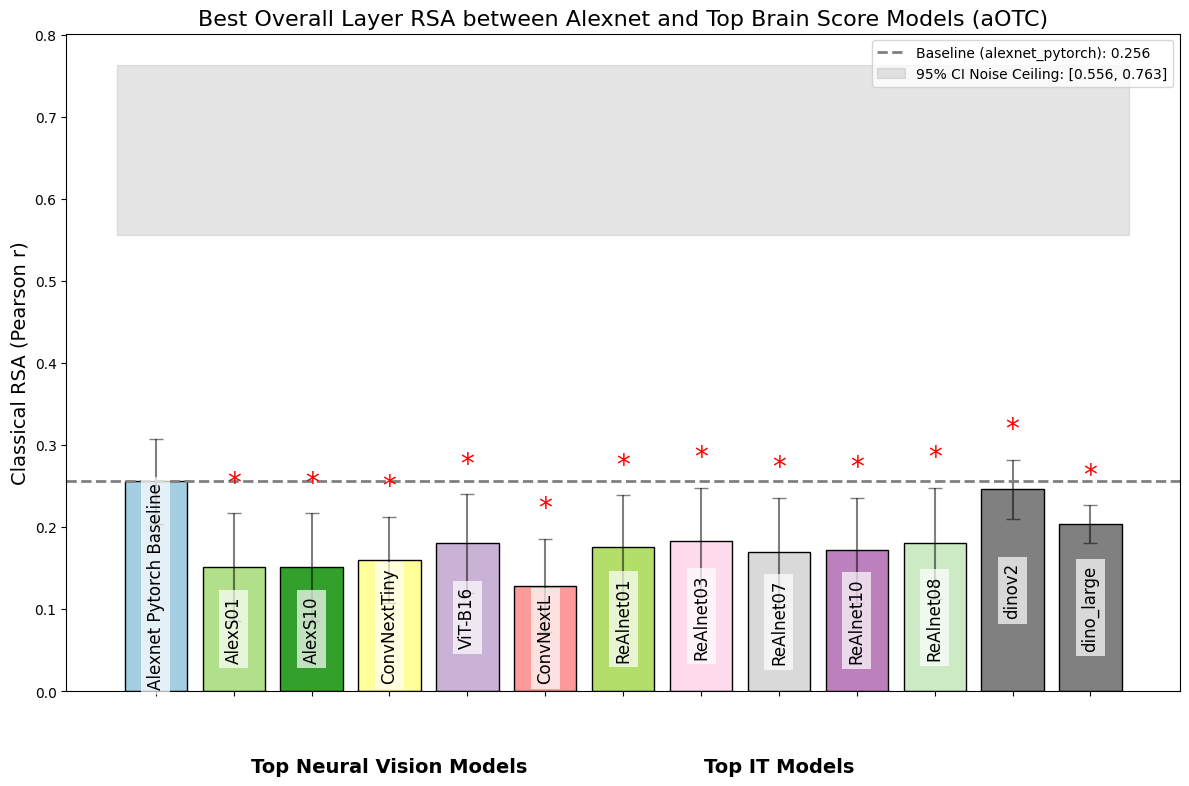

In [15]:
# Best bar plot so far!

# Load reliable ROI RDMs.
with open('reliable_roi_rdms/aOTC_reliable_rdms.pkl', 'rb') as file:
    aOTC_rdms = pickle.load(file)
aOTC_rdms_array = np.stack(aOTC_rdms)
rdms = {"aOTC": aOTC_rdms_array}

filepaths = [
   # "Stats_intermediate_Alexnet/aOTC_Alexnet_intermediates.csv",
    "Stats_additional_models/aOTC_alexnet_pytorch_intermediates.csv",
    # Top Neural (average)
    "Stats_aOTC_Top_Avg_Vision/aOTC_145: alexnet_training_seed_01_intermediates.csv",
    "Stats_aOTC_Top_Avg_Vision/aOTC_150: alexnet_training_seed_10_intermediates.csv",
    "Stats_aOTC_Top_Avg_Vision/aOTC_15: convnext_tiny_imagenet_full_intermediates.csv",
    "Stats_aOTC_Top_Avg_Vision/aOTC_7: vit_relpos_base_patch16_intermediates.csv",
    "Stats_aOTC_Top_Avg_Vision/aOTC_1: convnext_large_mlp_intermediates.csv",
    
    # Top IT
    "Stats_aOTC_Top_IT/aOTC_128: ReAlnet01_cornet_intermediates.csv",
    "Stats_aOTC_Top_IT/aOTC_134: ReAlnet03_cornet_intermediates.csv",
    "Stats_aOTC_Top_IT/aOTC_123: ReAlnet07_cornet_intermediates.csv",
    "Stats_aOTC_Top_IT/aOTC_115: ReAlnet10_cornet:laion2b_ft_in1k_intermediates.csv",
    "Stats_aOTC_Top_IT/aOTC_118: ReAlnet08_cornet: openai_ft_in1k_intermediates.csv",


    "Stats_additional_models/aOTC_dino_small_intermediates.csv",
    "Stats_additional_models/aOTC_dino_large_intermediates.csv"
]

# --- Read Data with Order Preserved ---
summaries = []
intermediates_data = {}

for order, fp in enumerate(filepaths):
    summary_df = read_summary_csv(fp)
    base = os.path.basename(fp)
    no_ext = os.path.splitext(base)[0]
    parts = no_ext.split("_", 1)
    model_name_clean = parts[1].replace("_intermediates", "")
    summary_df["model"] = model_name_clean
    summary_df["order"] = order
    summaries.append(summary_df)

    inter_df = read_intermediate_data(fp)
    intermediates_data[model_name_clean] = inter_df

all_summaries = pd.concat(summaries, ignore_index=True)
all_summaries = all_summaries.sort_values("order")

# Save data to CSV
#all_summaries.to_csv("aOTC_torch_plot.csv", index=False)

# Process confidence intervals
all_summaries["ci"] = all_summaries["confidence_interval"].apply(parse_ci)
all_summaries["ci_lower"] = all_summaries["ci"].apply(lambda x: x[0])
all_summaries["ci_upper"] = all_summaries["ci"].apply(lambda x: x[1])
all_summaries["error"] = (all_summaries["ci_upper"] - all_summaries["ci_lower"]) / 2

# Assign group and color
all_summaries[["group", "color"]] = all_summaries["model"].apply(lambda m: pd.Series(get_group_color(m)))

# Baseline
baseline = "alexnet_pytorch"
if baseline not in all_summaries["model"].unique():
    raise ValueError("Baseline not found in data!")
baseline_data = intermediates_data[baseline]
baseline_corrs = baseline_data["group1_corr"].values

# One-sided test: baseline > other model
significance = {}
for model, inter_df in intermediates_data.items():
    if model == baseline:
        continue
    model_corrs = inter_df["group1_corr"].values
    if len(baseline_corrs) == len(model_corrs):
        t_stat, p_val_two_sided = ttest_rel(baseline_corrs, model_corrs)
        if t_stat > 0:
            p_val_one_sided = p_val_two_sided / 2
        else:
            p_val_one_sided = 1 - (p_val_two_sided / 2)
        significance[model] = p_val_one_sided
        print(f"Comparing {baseline} vs. {model}, one-sided p-value = {p_val_one_sided:.4f}")
    else:
        significance[model] = np.nan

# Short names
model_short_names = {
    #'Alexnet': "Alexnet Baseline",
    'alexnet_pytorch': "Alexnet Pytorch Baseline",
    "1: convnext_large_mlp": "ConvNextL",
    "7: vit_relpos_base_patch16": "ViT-B16",
    "15: convnext_tiny_imagenet_full": "ConvNextTiny",
    "145: alexnet_training_seed_01": "AlexS01",
    "150: alexnet_training_seed_10": "AlexS10",
    "128: ReAlnet01_cornet": "ReAlnet01",
    "134: ReAlnet03_cornet": "ReAlnet03",
    "123: ReAlnet07_cornet": "ReAlnet07",
    "115: ReAlnet10_cornet:laion2b_ft_in1k": "ReAlnet10",
    "118: ReAlnet08_cornet: openai_ft_in1k": "ReAlnet08",
    "aOTC_dinov2": "dino_small"
  
}

# Plot
plt.figure(figsize=(12, 8))
x = np.arange(len(all_summaries))
bar_colors = all_summaries["color"].tolist()

# plt.bar(
#     x, 
#     all_summaries["group1_mean_corr"], 
#     yerr=all_summaries["error"],
#     capsize=5, 
#     color=bar_colors, 
#     edgecolor='k'
# )
bars = plt.bar(x, all_summaries["group1_mean_corr"],
               color=bar_colors, edgecolor='k')
# Then use plt.errorbar to draw error bars manually:
plt.errorbar(x, all_summaries["group1_mean_corr"],
             yerr=all_summaries["error"],
             fmt='none', ecolor='black', alpha=0.5, capsize=5)


# Baseline line
baseline_mean = all_summaries.loc[all_summaries["model"] == baseline, "group1_mean_corr"].iloc[0]
plt.axhline(
    baseline_mean, 
    color='grey', 
    linestyle='--', 
    linewidth=2,
    label=f"Baseline ({baseline}): {baseline_mean:.3f}"
)

# Hide x-axis labels
plt.xticks(x, [""] * len(x))

# Place short names inside bars
for i, row in all_summaries.iterrows():
    model = row["model"]
    short_name = model_short_names.get(model, model)
    bar_height = row["group1_mean_corr"]
    if bar_height > 0:
        y_pos = bar_height / 2
        text_color = "black"
    else:
        y_pos = bar_height - 0.02
        text_color = "black"
    plt.text(
        x[i], y_pos, 
        short_name, 
        ha='center', va='center', 
        color=text_color,
        fontsize =12,
        rotation=90,
        bbox =dict(facecolor='white', alpha=0.7, edgecolor='none')
    )

# Add stars if p < 0.05 (one-sided)
for i, row in all_summaries.iterrows():
    model = row["model"]
    if model == baseline:
        continue
    p_val = significance.get(model, np.nan)
    if not np.isnan(p_val) and p_val < 0.05:
        y_val = row["group1_mean_corr"] + row["error"] + 0.02
        plt.text(x[i], y_val, "*", ha='center', va='bottom', color='red', fontsize=20)


# --- Plotting Group Labels ---

# Since baseline is at index 0, we take indices 1 to 5 for Top Neural Vision
neural_indices = np.arange(1, 6)  # indices 1,2,3,4,5
if len(neural_indices) > 0:
    neural_mid = neural_indices.mean()  # midpoint of neural indices
    plt.text(neural_mid, -0.1, "Top Neural Vision Models",
             ha='center', va='top', fontsize=14, fontweight='bold',
             transform=plt.gca().get_xaxis_transform())

# Then indices 6 to 10 for Top V1 Models
IT_indices = np.arange(6, 11)  # indices 6,7,8,9,10
if len(IT_indices) > 0:
    IT_mid = IT_indices.mean()  # midpoint of V1 indices
    plt.text(IT_mid, -0.1, "Top IT Models",
             ha='center', va='top', fontsize=14, fontweight='bold',
             transform=plt.gca().get_xaxis_transform())

# computing noise_ceiling
noise_results = compute_noise_ceiling(aOTC_rdms_array, num_splits=None)
noise_ceiling = noise_results["noise_ceiling"]
noise_ci_lower, noise_ci_upper = noise_results["ci"]
# plt.axhline(noise_ceiling, color='black', linestyle='--', linewidth=2, label=f"Noise Ceiling: {noise_ceiling:.3f}")
# plt.fill_between([-0.5, len(all_summaries)-0.5], noise_ci_lower, noise_ci_upper,
#                  color='grey', alpha=0.2, label=f"95% CI Noise Ceiling: [{noise_ci_lower:.3f}, {noise_ci_upper:.3f}]")

plt.tight_layout()

# plt.axhline(
#     noise_ceiling, 
#     color='black', 
#     linestyle='--', 
#     linewidth=2,
#     label=f"Noise Ceiling: {noise_ceiling:.3f}"
# )
plt.fill_between(
    [-0.5, len(all_summaries)-0.5], 
    noise_ci_lower, 
    noise_ci_upper, 
    color='grey', alpha=0.2, 
    label=f"95% CI Noise Ceiling: [{noise_ci_lower:.3f}, {noise_ci_upper:.3f}]"
)

plt.xticks(fontsize=14)
plt.ylabel("Classical RSA (Pearson r)", fontsize=14)
plt.title("Best Overall Layer RSA between Alexnet and Top Brain Score Models (aOTC)", fontsize=16)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


In [16]:
# loading csv file
import pandas as pd
loaded_data = pd.read_csv("aOTC_graph_data.csv")
print(loaded_data.head())


   group1_mean_corr  group2_mean_corr    t_stat         p_val  \
0          0.424278          0.437281 -4.286688  3.590046e-05   
1          0.151076          0.127359  4.084179  7.843014e-05   
2          0.151076          0.127359  4.084179  7.843014e-05   
3          0.160245          0.114565  8.202535  2.428112e-13   
4          0.180139          0.156910  4.701623  6.710014e-06   

                          confidence_interval  \
0   (0.3850024090026359, 0.46238078763982376)   
1  (0.08490184409366275, 0.21623764195141792)   
2  (0.08490184409366275, 0.21623764195141792)   
3  (0.10748031182298426, 0.21231780623389804)   
4   (0.11964811783132662, 0.2396125596572688)   

                           best_layer_mode  total_splits_used  \
0  model.base_arch.backbone.conv_block_5.3                126   
1                             classifier.6                126   
2                             classifier.6                126   
3                               features.2            

In [ ]:
# Loading csv file

# Refactoring bar graphs to have clear category

In [24]:
import os
import numpy as np
import pandas as pd

# Best bar plot so far!

import pickle
with open('reliable_roi_rdms/EarlyV_reliable_rdms.pkl', 'rb') as file:
    EarlyV_rdms = pickle.load(file)
EarlyV_rdms_array = np.stack(EarlyV_rdms)

filepaths = [
    #"Stats_intermediate_Alexnet/EarlyV_Alexnet_intermediates.csv",
    "Stats_additional_models/EarlyV_alexnet_pytorch_intermediates.csv",

    # Top Neural (average)
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_145: alexnet_training_seed_01_intermediates.csv",
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_150: alexnet_training_seed_10_intermediates.csv",
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_15: convnext_tiny_imagenet_full_intermediates.csv",
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_7: vit_relpos_base_patch16_intermediates.csv",
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_1: convnext_large_mlp_intermediates.csv",
    
    # Top V1
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_145: alexnet_training_seed_01_intermediates.csv",
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_150: alexnet_training_seed_10_intermediates.csv",
    "Stats_EarlyV_Top_V1/EarlyV_151: alexnet_training_seed_07_intermediates.csv",
    "Stats_EarlyV_Top_V1/EarlyV_163: alexnet_training_seed_09_intermediates.csv",
    "Stats_EarlyV_Top_V1/EarlyV_166: alexnet_training_seed_02_intermediates.csv",

    # Dino
    "Stats_additional_models/EarlyV_dino_small_intermediates.csv",
    "Stats_additional_models/EarlyV_dino_large_intermediates.csv"

]


summaries = []
for order, fp in enumerate(filepaths):
    summary_df = read_summary_csv(fp)
    base = os.path.basename(fp)
    no_ext = os.path.splitext(base)[0]
    # Get model name from the file name; adjust based on how your filenames are structured.
    parts = no_ext.split("_", 1)
    model_name_clean = parts[1].replace("_intermediates", "")
    summary_df["model"] = model_name_clean
    summary_df["order"] = order
    summaries.append(summary_df)

# Concatenate all the summaries into one DataFrame:
all_summaries = pd.concat(summaries, ignore_index=True)
all_summaries = all_summaries.sort_values("order")

# Process confidence intervals (if needed):
all_summaries["ci"] = all_summaries["confidence_interval"].apply(parse_ci)
all_summaries["ci_lower"] = all_summaries["ci"].apply(lambda x: x[0])
all_summaries["ci_upper"] = all_summaries["ci"].apply(lambda x: x[1])
all_summaries["error"] = (all_summaries["ci_upper"] - all_summaries["ci_lower"]) / 2

# --- Create categories based on ranking ---
# For example, suppose you want:
#   Order 0: Baseline
#   Orders 1-5: "Top Neural Vision Models"
#   Orders 6-10: "Top V1 Models"
#   Orders 11-12: "Dinos" (or whatever your categorization is)

def get_category(order):
    if order == 0:
        return "Baseline"
    elif 1 <= order <= 5:
        return "Top Neural Models"
    elif 6 <= order <= 10:
        return "Top V1 Models"
    elif 11 <= order <= 12:
        return "Dino Models"
    else:
        return "Other"  # Adjust as needed

all_summaries["ranking_category"] = all_summaries["order"].apply(get_category)

# Now you have a new column ("ranking_category") in your DataFrame that tells you which category each model is in.
# print(all_summaries[["model", "order", "ranking_category"]])

all_summaries = all_summaries.sort_values("order")  # or sort by any metric that indicates ranking
all_summaries["order_in_group"] = (all_summaries
                                   .groupby("ranking_category")["order"]
                                   .rank(method="first") - 1)  # 0-indexed
#print(all_summaries["order_in_group"])
print(all_summaries[["model", "order_in_group", "ranking_category"]])

# To save this into a csv plot 
#all_summaries.to_csv("EarlyV_torch_plot.csv", index=False)

# saving to a data frame to assign the shade of color
# Compute the shaded colors and assign them to a new column
all_summaries["shaded_color"] = all_summaries.apply(assign_shade_colors, axis=1)

# Now use all_summaries["shaded_color"] when plotting:
x = np.arange(len(all_summaries))
plt.bar(x, all_summaries["group1_mean_corr"], color=all_summaries["shaded_color"].tolist(), edgecolor='k')
plt.show()


                              model  order_in_group   ranking_category
0                   alexnet_pytorch             0.0           Baseline
1     145: alexnet_training_seed_01             0.0  Top Neural Models
2     150: alexnet_training_seed_10             1.0  Top Neural Models
3   15: convnext_tiny_imagenet_full             2.0  Top Neural Models
4        7: vit_relpos_base_patch16             3.0  Top Neural Models
5             1: convnext_large_mlp             4.0  Top Neural Models
6     145: alexnet_training_seed_01             0.0      Top V1 Models
7     150: alexnet_training_seed_10             1.0      Top V1 Models
8     151: alexnet_training_seed_07             2.0      Top V1 Models
9     163: alexnet_training_seed_09             3.0      Top V1 Models
10    166: alexnet_training_seed_02             4.0      Top V1 Models
11                       dino_small             0.0        Dino Models
12                       dino_large             1.0        Dino Models


KeyError: 'category'

In [22]:
# Shades of color to Neural Vision Model

base_color = "#0000FF"
num_shades = 5

generate_shades(base_color, num_shades, light_factor=0.7)

['#0000ff', '#2d2dff', '#5959ff', '#8686ff', '#b2b2ff']

In [7]:
import matplotlib.colors as mcolors

# 1. Define your base colors per group.
group_base_colors = {
    "Baseline": "#D3D3D3",   # light grey for the baseline
    "Top Neural Models": "#0000FF", # base blue (you can choose your preferred blue)
    "Top V1": "#800080",     # purple
    "Top V4": "#008000",     # green
    "Top IT": "#FFA500",     # orange
    "Dinos": "#505050"       # dark grey, for dino models
}

# 2. Create a function to generate a list of shades.
def generate_shades(base_color, num_shades, light_factor=0.7):
    """
    Generates a list of colors transitioning from the base color (darker) toward a lighter version.
    light_factor controls how much lighter the final shade is (0 = no change, 1 = white).
    """
    base_rgb = np.array(mcolors.to_rgb(base_color))
    shades = []
    for alpha in np.linspace(0, light_factor, num_shades):
        # Interpolate between base_rgb and white:
        shade_rgb = base_rgb * (1 - alpha) + np.array([1, 1, 1]) * alpha
        shades.append(mcolors.to_hex(shade_rgb))
    return shades

# 5. Generate shades for each category. We group the DataFrame by category, then sort each group by order.
def assign_shade_colors(df):
    # Create a new column "color"
    df["color"] = ""
    for cat, group_df in df.groupby("category"):
        # Get the number of models in this category.
        n_models = len(group_df)
        # Get the base color from our lookup. If not in our dict, default to grey.
        base = group_base_colors.get(cat, "#808080")
        # Generate shades (darker for the lower-index/higher rank)
        shades = generate_shades(base, n_models, light_factor=0.7)
        # Sort the group by the order (or ranking) if needed. The first (lowest order)
        # gets the first color (darker). You can also reverse if you like.
        group_sorted = group_df.sort_values("order")
        # Update the DataFrame with the new shades.
        for (idx, _), shade in zip(group_sorted.iterrows(), shades):
            df.loc[idx, "color"] = shade
    return df

# Stacked vertically bar plots for 3 ROI

# Early V plot recoding bar plot

In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pickle

# --- Load your RDM (for example purposes) ---
with open('reliable_roi_rdms/EarlyV_reliable_rdms.pkl', 'rb') as file:
    EarlyV_rdms = pickle.load(file)
EarlyV_rdms_array = np.stack(EarlyV_rdms)

# --- Set file paths ---
filepaths = [
    "Stats_additional_models/EarlyV_alexnet_pytorch_intermediates.csv",
    # Top Neural (average)
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_145: alexnet_training_seed_01_intermediates.csv",
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_150: alexnet_training_seed_10_intermediates.csv",
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_15: convnext_tiny_imagenet_full_intermediates.csv",
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_7: vit_relpos_base_patch16_intermediates.csv",
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_1: convnext_large_mlp_intermediates.csv",
    # Top V1
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_145: alexnet_training_seed_01_intermediates.csv",
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_150: alexnet_training_seed_10_intermediates.csv",
    "Stats_EarlyV_Top_V1/EarlyV_151: alexnet_training_seed_07_intermediates.csv",
    "Stats_EarlyV_Top_V1/EarlyV_163: alexnet_training_seed_09_intermediates.csv",
    "Stats_EarlyV_Top_V1/EarlyV_166: alexnet_training_seed_02_intermediates.csv",
    # Dino models
    "Stats_additional_models/EarlyV_dino_small_intermediates.csv",
    "Stats_additional_models/EarlyV_dino_large_intermediates.csv"
]

# --- Build the summary DataFrame ---
summaries = []
intermediates_data = {}

for order, fp in enumerate(filepaths):
    summary_df = read_summary_csv(fp)
    base = os.path.basename(fp)
    no_ext = os.path.splitext(base)[0]
    # Extract a clean model name based on your filename convention
    parts = no_ext.split("_", 1)
    model_name_clean = parts[1].replace("_intermediates", "")
    summary_df["model"] = model_name_clean
    summary_df["order"] = order
    summaries.append(summary_df)

     
    # Read the intermediate data for this model and store it in the dictionary.
    inter_df = read_intermediate_data(fp)
    intermediates_data[model_name_clean] = inter_df

# Print the keys of the intermediates_data dictionary to verify which model names were captured.
print("intermediates_data keys:", list(intermediates_data.keys()))


# Concatenate all the summaries:
all_summaries = pd.concat(summaries, ignore_index=True)
all_summaries = all_summaries.sort_values("order")

# Process confidence intervals:
all_summaries["ci"] = all_summaries["confidence_interval"].apply(parse_ci)
all_summaries["ci_lower"] = all_summaries["ci"].apply(lambda x: x[0])
all_summaries["ci_upper"] = all_summaries["ci"].apply(lambda x: x[1])
all_summaries["error"] = (all_summaries["ci_upper"] - all_summaries["ci_lower"]) / 2

# --- Create Ranking Categories ---

def get_category(order):
    if order == 0:
        return "Baseline"
    elif 1 <= order <= 5:
        return "Top Neural Models"
    elif 6 <= order <= 10:
        return "Top V1 Models"
    elif 11 <= order <= 13:
        return "Dino Models"
    else:
        return "Other"  # Adjust as needed

all_summaries["ranking_category"] = all_summaries["order"].apply(get_category)

# Optionally, rank within each group (0-indexed)
all_summaries["order_in_group"] = (all_summaries
                                   .groupby("ranking_category")["order"]
                                   .rank(method="first") - 1)

print(all_summaries[["model", "order", "order_in_group", "ranking_category"]])


intermediates_data keys: ['alexnet_pytorch', '145: alexnet_training_seed_01', '150: alexnet_training_seed_10', '15: convnext_tiny_imagenet_full', '7: vit_relpos_base_patch16', '1: convnext_large_mlp', '151: alexnet_training_seed_07', '163: alexnet_training_seed_09', '166: alexnet_training_seed_02', 'dino_small', 'dino_large']
                              model  order  order_in_group   ranking_category
0                   alexnet_pytorch      0             0.0           Baseline
1     145: alexnet_training_seed_01      1             0.0  Top Neural Models
2     150: alexnet_training_seed_10      2             1.0  Top Neural Models
3   15: convnext_tiny_imagenet_full      3             2.0  Top Neural Models
4        7: vit_relpos_base_patch16      4             3.0  Top Neural Models
5             1: convnext_large_mlp      5             4.0  Top Neural Models
6     145: alexnet_training_seed_01      6             0.0      Top V1 Models
7     150: alexnet_training_seed_10      7      

In [3]:
folder = "barplot_summaries_roi"
if not os.path.exists(folder):
    os.makedirs(folder)

# Save the DataFrame to a CSV file for future use.
EarlyV_summary = os.path.join(folder, "EarlyV_summary_with_categories.csv")
all_summaries.to_csv(EarlyV_summary, index=False)
print(f"DataFrame saved to {EarlyV_summary}")


DataFrame saved to barplot_summaries_roi/EarlyV_summary_with_categories.csv


In [5]:
# To load it back in:
import os
import pandas as pd

# Define the folder and file path
folder = "barplot_summaries_roi"
earlyv_summary_csv = os.path.join(folder, "EarlyV_summary_with_categories.csv")

# Load the CSV back into a DataFrame.
all_summaries = pd.read_csv(earlyv_summary_csv)
print(f"DataFrame loaded from {earlyv_summary_csv}")
print(all_summaries.head())


DataFrame loaded from barplot_summaries_roi/EarlyV_summary_with_categories.csv
   group1_mean_corr  group2_mean_corr    t_stat         p_val  \
0          0.669796          0.660219  2.855064  5.039323e-03   
1          0.245593          0.250095 -0.864927  3.887359e-01   
2          0.245593          0.250095 -0.864927  3.887359e-01   
3          0.682051          0.694404 -3.438940  7.940654e-04   
4          0.241157          0.213771  7.072136  9.573909e-11   

                         confidence_interval best_layer_mode  \
0    (0.626391650966858, 0.7100205220782048)      features.3   
1    (0.186609183290362, 0.3032349652366731)    classifier.1   
2    (0.186609183290362, 0.3032349652366731)    classifier.1   
3   (0.6389523240705466, 0.7218722520735961)      features.5   
4  (0.20734013858188918, 0.2745252667394236)       blocks.11   

   total_splits_used                            model  order  \
0                126                  alexnet_pytorch      0   
1                

In [23]:
# Suppose group_shades_mapping is defined earlier, for example:
group_shades_mapping = {
    "Baseline": "#D3D3D3",   # light grey for the baseline
    "Top Neural Models": "#0000FF",  # blue
    "Top V1 Models": "#800080",      # purple
    "Top V4 Models": "#008000",      # green
    "Top IT Models": "#FFA500",      # orange
    "Dino Models": "#505050"          # dark grey for dino models
}

# And your function assign_shade_colors is defined something like:
import matplotlib.colors as mcolors
import numpy as np

def generate_shades(base_color, num_shades, light_factor=0.7):
    """
    Generates a list of colors transitioning from the base color (darker) toward a lighter version.
    """
    base_rgb = np.array(mcolors.to_rgb(base_color))
    shades = []
    for alpha in np.linspace(0, light_factor, num_shades):
        shade_rgb = base_rgb * (1 - alpha) + np.array([1, 1, 1]) * alpha
        shades.append(mcolors.to_hex(shade_rgb))
    return shades

def assign_shade_colors(row, group_shades_mapping):
    """
    Given a row, determines its category (assumed in column "ranking_category") and order within the group,
    then returns the appropriate shaded color.
    You may need to adjust this based on how your DataFrame is organized.
    """
    category = row["ranking_category"]
    # For each category, assume you have already computed the number of entries in that group.
    # Here we simply simulate by computing the count from the DataFrame (you could also store it separately)
    # For demonstration, we'll assume:
    # count = total count in the group
    count = all_summaries[all_summaries["ranking_category"] == category].shape[0]
    
    # Generate the shade list for the category
    base = group_shades_mapping.get(category, "#808080")  # default grey if not in mapping
    shades = generate_shades(base, count, light_factor=0.7)
    
    # Now, how do we pick the appropriate shade?  
    # For this example, we assume that there is a column "order_in_group" that tells us the rank.
    # If not, you could compute it by, for example, ranking the order within that category.
    # Here we assume the lower value in "order_in_group" gets a darker shade.
    
    order_in_group = row["order_in_group"]  # this should be 0-indexed
    
    # Make sure order_in_group is an integer and within the range.
    if pd.isna(order_in_group) or order_in_group >= count:
        return base  # default to base color if something is off
    
    return shades[int(order_in_group)]

# Apply the function to each row
all_summaries["shaded_color"] = all_summaries.apply(lambda r: assign_shade_colors(r, group_shades_mapping), axis=1)

# Check a few entries to make sure it worked
print(all_summaries[["model", "ranking_category", "order_in_group", "shaded_color"]].head())


                             model   ranking_category  order_in_group  \
0                  alexnet_pytorch           Baseline             0.0   
1    145: alexnet_training_seed_01  Top Neural Models             0.0   
2    150: alexnet_training_seed_10  Top Neural Models             1.0   
3  15: convnext_tiny_imagenet_full  Top Neural Models             2.0   
4       7: vit_relpos_base_patch16  Top Neural Models             3.0   

  shaded_color  
0      #d3d3d3  
1      #0000ff  
2      #2d2dff  
3      #5959ff  
4      #8686ff  


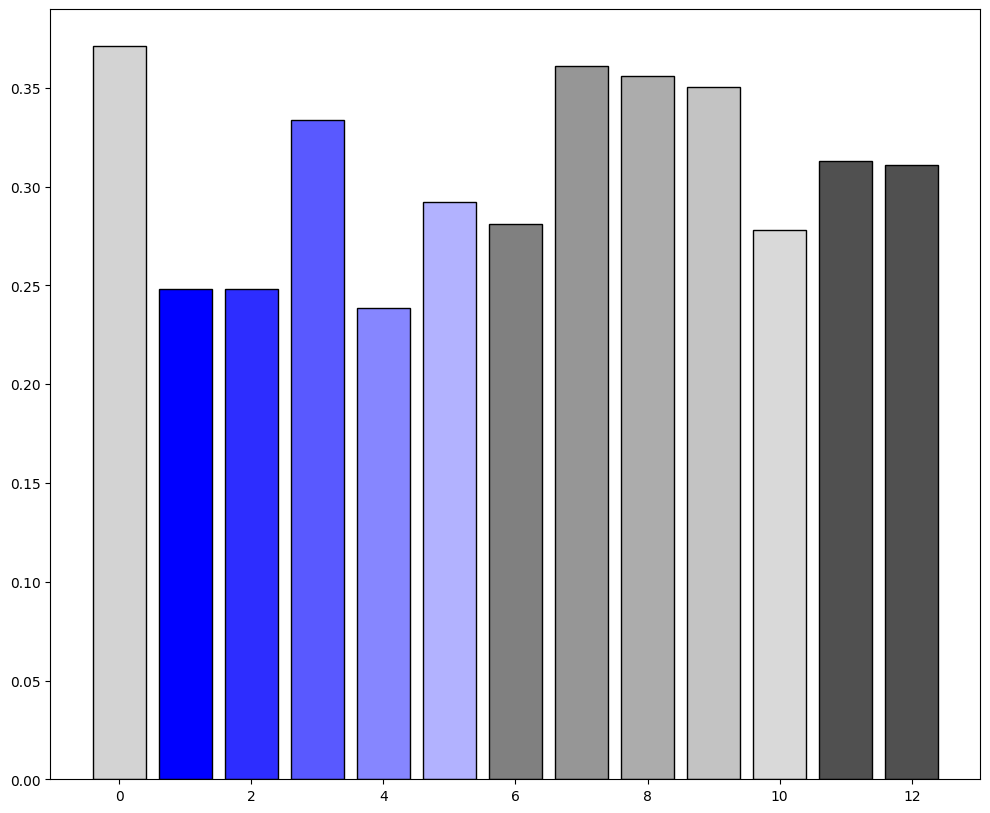

In [9]:
# dinos all same shade of grey
import numpy as np
import matplotlib.colors as mcolors

# Define your base colors per group.
group_base_colors = {
    "Baseline": "#D3D3D3",         # light grey for the baseline
    "Top Neural Models": "#0000FF", # base blue
    "Top V1 Models": "#800080",     # purple
    "Dino Models": "#505050"        # dark grey for Dino models
    # You can add other groups if needed.
}

def generate_shades(base_color, num_shades, light_factor=0.7):
    """
    Generate a list of colors transitioning from the base color (darker) toward a lighter version.
    
    Parameters:
      base_color (str): The hex color code for the base color.
      num_shades (int): Number of shades needed.
      light_factor (float): How much lighter the final shade is (0: no change, 1: white).
      
    Returns:
      list of hex colors.
    """
    base_rgb = np.array(mcolors.to_rgb(base_color))
    shades = []
    for alpha in np.linspace(0, light_factor, num_shades):
        # Interpolate between the base color and white.
        shade_rgb = base_rgb * (1 - alpha) + np.array([1, 1, 1]) * alpha
        shades.append(mcolors.to_hex(shade_rgb))
    return shades

def assign_shade_colors(df):
    """
    For each ranking category in the DataFrame, assign shades to all models in that category.
    For "Dino Models", assign a fixed color (the base color) to all rows.
    """
    # We will add a new column "shaded_color" to the DataFrame
    df = df.copy()  # Avoid modifying the original DataFrame
    df["shaded_color"] = ""

    # Process each group separately:
    for cat, group_df in df.groupby("ranking_category"):
        # Get the base color from our lookup:
        base_color = group_base_colors.get(cat, "#808080")  # default to grey if category not found
        
        if cat == "Dino Models":
            # Assign the same base_color to all rows in this category.
            shade_list = [base_color] * len(group_df)
        else:
            # Generate shades for this category.
            num_models = len(group_df)
            # Generate shades with the darkest shade at the beginning.
            shade_list = generate_shades(base_color, num_models, light_factor=0.7)
        
        # Sort the group by order or ranking within the group if needed.
        # Here we assume you want lower order values (higher ranking) to get the first (darker) colors.
        group_sorted = group_df.sort_values("order")
        
        for idx, shade in zip(group_sorted.index, shade_list):
            df.at[idx, "shaded_color"] = shade

    return df

# Example usage:
# (Assuming that 'all_summaries' is your DataFrame that already has a column called "ranking_category".)
all_summaries = assign_shade_colors(all_summaries)

# Now you can use the "shaded_color" column for plotting:
import matplotlib.pyplot as plt
x = np.arange(len(all_summaries))
plt.figure(figsize=(12, 10))
plt.bar(x, all_summaries["group1_mean_corr"], color=all_summaries["shaded_color"].tolist(), edgecolor='k')
plt.show()


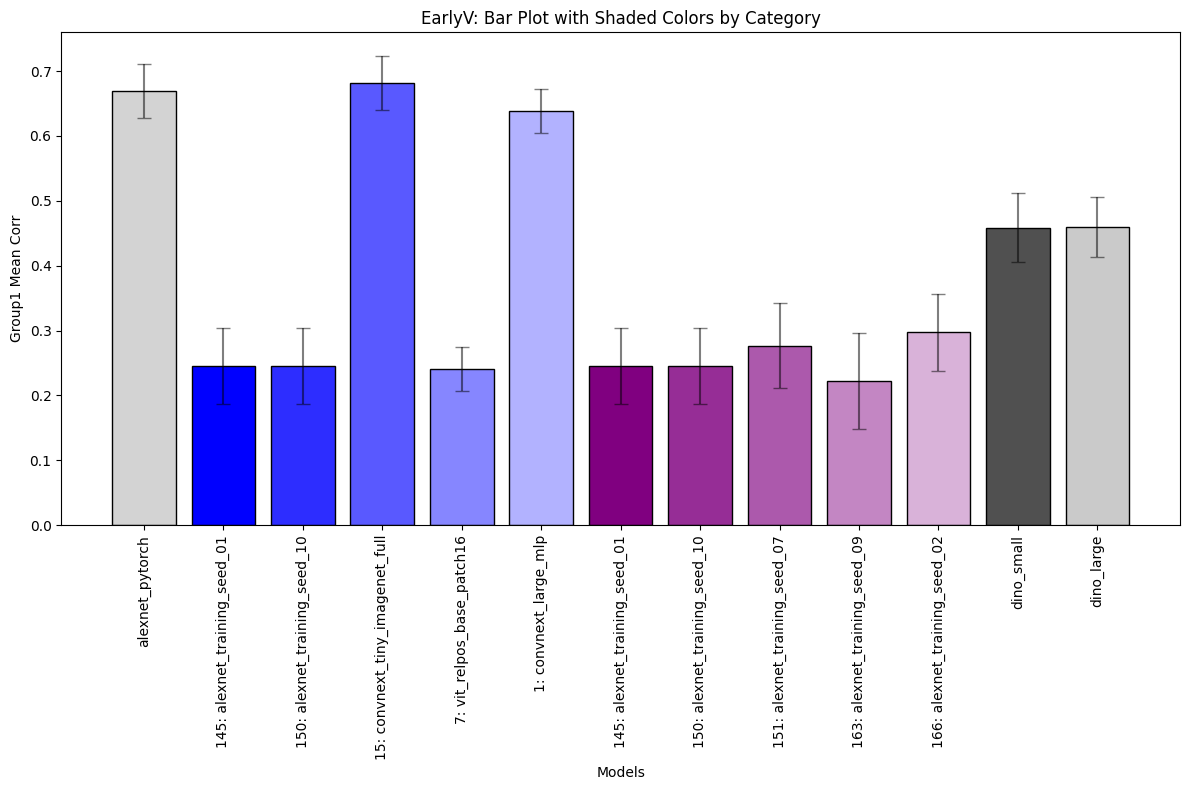

In [7]:
# Create a simple bar plot using the shaded colors.
x = np.arange(len(all_summaries))
plt.figure(figsize=(12, 8))
plt.bar(x, all_summaries["group1_mean_corr"], 
        color=all_summaries["shaded_color"].tolist(), edgecolor='k')

# Optionally add error bars:
plt.errorbar(x, all_summaries["group1_mean_corr"],
             yerr=all_summaries["error"],
             fmt='none', ecolor='black', alpha=0.5, capsize=5)

# Customizing x-axis labels:
plt.xticks(x, all_summaries["model"], rotation=90)

plt.xlabel("Models")
plt.ylabel("Group1 Mean Corr")
plt.title("EarlyV: Bar Plot with Shaded Colors by Category")
plt.tight_layout()
plt.show()


Comparing alexnet_pytorch vs. 145: alexnet_training_seed_01, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 150: alexnet_training_seed_10, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 15: convnext_tiny_imagenet_full, one-sided p-value = 1.0000
Comparing alexnet_pytorch vs. 7: vit_relpos_base_patch16, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 1: convnext_large_mlp, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 151: alexnet_training_seed_07, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 163: alexnet_training_seed_09, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 166: alexnet_training_seed_02, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. dino_small, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. dino_large, one-sided p-value = 0.0000


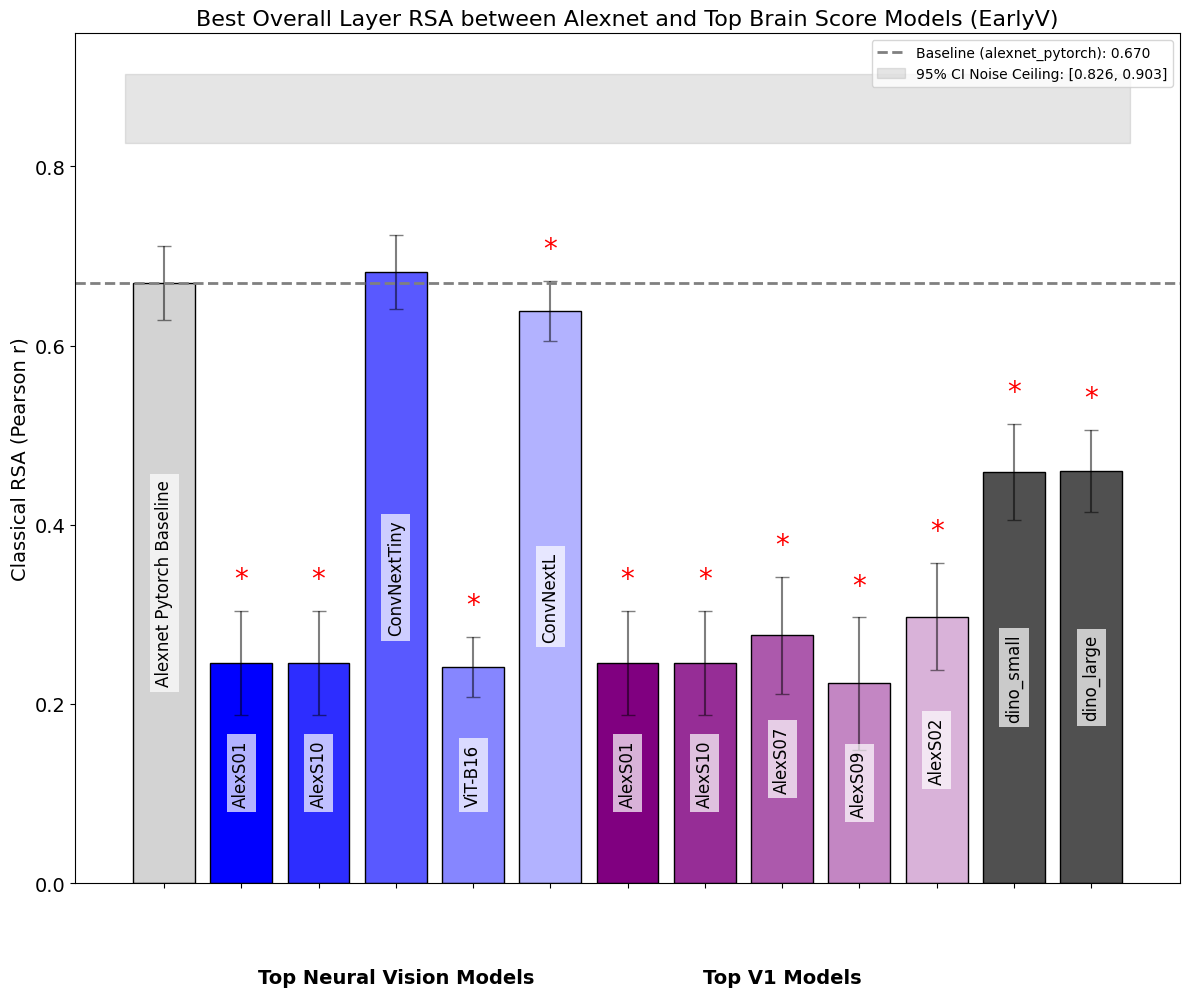

In [25]:
# 3. SIGNIFICANCE TEST AND SHORT NAMES
# ---------------------------
# The baseline model is assumed to be 'alexnet_pytorch'
baseline = "alexnet_pytorch"
if baseline not in all_summaries["model"].unique():
    raise ValueError("Baseline not found in data!")

# For significance testing, we assume you have a dictionary of intermediate results
# for each model stored in "intermediates_data" (this code snippet is based on your original code).
# (Make sure 'intermediates_data' has been computed before or load it accordingly.)

# For demonstration, here's a mock structure:
# You likely already have:
#   intermediates_data[model]["group1_corr"].values
# Let’s assume the following block has been run before:
baseline_data = intermediates_data[baseline]
baseline_corrs = baseline_data["group1_corr"].values

significance = {}
for model, inter_df in intermediates_data.items():
    if model == baseline:
        continue
    model_corrs = inter_df["group1_corr"].values
    if len(baseline_corrs) == len(model_corrs):
        t_stat, p_val_two_sided = ttest_rel(baseline_corrs, model_corrs)
        if t_stat > 0:
            p_val_one_sided = p_val_two_sided / 2
        else:
            p_val_one_sided = 1 - (p_val_two_sided / 2)
        significance[model] = p_val_one_sided
        print(f"Comparing {baseline} vs. {model}, one-sided p-value = {p_val_one_sided:.4f}")
    else:
        significance[model] = np.nan

# Define short names to be displayed inside the bars:
model_short_names = {
    'alexnet_pytorch': "Alexnet Pytorch Baseline",
    "1: convnext_large_mlp": "ConvNextL",
    "7: vit_relpos_base_patch16": "ViT-B16",
    "15: convnext_tiny_imagenet_full": "ConvNextTiny",
    "145: alexnet_training_seed_01": "AlexS01",
    "150: alexnet_training_seed_10": "AlexS10",
    "151: alexnet_training_seed_07": "AlexS07",
    "163: alexnet_training_seed_09": "AlexS09",
    "166: alexnet_training_seed_02": "AlexS02"
}

# ---------------------------
# 4. PLOTTING THE BAR GRAPH
# ---------------------------
plt.figure(figsize=(12, 10))
x = np.arange(len(all_summaries))

# Use the newly assigned shaded colors from our DataFrame
bar_colors = all_summaries["shaded_color"].tolist()

# Draw the bars with error bars
plt.bar(x, all_summaries["group1_mean_corr"], color=bar_colors, edgecolor='k')
plt.errorbar(x, all_summaries["group1_mean_corr"],
             yerr=all_summaries["error"],
             fmt='none', ecolor='black', alpha=0.5, capsize=5)

# Plot baseline horizontal line
baseline_mean = all_summaries.loc[all_summaries["model"] == baseline, "group1_mean_corr"].iloc[0]
plt.axhline(baseline_mean, color='grey', linestyle='--', linewidth=2,
            label=f"Baseline ({baseline}): {baseline_mean:.3f}")

# Hide x-axis tick labels (we'll add our own short names on top of the bars)
plt.xticks(x, [""] * len(x))

# Place short names inside bars
for i, row in all_summaries.iterrows():
    model = row["model"]
    short_name = model_short_names.get(model, model)
    bar_height = row["group1_mean_corr"]
    # Place text within the bar (or just above if bar is very short)
    if bar_height > 0:
        y_pos = bar_height / 2
        text_color = "black"
    else:
        y_pos = bar_height - 0.02
        text_color = "black"
    plt.text(x[i], y_pos, short_name,
             ha='center', va='center', color=text_color,
             rotation=90, fontsize=12,
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Add stars if p < 0.05 for significance (one-sided)
for i, row in all_summaries.iterrows():
    model = row["model"]
    if model == baseline:
        continue
    p_val = significance.get(model, np.nan)
    if not np.isnan(p_val) and p_val < 0.05:
        y_val = row["group1_mean_corr"] + row["error"] + 0.02
        plt.text(x[i], y_val, "*", ha='center', va='bottom', color='red', fontsize=20)

# ---------------------------
# 5. ADD GROUP LABELS
# ---------------------------
# Example: If baseline is at index 0 and your groups are defined by order ranges:
# For Top Neural Models (orders 1-5)
neural_indices = np.arange(1, 6)
if len(neural_indices) > 0:
    neural_mid = neural_indices.mean()
    plt.text(neural_mid, -0.1, "Top Neural Vision Models",
             ha='center', va='top', fontsize=14, fontweight='bold',
             transform=plt.gca().get_xaxis_transform())

# For Top V1 Models (orders 6-10)
v1_indices = np.arange(6, 11)
if len(v1_indices) > 0:
    v1_mid = v1_indices.mean()
    plt.text(v1_mid, -0.1, "Top V1 Models",
             ha='center', va='top', fontsize=14, fontweight='bold',
             transform=plt.gca().get_xaxis_transform())

# ---------------------------
# 6. ADD NOISE CEILING (OPTIONAL)
# ---------------------------
# (Assuming you have a function compute_noise_ceiling and the EarlyV_rdms_array loaded)
noise_results = compute_noise_ceiling(EarlyV_rdms_array, num_splits=None)
noise_ceiling = noise_results["noise_ceiling"]
noise_ci_lower, noise_ci_upper = noise_results["ci"]

plt.fill_between(
    [-0.5, len(all_summaries)-0.5],
    noise_ci_lower,
    noise_ci_upper,
    color='grey', alpha=0.2,
    label=f"95% CI Noise Ceiling: [{noise_ci_lower:.3f}, {noise_ci_upper:.3f}]"
)

# Final plot adjustments
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Classical RSA (Pearson r)", fontsize=14)
plt.title("Best Overall Layer RSA between Alexnet and Top Brain Score Models (EarlyV)", fontsize=16)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# final version

In [1]:
## Functions

# dinos all same shade of grey
import numpy as np
import matplotlib.colors as mcolors

# Define your base colors per group.
group_base_colors = {
    "Baseline": "#D3D3D3",         # light grey for the baseline
    "Top Neural Models": "#0000FF", # base blue
    "Top V1 Models": "#800080",     # purple
    "Top V4 Models": "#008000",     # green
    "Top IT Models": "#FFA500",     # orange
    "Dino Models": "#505050"        # dark grey for Dino models
    # You can add other groups if needed.
}

def generate_shades(base_color, num_shades, light_factor=0.7):
    """
    Generate a list of colors transitioning from the base color (darker) toward a lighter version.
    
    Parameters:
      base_color (str): The hex color code for the base color.
      num_shades (int): Number of shades needed.
      light_factor (float): How much lighter the final shade is (0: no change, 1: white).
      
    Returns:
      list of hex colors.
    """
    base_rgb = np.array(mcolors.to_rgb(base_color))
    shades = []
    for alpha in np.linspace(0, light_factor, num_shades):
        # Interpolate between the base color and white.
        shade_rgb = base_rgb * (1 - alpha) + np.array([1, 1, 1]) * alpha
        shades.append(mcolors.to_hex(shade_rgb))
    return shades

def assign_shade_colors(df):
    """
    For each ranking category in the DataFrame, assign shades to all models in that category.
    For "Dino Models", assign a fixed color (the base color) to all rows.
    """
    # We will add a new column "shaded_color" to the DataFrame
    df = df.copy()  # Avoid modifying the original DataFrame
    df["shaded_color"] = ""

    # Process each group separately:
    for cat, group_df in df.groupby("ranking_category"):
        # Get the base color from our lookup:
        base_color = group_base_colors.get(cat, "#808080")  # default to grey if category not found
        
        if cat == "Dino Models":
            # Assign the same base_color to all rows in this category.
            shade_list = [base_color] * len(group_df)
        else:
            # Generate shades for this category.
            num_models = len(group_df)
            # Generate shades with the darkest shade at the beginning.
            shade_list = generate_shades(base_color, num_models, light_factor=0.7)
        
        # Sort the group by order or ranking within the group if needed.
        # Here we assume you want lower order values (higher ranking) to get the first (darker) colors.
        group_sorted = group_df.sort_values("order")
        
        for idx, shade in zip(group_sorted.index, shade_list):
            df.at[idx, "shaded_color"] = shade

    return df

# # Example usage:
# # (Assuming that 'all_summaries' is your DataFrame that already has a column called "ranking_category".)
# all_summaries = assign_shade_colors(all_summaries)

# # Now you can use the "shaded_color" column for plotting:
# import matplotlib.pyplot as plt
# x = np.arange(len(all_summaries))
# plt.figure(figsize=(12, 10))
# plt.bar(x, all_summaries["group1_mean_corr"], color=all_summaries["shaded_color"].tolist(), edgecolor='k')
# plt.show()


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pickle
from scipy.stats import ttest_rel

# --- Load your RDM (for example purposes) ---
with open('reliable_roi_rdms/EarlyV_reliable_rdms.pkl', 'rb') as file:
    EarlyV_rdms = pickle.load(file)
EarlyV_rdms_array = np.stack(EarlyV_rdms)

# --- Set file paths ---
filepaths = [
    "Stats_additional_models/EarlyV_alexnet_pytorch_intermediates.csv",
    # Top Neural (average)
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_145: alexnet_training_seed_01_intermediates.csv",
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_150: alexnet_training_seed_10_intermediates.csv",
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_15: convnext_tiny_imagenet_full_intermediates.csv",
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_7: vit_relpos_base_patch16_intermediates.csv",
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_1: convnext_large_mlp_intermediates.csv",
    # Top V1
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_145: alexnet_training_seed_01_intermediates.csv",
    "Stats_EarlyV_Top_Avg_Vision/EarlyV_150: alexnet_training_seed_10_intermediates.csv",
    "Stats_EarlyV_Top_V1/EarlyV_151: alexnet_training_seed_07_intermediates.csv",
    "Stats_EarlyV_Top_V1/EarlyV_163: alexnet_training_seed_09_intermediates.csv",
    "Stats_EarlyV_Top_V1/EarlyV_166: alexnet_training_seed_02_intermediates.csv",
    # Dino models
    "Stats_additional_models/EarlyV_dino_small_intermediates.csv",
    "Stats_additional_models/EarlyV_dino_large_intermediates.csv"
]

# --- Build the summary DataFrame ---
summaries = []
intermediates_data = {}

for order, fp in enumerate(filepaths):
    summary_df = read_summary_csv(fp)
    base = os.path.basename(fp)
    no_ext = os.path.splitext(base)[0]
    # Extract a clean model name based on your filename convention
    parts = no_ext.split("_", 1)
    model_name_clean = parts[1].replace("_intermediates", "")
    summary_df["model"] = model_name_clean
    summary_df["order"] = order
    summaries.append(summary_df)

     
    # Read the intermediate data for this model and store it in the dictionary.
    inter_df = read_intermediate_data(fp)
    intermediates_data[model_name_clean] = inter_df

# Print the keys of the intermediates_data dictionary to verify which model names were captured.
#print("intermediates_data keys:", list(intermediates_data.keys()))


# Concatenate all the summaries:
all_summaries = pd.concat(summaries, ignore_index=True)
all_summaries = all_summaries.sort_values("order")

# Process confidence intervals:
all_summaries["ci"] = all_summaries["confidence_interval"].apply(parse_ci)
all_summaries["ci_lower"] = all_summaries["ci"].apply(lambda x: x[0])
all_summaries["ci_upper"] = all_summaries["ci"].apply(lambda x: x[1])
all_summaries["error"] = (all_summaries["ci_upper"] - all_summaries["ci_lower"]) / 2

# --- Create Ranking Categories ---

def get_category(order):
    if order == 0:
        return "Baseline"
    elif 1 <= order <= 5:
        return "Top Neural Models"
    elif 6 <= order <= 10:
        return "Top V1 Models"
    elif 11 <= order <= 13:
        return "Dino Models"
    else:
        return "Other"  # Adjust as needed

all_summaries["ranking_category"] = all_summaries["order"].apply(get_category)

# Optionally, rank within each group (0-indexed)
all_summaries["order_in_group"] = (all_summaries
                                   .groupby("ranking_category")["order"]
                                   .rank(method="first") - 1)
all_summaries = assign_shade_colors(all_summaries)

# significance testing
baseline = "alexnet_pytorch"
if baseline not in all_summaries["model"].unique():
    raise ValueError("Baseline not found in data!")
baseline_data = intermediates_data[baseline]
baseline_corrs = baseline_data["group1_corr"].values

significance = {}
for model, inter_df in intermediates_data.items():
    if model == baseline:
        continue
    model_corrs = inter_df["group1_corr"].values
    if len(baseline_corrs) == len(model_corrs):
        t_stat, p_val_two_sided = ttest_rel(baseline_corrs, model_corrs)
        p_val_one_sided = p_val_two_sided / 2 if t_stat > 0 else 1 - (p_val_two_sided / 2)
        significance[model] = p_val_one_sided
        print(f"Comparing {baseline} vs. {model}, one-sided p-value = {p_val_one_sided:.4f}")
    else:
        significance[model] = np.nan

# Assuming each row's 'model' is the key in the significance dictionary:
all_summaries["significance"] = all_summaries["model"].map(significance)

print(all_summaries[["model", "order", "order_in_group", "ranking_category", "shaded_color", "significance"]])


Comparing alexnet_pytorch vs. 145: alexnet_training_seed_01, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 150: alexnet_training_seed_10, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 15: convnext_tiny_imagenet_full, one-sided p-value = 1.0000
Comparing alexnet_pytorch vs. 7: vit_relpos_base_patch16, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 1: convnext_large_mlp, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 151: alexnet_training_seed_07, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 163: alexnet_training_seed_09, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 166: alexnet_training_seed_02, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. dino_small, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. dino_large, one-sided p-value = 0.0000
                              model  order  order_in_group   ranking_category  \
0                   alexnet_pytorch      0             0.0           Baseline   
1    

In [119]:
folder = "barplot_summaries_roi"
if not os.path.exists(folder):
    os.makedirs(folder)

# Save the DataFrame to a CSV file for future use.
EarlyV_summary = os.path.join(folder, "EarlyV_summary_with_categories.csv")
all_summaries.to_csv(EarlyV_summary, index=False)
print(f"DataFrame saved to {EarlyV_summary}")


DataFrame saved to barplot_summaries_roi/EarlyV_summary_with_categories.csv


In [5]:
# To load it back in:
import os
import pandas as pd

# Define the folder and file path
folder = "barplot_summaries_roi"
earlyv_summary_csv = os.path.join(folder, "EarlyV_summary_with_categories.csv")

# Load the CSV back into a DataFrame.
all_summaries = pd.read_csv(earlyv_summary_csv)
print(f"DataFrame loaded from {earlyv_summary_csv}")
print(all_summaries.head())


DataFrame loaded from barplot_summaries_roi/EarlyV_summary_with_categories.csv
   group1_mean_corr  group2_mean_corr    t_stat         p_val  \
0          0.669796          0.660219  2.855064  5.039323e-03   
1          0.245593          0.250095 -0.864927  3.887359e-01   
2          0.245593          0.250095 -0.864927  3.887359e-01   
3          0.682051          0.694404 -3.438940  7.940654e-04   
4          0.241157          0.213771  7.072136  9.573909e-11   

                         confidence_interval best_layer_mode  \
0    (0.626391650966858, 0.7100205220782048)      features.3   
1    (0.186609183290362, 0.3032349652366731)    classifier.1   
2    (0.186609183290362, 0.3032349652366731)    classifier.1   
3   (0.6389523240705466, 0.7218722520735961)      features.5   
4  (0.20734013858188918, 0.2745252667394236)       blocks.11   

   total_splits_used                            model  order  \
0                126                  alexnet_pytorch      0   
1                

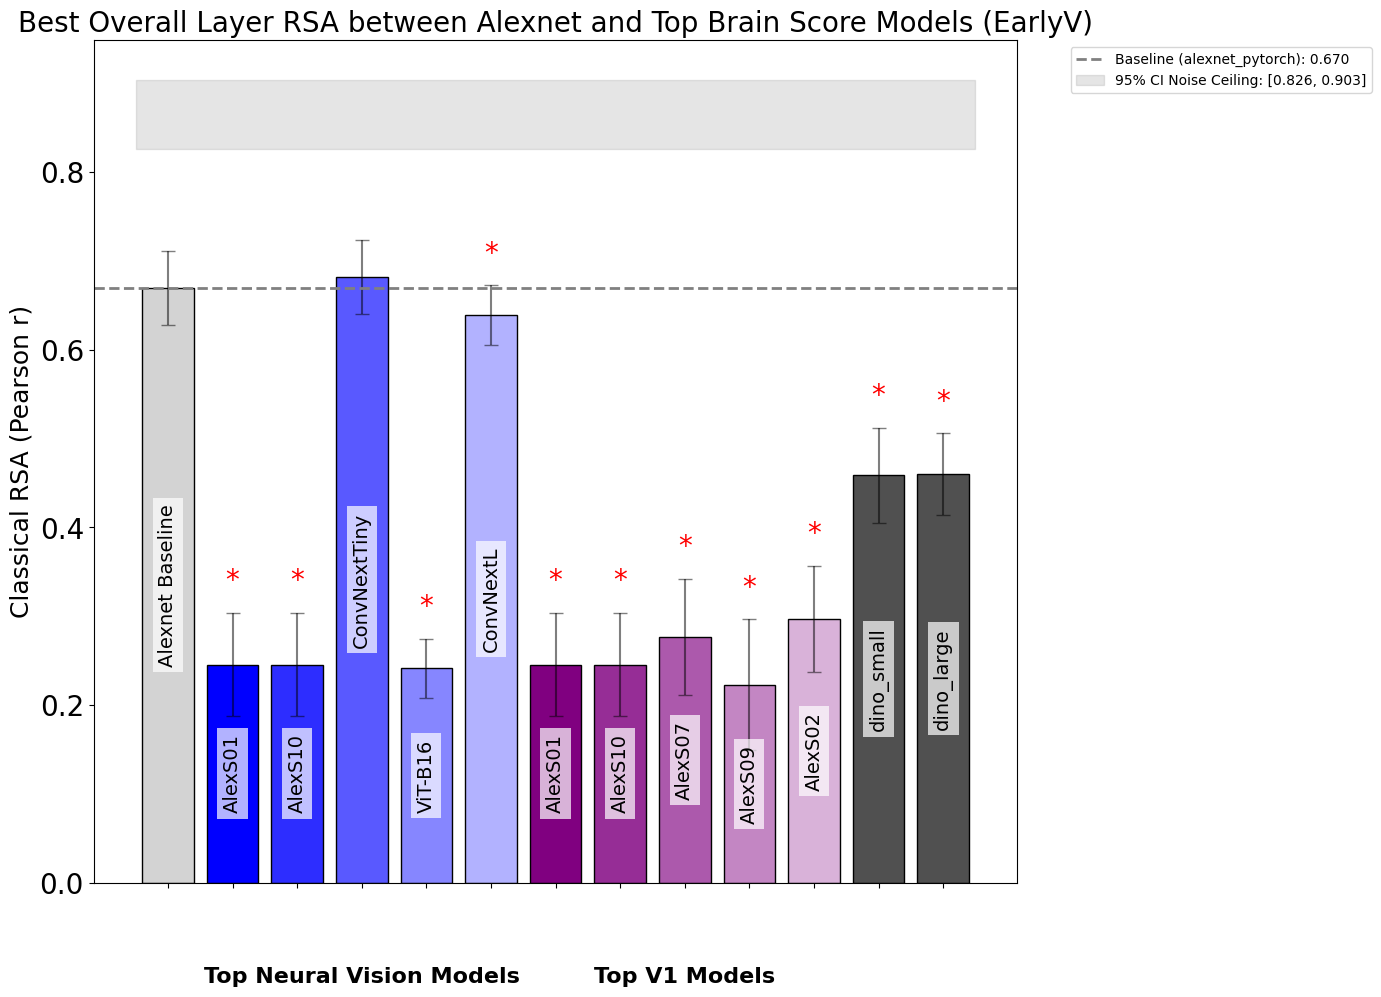

In [6]:
# # 3. SIGNIFICANCE TEST AND SHORT NAMES
# # ---------------------------
# # The baseline model is assumed to be 'alexnet_pytorch'
# baseline = "alexnet_pytorch"
# if baseline not in all_summaries["model"].unique():
#     raise ValueError("Baseline not found in data!")

# # For significance testing, we assume you have a dictionary of intermediate results
# # for each model stored in "intermediates_data" (this code snippet is based on your original code).
# # (Make sure 'intermediates_data' has been computed before or load it accordingly.)

# # For demonstration, here's a mock structure:
# # You likely already have:
# #   intermediates_data[model]["group1_corr"].values
# # Let’s assume the following block has been run before:
# baseline_data = intermediates_data[baseline]
# baseline_corrs = baseline_data["group1_corr"].values

# significance = {}
# for model, inter_df in intermediates_data.items():
#     if model == baseline:
#         continue
#     model_corrs = inter_df["group1_corr"].values
#     if len(baseline_corrs) == len(model_corrs):
#         t_stat, p_val_two_sided = ttest_rel(baseline_corrs, model_corrs)
#         if t_stat > 0:
#             p_val_one_sided = p_val_two_sided / 2
#         else:
#             p_val_one_sided = 1 - (p_val_two_sided / 2)
#         significance[model] = p_val_one_sided
#         print(f"Comparing {baseline} vs. {model}, one-sided p-value = {p_val_one_sided:.4f}")
#     else:
#         significance[model] = np.nan

# Define short names to be displayed inside the bars:
model_short_names = {
    'alexnet_pytorch': "Alexnet Baseline",
    "1: convnext_large_mlp": "ConvNextL",
    "7: vit_relpos_base_patch16": "ViT-B16",
    "15: convnext_tiny_imagenet_full": "ConvNextTiny",
    "145: alexnet_training_seed_01": "AlexS01",
    "150: alexnet_training_seed_10": "AlexS10",
    "151: alexnet_training_seed_07": "AlexS07",
    "163: alexnet_training_seed_09": "AlexS09",
    "166: alexnet_training_seed_02": "AlexS02"
}

# ---------------------------
# 4. PLOTTING THE BAR GRAPH
# ---------------------------
plt.figure(figsize=(14, 10))
x = np.arange(len(all_summaries))

# Use the newly assigned shaded colors from our DataFrame
bar_colors = all_summaries["shaded_color"].tolist()

# Draw the bars with error bars
plt.bar(x, all_summaries["group1_mean_corr"], color=bar_colors, edgecolor='k')
plt.errorbar(x, all_summaries["group1_mean_corr"],
             yerr=all_summaries["error"],
             fmt='none', ecolor='black', alpha=0.5, capsize=5)

# Plot baseline horizontal line
baseline_mean = all_summaries.loc[all_summaries["model"] == baseline, "group1_mean_corr"].iloc[0]
plt.axhline(baseline_mean, color='grey', linestyle='--', linewidth=2,
            label=f"Baseline ({baseline}): {baseline_mean:.3f}")

# Hide x-axis tick labels (we'll add our own short names on top of the bars)
plt.xticks(x, [""] * len(x))

# Place short names inside bars
for i, row in all_summaries.iterrows():
    model = row["model"]
    short_name = model_short_names.get(model, model)
    bar_height = row["group1_mean_corr"]
    # Place text within the bar (or just above if bar is very short)
    if bar_height > 0:
        y_pos = bar_height / 2
        text_color = "black"
    else:
        y_pos = bar_height - 0.02
        text_color = "black"
    plt.text(x[i], y_pos, short_name,
             ha='center', va='center', color=text_color,
             rotation=90, fontsize=14,
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Add stars if p < 0.05 for significance (one-sided)
for i, row in all_summaries.iterrows():
    model = row["model"]
    if model == baseline:
        continue
    p_val = significance.get(model, np.nan)
    if not np.isnan(p_val) and p_val < 0.05:
        y_val = row["group1_mean_corr"] + row["error"] + 0.02
        plt.text(x[i], y_val, "*", ha='center', va='bottom', color='red', fontsize=20)

# ---------------------------
# 5. ADD GROUP LABELS
# ---------------------------
# Example: If baseline is at index 0 and your groups are defined by order ranges:
# For Top Neural Models (orders 1-5)
neural_indices = np.arange(1, 6)
if len(neural_indices) > 0:
    neural_mid = neural_indices.mean()
    plt.text(neural_mid, -0.1, "Top Neural Vision Models",
             ha='center', va='top', fontsize=16, fontweight='bold',
             transform=plt.gca().get_xaxis_transform())

# For Top V1 Models (orders 6-10)
v1_indices = np.arange(6, 11)
if len(v1_indices) > 0:
    v1_mid = v1_indices.mean()
    plt.text(v1_mid, -0.1, "Top V1 Models",
             ha='center', va='top', fontsize=16, fontweight='bold',
             transform=plt.gca().get_xaxis_transform())

# ---------------------------
# 6. ADD NOISE CEILING (OPTIONAL)
# ---------------------------
# (Assuming you have a function compute_noise_ceiling and the EarlyV_rdms_array loaded)
noise_results = compute_noise_ceiling(EarlyV_rdms_array, num_splits=None)
noise_ceiling = noise_results["noise_ceiling"]
noise_ci_lower, noise_ci_upper = noise_results["ci"]

plt.fill_between(
    [-0.5, len(all_summaries)-0.5],
    noise_ci_lower,
    noise_ci_upper,
    color='grey', alpha=0.2,
    label=f"95% CI Noise Ceiling: [{noise_ci_lower:.3f}, {noise_ci_upper:.3f}]"
)


# Final plot adjustments
plt.xticks(fontsize=16)
plt.yticks(fontsize= 20)
plt.ylabel("Classical RSA (Pearson r)", fontsize=18)
plt.title("Best Overall Layer RSA between Alexnet and Top Brain Score Models (EarlyV)", fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# creating pOTC updated .csv file

In [11]:
## Functions

# dinos all same shade of grey
import numpy as np
import matplotlib.colors as mcolors
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Define your base colors per group.
group_base_colors = {
    "Baseline": "#D3D3D3",         # light grey for the baseline
    "Top Neural Models": "#0000FF", # base blue
    "Top V1 Models": "#800080",     # purple
    "Top V4 Models": "#008000",     # green
    "Top IT Models": "#FFA500",     # orange
    "Dino Models": "#505050"        # dark grey for Dino models
    # You can add other groups if needed.
}

def generate_shades(base_color, num_shades, light_factor=0.7):
    """
    Generate a list of colors transitioning from the base color (darker) toward a lighter version.
    
    Parameters:
      base_color (str): The hex color code for the base color.
      num_shades (int): Number of shades needed.
      light_factor (float): How much lighter the final shade is (0: no change, 1: white).
      
    Returns:
      list of hex colors.
    """
    base_rgb = np.array(mcolors.to_rgb(base_color))
    shades = []
    for alpha in np.linspace(0, light_factor, num_shades):
        # Interpolate between the base color and white.
        shade_rgb = base_rgb * (1 - alpha) + np.array([1, 1, 1]) * alpha
        shades.append(mcolors.to_hex(shade_rgb))
    return shades

def assign_shade_colors(df):
    """
    For each ranking category in the DataFrame, assign shades to all models in that category.
    For "Dino Models", assign a fixed color (the base color) to all rows.
    """
    # We will add a new column "shaded_color" to the DataFrame
    df = df.copy()  # Avoid modifying the original DataFrame
    df["shaded_color"] = ""

    # Process each group separately:
    for cat, group_df in df.groupby("ranking_category"):
        # Get the base color from our lookup:
        base_color = group_base_colors.get(cat, "#808080")  # default to grey if category not found
        
        if cat == "Dino Models":
            # Assign the same base_color to all rows in this category.
            shade_list = [base_color] * len(group_df)
        else:
            # Generate shades for this category.
            num_models = len(group_df)
            # Generate shades with the darkest shade at the beginning.
            shade_list = generate_shades(base_color, num_models, light_factor=0.7)
        
        # Sort the group by order or ranking within the group if needed.
        # Here we assume you want lower order values (higher ranking) to get the first (darker) colors.
        group_sorted = group_df.sort_values("order")
        
        for idx, shade in zip(group_sorted.index, shade_list):
            df.at[idx, "shaded_color"] = shade

    return df


def compute_noise_ceiling(rdms_roi, num_splits=None):
    """
    Compute the noise ceiling for a set of subject-specific RDMs.
    
    For a given ROI, the noise ceiling is defined as the mean similarity (Pearson r)
    between the average RDMs computed on two split-halves of subjects.
    The similarity is computed by correlating the lower-triangular elements (excluding the diagonal)
    of the average RDMs for each half. This is repeated for all (or a specified number of) split-halves.
    
    The noise ceiling is estimated as the inverse Fisher-z of the mean of the Fisher-z transformed
    correlation values across splits. An adjusted 95% confidence interval (CI) is computed that
    takes into account the non-independence of the samples.
    
    Parameters:
      rdms_roi (np.array): 3D array of shape (N, n_items, n_items) containing subject-specific RDMs for the ROI.
      num_splits (int or None): Number of splits to use. If None, all possible splits are used.
    
    Returns:
      dict: A dictionary containing:
            - "noise_ceiling": the estimated noise ceiling (mean correlation).
            - "ci": a tuple with the lower and upper bounds of the 95% CI.
            - "split_correlations": an array of the Pearson correlations for each split.
    """
    # Total number of subjects
    N = rdms_roi.shape[0]
    all_splits = get_split_halves(N)
    
    # Determine which splits to use.
    if num_splits is None or num_splits > len(all_splits):
        selected_splits = all_splits
    else:
        selected_splits = all_splits[:num_splits]
    
    split_corrs = []
    
    # Iterate over each split.
    for (group1_idxs, group2_idxs) in selected_splits:
        # Extract RDMs for the two groups.
        group1_rdms = rdms_roi[group1_idxs]
        group2_rdms = rdms_roi[group2_idxs]
        
        # Compute average RDMs for each half (ensuring a 2D output).
        avg_rdm_group1 = np.squeeze(compute_avg_rdm(group1_rdms))
        avg_rdm_group2 = np.squeeze(compute_avg_rdm(group2_rdms))
        
        # Compute the Pearson correlation between the lower triangular elements.
        r = compare_rdms(avg_rdm_group1, avg_rdm_group2)
        split_corrs.append(r)
    
    split_corrs = np.array(split_corrs)
    
    # Convert correlations to Fisher-z values.
    z_values = fisherz(split_corrs)
    
    # Average Fisher-z values and then invert to obtain the noise ceiling.
    mean_z = np.mean(z_values)
    noise_ceiling = fisherz_inv(mean_z)
    
    # Compute an adjusted 95% CI on the Fisher-z values.
    z_mean, z_lower, z_upper = compute_adjusted_ci(z_values)
    ci_lower = fisherz_inv(z_lower)
    ci_upper = fisherz_inv(z_upper)
    
    return {
        "noise_ceiling": noise_ceiling,
        "ci": (ci_lower, ci_upper),
        "split_correlations": split_corrs
    }


In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pickle
from scipy.stats import ttest_rel

# Load the EarlyV RDMs (assumed to be a list of (72,72) arrays for each subject)
with open('reliable_roi_rdms/pOTC_reliable_rdms.pkl', 'rb') as file:
    pOTC_rdms = pickle.load(file)
    
# Convert list to a 3D NumPy array
pOTC_rdms_array = np.stack(pOTC_rdms) 

filepaths = [
    #"Stats_intermediate_Alexnet/pOTC_Alexnet_intermediates.csv",
    "Stats_additional_models/pOTC_alexnet_pytorch_intermediates.csv",
    
    # Top Neural (average)
    "Stats_pOTC_Top_Avg_Vision/pOTC_145: alexnet_training_seed_01_intermediates.csv",
    "Stats_pOTC_Top_Avg_Vision/pOTC_150: alexnet_training_seed_10_intermediates.csv",
    "Stats_pOTC_Top_Avg_Vision/pOTC_15: convnext_tiny_imagenet_full_intermediates.csv",
    "Stats_pOTC_Top_Avg_Vision/pOTC_7: vit_relpos_base_patch16_intermediates.csv",
    "Stats_pOTC_Top_Avg_Vision/pOTC_1: convnext_large_mlp_intermediates.csv",
    
    # Top V4
    "Stats_pOTC_Top_V4/pOTC_2:convnext_xlarge_intermediates.csv",
    "Stats_pOTC_Top_V4/pOTC_69: efficientnet_b2_imagenet_full_intermediates.csv",
    "Stats_pOTC_Top_V4/pOTC_39: cvt_cvt-21-384-in1k_4_LucyV4_intermediates.csv",
    "Stats_pOTC_Top_V4/pOTC_11: swim_small_patch4_window7_intermediates.csv",
    "Stats_pOTC_Top_V4/pOTC_143: omnivore_swinS_intermediates.csv",

    #"Stats_additional_models/pOTC_alexnet_pytorch_intermediates.csv",
    "Stats_additional_models/pOTC_dino_small_intermediates.csv",
    "Stats_additional_models/pOTC_dino_large_intermediates.csv"
]

# --- Build the summary DataFrame ---
summaries = []
intermediates_data = {}

for order, fp in enumerate(filepaths):
    summary_df = read_summary_csv(fp)
    base = os.path.basename(fp)
    no_ext = os.path.splitext(base)[0]
    # Extract a clean model name based on your filename convention
    parts = no_ext.split("_", 1)
    model_name_clean = parts[1].replace("_intermediates", "")
    summary_df["model"] = model_name_clean
    summary_df["order"] = order
    summaries.append(summary_df)

     
    # Read the intermediate data for this model and store it in the dictionary.
    inter_df = read_intermediate_data(fp)
    intermediates_data[model_name_clean] = inter_df

# Print the keys of the intermediates_data dictionary to verify which model names were captured.
#print("intermediates_data keys:", list(intermediates_data.keys()))


# Concatenate all the summaries:
all_summaries = pd.concat(summaries, ignore_index=True)
all_summaries = all_summaries.sort_values("order")

# Process confidence intervals:
all_summaries["ci"] = all_summaries["confidence_interval"].apply(parse_ci)
all_summaries["ci_lower"] = all_summaries["ci"].apply(lambda x: x[0])
all_summaries["ci_upper"] = all_summaries["ci"].apply(lambda x: x[1])
all_summaries["error"] = (all_summaries["ci_upper"] - all_summaries["ci_lower"]) / 2

# --- Create Ranking Categories ---

def get_category(order):
    if order == 0:
        return "Baseline"
    elif 1 <= order <= 5:
        return "Top Neural Models"
    elif 6 <= order <= 10:
        return "Top V4 Models"
    elif 11 <= order <= 13:
        return "Dino Models"
    else:
        return "Other"  # Adjust as needed

all_summaries["ranking_category"] = all_summaries["order"].apply(get_category)

# Optionally, rank within each group (0-indexed)
all_summaries["order_in_group"] = (all_summaries
                                   .groupby("ranking_category")["order"]
                                   .rank(method="first") - 1)
all_summaries = assign_shade_colors(all_summaries)

# significance testing
baseline = "alexnet_pytorch"
if baseline not in all_summaries["model"].unique():
    raise ValueError("Baseline not found in data!")
baseline_data = intermediates_data[baseline]
baseline_corrs = baseline_data["group1_corr"].values

significance = {}
for model, inter_df in intermediates_data.items():
    if model == baseline:
        continue
    model_corrs = inter_df["group1_corr"].values
    if len(baseline_corrs) == len(model_corrs):
        t_stat, p_val_two_sided = ttest_rel(baseline_corrs, model_corrs)
        p_val_one_sided = p_val_two_sided / 2 if t_stat > 0 else 1 - (p_val_two_sided / 2)
        significance[model] = p_val_one_sided
        print(f"Comparing {baseline} vs. {model}, one-sided p-value = {p_val_one_sided:.4f}")
    else:
        significance[model] = np.nan

# Assuming each row's 'model' is the key in the significance dictionary:
all_summaries["significance"] = all_summaries["model"].map(significance)

print(all_summaries[["model", "order", "order_in_group", "ranking_category", "shaded_color", "significance"]])


Comparing alexnet_pytorch vs. 145: alexnet_training_seed_01, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 150: alexnet_training_seed_10, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 15: convnext_tiny_imagenet_full, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 7: vit_relpos_base_patch16, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 1: convnext_large_mlp, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 2:convnext_xlarge, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 69: efficientnet_b2_imagenet_full, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 39: cvt_cvt-21-384-in1k_4_LucyV4, one-sided p-value = 0.0001
Comparing alexnet_pytorch vs. 11: swim_small_patch4_window7, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 143: omnivore_swinS, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. dino_small, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. dino_large, one-sided p-value = 0.0000
      

In [13]:
folder = "barplot_summaries_roi"
if not os.path.exists(folder):
    os.makedirs(folder)

# Save the DataFrame to a CSV file for future use.
pOTC_summary = os.path.join(folder, "pOTC_summary_with_categories.csv")
all_summaries.to_csv(pOTC_summary, index=False)
print(f"DataFrame saved to {pOTC_summary}")

DataFrame saved to barplot_summaries_roi/pOTC_summary_with_categories.csv


In [14]:
# To load it back in:
import os
import pandas as pd

# Define the folder and file path
folder = "barplot_summaries_roi"
pOTC_summary_csv = os.path.join(folder, "pOTC_summary_with_categories.csv")

# Load the CSV back into a DataFrame.
all_summaries = pd.read_csv(pOTC_summary_csv)
print(f"DataFrame loaded from {pOTC_summary_csv}")
print(all_summaries.head())


DataFrame loaded from barplot_summaries_roi/pOTC_summary_with_categories.csv
   group1_mean_corr  group2_mean_corr    t_stat         p_val  \
0          0.371207          0.329116  9.752878  4.690853e-17   
1          0.247964          0.255777 -1.378652  1.704643e-01   
2          0.247964          0.255777 -1.378652  1.704643e-01   
3          0.333479          0.304314  4.357184  2.719094e-05   
4          0.238311          0.237166  0.200651  8.412975e-01   

                          confidence_interval best_layer_mode  \
0   (0.32710967444456257, 0.4140752686239732)     features.12   
1  (0.17769478040951106, 0.31631803550071197)    classifier.1   
2  (0.17769478040951106, 0.31631803550071197)    classifier.1   
3    (0.2603190344589254, 0.4037581226103312)      features.6   
4  (0.16448872623534808, 0.31011597669747304)        blocks.8   

   total_splits_used                            model  order  \
0                126                  alexnet_pytorch      0   
1            

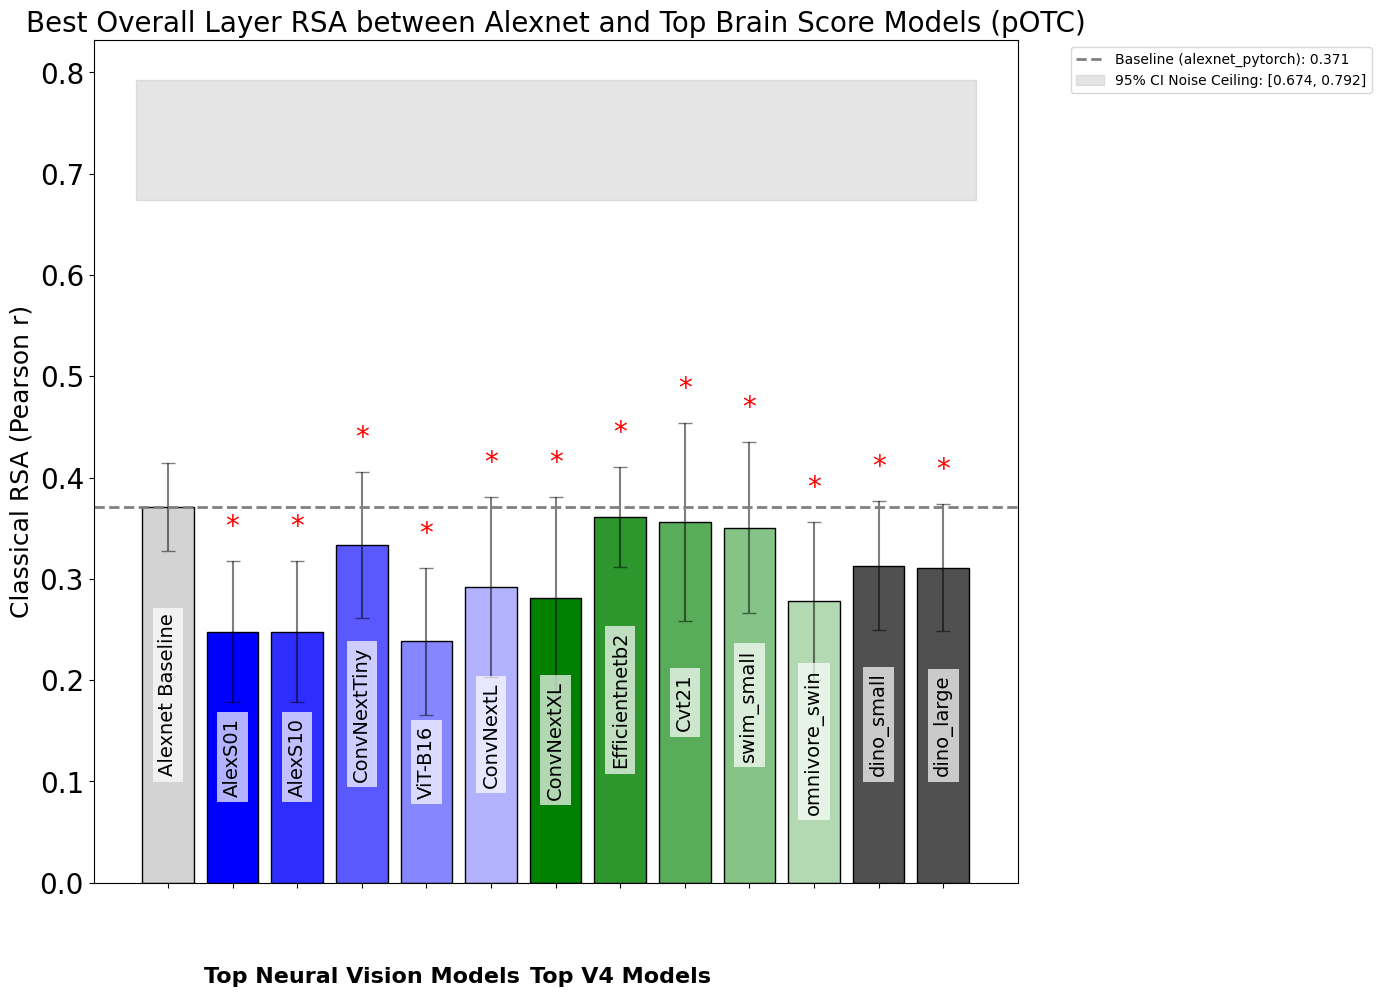

In [16]:
# Short names
model_short_names = {
    #'Alexnet': "Alexnet Baseline",
    'alexnet_pytorch': "Alexnet Baseline",
    "1: convnext_large_mlp": "ConvNextL",
    "7: vit_relpos_base_patch16": "ViT-B16",
    "15: convnext_tiny_imagenet_full": "ConvNextTiny",
    "145: alexnet_training_seed_01": "AlexS01",
    "150: alexnet_training_seed_10": "AlexS10",
    "2:convnext_xlarge": "ConvNextXL",
    "69: efficientnet_b2_imagenet_full": "Efficientnetb2",
    "39: cvt_cvt-21-384-in1k_4_LucyV4": "Cvt21",
    "11: swim_small_patch4_window7": "swim_small",
    "143: omnivore_swinS": "omnivore_swin"
   
}
# 4. PLOTTING THE BAR GRAPH
# ---------------------------
plt.figure(figsize=(14, 10))
x = np.arange(len(all_summaries))

# Use the newly assigned shaded colors from our DataFrame
bar_colors = all_summaries["shaded_color"].tolist()

# Draw the bars with error bars
plt.bar(x, all_summaries["group1_mean_corr"], color=bar_colors, edgecolor='k')
plt.errorbar(x, all_summaries["group1_mean_corr"],
             yerr=all_summaries["error"],
             fmt='none', ecolor='black', alpha=0.5, capsize=5)

# Plot baseline horizontal line
baseline_mean = all_summaries.loc[all_summaries["model"] == baseline, "group1_mean_corr"].iloc[0]
plt.axhline(baseline_mean, color='grey', linestyle='--', linewidth=2,
            label=f"Baseline ({baseline}): {baseline_mean:.3f}")

# Hide x-axis tick labels (we'll add our own short names on top of the bars)
plt.xticks(x, [""] * len(x))

# Place short names inside bars
for i, row in all_summaries.iterrows():
    model = row["model"]
    short_name = model_short_names.get(model, model)
    bar_height = row["group1_mean_corr"]
    # Place text within the bar (or just above if bar is very short)
    if bar_height > 0:
        y_pos = bar_height / 2
        text_color = "black"
    else:
        y_pos = bar_height - 0.02
        text_color = "black"
    plt.text(x[i], y_pos, short_name,
             ha='center', va='center', color=text_color,
             rotation=90, fontsize=14,
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Add stars if p < 0.05 for significance (one-sided)
for i, row in all_summaries.iterrows():
    model = row["model"]
    if model == baseline:
        continue
    p_val = significance.get(model, np.nan)
    if not np.isnan(p_val) and p_val < 0.05:
        y_val = row["group1_mean_corr"] + row["error"] + 0.02
        plt.text(x[i], y_val, "*", ha='center', va='bottom', color='red', fontsize=20)

# ---------------------------
# 5. ADD GROUP LABELS
# ---------------------------
# Example: If baseline is at index 0 and your groups are defined by order ranges:
# For Top Neural Models (orders 1-5)
neural_indices = np.arange(1, 6)
if len(neural_indices) > 0:
    neural_mid = neural_indices.mean()
    plt.text(neural_mid, -0.1, "Top Neural Vision Models",
             ha='center', va='top', fontsize=16, fontweight='bold',
             transform=plt.gca().get_xaxis_transform())

# For Top V1 Models (orders 6-10)
v1_indices = np.arange(7, 8)
if len(v1_indices) > 0:
    v1_mid = v1_indices.mean()
    plt.text(v1_mid, -0.1, "Top V4 Models",
             ha='center', va='top', fontsize=16, fontweight='bold',
             transform=plt.gca().get_xaxis_transform())

# ---------------------------
# 6. ADD NOISE CEILING (OPTIONAL)
# ---------------------------
# (Assuming you have a function compute_noise_ceiling and the EarlyV_rdms_array loaded)
noise_results = compute_noise_ceiling(pOTC_rdms_array, num_splits=None)
noise_ceiling = noise_results["noise_ceiling"]
noise_ci_lower, noise_ci_upper = noise_results["ci"]

plt.fill_between(
    [-0.5, len(all_summaries)-0.5],
    noise_ci_lower,
    noise_ci_upper,
    color='grey', alpha=0.2,
    label=f"95% CI Noise Ceiling: [{noise_ci_lower:.3f}, {noise_ci_upper:.3f}]"
)

# Final plot adjustments
plt.xticks(fontsize=16)
plt.yticks(fontsize=20)
plt.ylabel("Classical RSA (Pearson r)", fontsize=18)
plt.title("Best Overall Layer RSA between Alexnet and Top Brain Score Models (pOTC)", fontsize=20) # make ROI more flexible
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# creating aOTC final csv

In [127]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pickle
from scipy.stats import ttest_rel

# Best bar plot so far!

# Load reliable ROI RDMs.
with open('reliable_roi_rdms/aOTC_reliable_rdms.pkl', 'rb') as file:
    aOTC_rdms = pickle.load(file)
aOTC_rdms_array = np.stack(aOTC_rdms)
rdms = {"aOTC": aOTC_rdms_array}

filepaths = [
   # "Stats_intermediate_Alexnet/aOTC_Alexnet_intermediates.csv",
    "Stats_additional_models/aOTC_alexnet_pytorch_intermediates.csv",
    # Top Neural (average)
    "Stats_aOTC_Top_Avg_Vision/aOTC_145: alexnet_training_seed_01_intermediates.csv",
    "Stats_aOTC_Top_Avg_Vision/aOTC_150: alexnet_training_seed_10_intermediates.csv",
    "Stats_aOTC_Top_Avg_Vision/aOTC_15: convnext_tiny_imagenet_full_intermediates.csv",
    "Stats_aOTC_Top_Avg_Vision/aOTC_7: vit_relpos_base_patch16_intermediates.csv",
    "Stats_aOTC_Top_Avg_Vision/aOTC_1: convnext_large_mlp_intermediates.csv",
    
    # Top IT
    "Stats_aOTC_Top_IT/aOTC_128: ReAlnet01_cornet_intermediates.csv",
    "Stats_aOTC_Top_IT/aOTC_134: ReAlnet03_cornet_intermediates.csv",
    "Stats_aOTC_Top_IT/aOTC_123: ReAlnet07_cornet_intermediates.csv",
    "Stats_aOTC_Top_IT/aOTC_115: ReAlnet10_cornet:laion2b_ft_in1k_intermediates.csv",
    "Stats_aOTC_Top_IT/aOTC_118: ReAlnet08_cornet: openai_ft_in1k_intermediates.csv",


    "Stats_additional_models/aOTC_dino_small_intermediates.csv",
    "Stats_additional_models/aOTC_dino_large_intermediates.csv"
]

# --- Build the summary DataFrame ---
summaries = []
intermediates_data = {}

for order, fp in enumerate(filepaths):
    summary_df = read_summary_csv(fp)
    base = os.path.basename(fp)
    no_ext = os.path.splitext(base)[0]
    # Extract a clean model name based on your filename convention
    parts = no_ext.split("_", 1)
    model_name_clean = parts[1].replace("_intermediates", "")
    summary_df["model"] = model_name_clean
    summary_df["order"] = order
    summaries.append(summary_df)

     
    # Read the intermediate data for this model and store it in the dictionary.
    inter_df = read_intermediate_data(fp)
    intermediates_data[model_name_clean] = inter_df

# Print the keys of the intermediates_data dictionary to verify which model names were captured.
#print("intermediates_data keys:", list(intermediates_data.keys()))


# Concatenate all the summaries:
all_summaries = pd.concat(summaries, ignore_index=True)
all_summaries = all_summaries.sort_values("order")

# Process confidence intervals:
all_summaries["ci"] = all_summaries["confidence_interval"].apply(parse_ci)
all_summaries["ci_lower"] = all_summaries["ci"].apply(lambda x: x[0])
all_summaries["ci_upper"] = all_summaries["ci"].apply(lambda x: x[1])
all_summaries["error"] = (all_summaries["ci_upper"] - all_summaries["ci_lower"]) / 2

# --- Create Ranking Categories ---

def get_category(order):
    if order == 0:
        return "Baseline"
    elif 1 <= order <= 5:
        return "Top Neural Models"
    elif 6 <= order <= 10:
        return "Top IT Models"
    elif 11 <= order <= 13:
        return "Dino Models"
    else:
        return "Other"  # Adjust as needed

all_summaries["ranking_category"] = all_summaries["order"].apply(get_category)

# Optionally, rank within each group (0-indexed)
all_summaries["order_in_group"] = (all_summaries
                                   .groupby("ranking_category")["order"]
                                   .rank(method="first") - 1)
all_summaries = assign_shade_colors(all_summaries)

# significance testing
baseline = "alexnet_pytorch"
if baseline not in all_summaries["model"].unique():
    raise ValueError("Baseline not found in data!")
baseline_data = intermediates_data[baseline]
baseline_corrs = baseline_data["group1_corr"].values

significance = {}
for model, inter_df in intermediates_data.items():
    if model == baseline:
        continue
    model_corrs = inter_df["group1_corr"].values
    if len(baseline_corrs) == len(model_corrs):
        t_stat, p_val_two_sided = ttest_rel(baseline_corrs, model_corrs)
        p_val_one_sided = p_val_two_sided / 2 if t_stat > 0 else 1 - (p_val_two_sided / 2)
        significance[model] = p_val_one_sided
        print(f"Comparing {baseline} vs. {model}, one-sided p-value = {p_val_one_sided:.4f}")
    else:
        significance[model] = np.nan

# Assuming each row's 'model' is the key in the significance dictionary:
all_summaries["significance"] = all_summaries["model"].map(significance)

print(all_summaries[["model", "order", "order_in_group", "ranking_category", "shaded_color", "significance"]])


Comparing alexnet_pytorch vs. 145: alexnet_training_seed_01, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 150: alexnet_training_seed_10, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 15: convnext_tiny_imagenet_full, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 7: vit_relpos_base_patch16, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 1: convnext_large_mlp, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 128: ReAlnet01_cornet, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 134: ReAlnet03_cornet, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 123: ReAlnet07_cornet, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 115: ReAlnet10_cornet:laion2b_ft_in1k, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. 118: ReAlnet08_cornet: openai_ft_in1k, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. dino_small, one-sided p-value = 0.0000
Comparing alexnet_pytorch vs. dino_large, one-sided p-value = 0.0000

In [128]:
folder = "barplot_summaries_roi"
if not os.path.exists(folder):
    os.makedirs(folder)

# Save the DataFrame to a CSV file for future use.
aOTC_summary = os.path.join(folder, "aOTC_summary_with_categories.csv")
all_summaries.to_csv(aOTC_summary, index=False)
print(f"DataFrame saved to {aOTC_summary}")

DataFrame saved to barplot_summaries_roi/aOTC_summary_with_categories.csv


In [138]:
# To load it back in:
import os
import pandas as pd

# Define the folder and file path
folder = "barplot_summaries_roi"
aOTC_summary_csv = os.path.join(folder, "aOTC_summary_with_categories.csv")

# Load the CSV back into a DataFrame.
all_summaries = pd.read_csv(aOTC_summary_csv)
print(f"DataFrame loaded from {aOTC_summary_csv}")
print(all_summaries.head())


DataFrame loaded from barplot_summaries_roi/aOTC_summary_with_categories.csv
   group1_mean_corr  group2_mean_corr    t_stat         p_val  \
0          0.255998          0.246138  2.155966  3.300176e-02   
1          0.151076          0.127359  4.084179  7.843014e-05   
2          0.151076          0.127359  4.084179  7.843014e-05   
3          0.160245          0.114565  8.202535  2.428112e-13   
4          0.180139          0.156910  4.701623  6.710014e-06   

                          confidence_interval best_layer_mode  \
0   (0.20374444831127672, 0.3071447902071811)    classifier.6   
1  (0.08490184409366275, 0.21623764195141792)    classifier.6   
2  (0.08490184409366275, 0.21623764195141792)    classifier.6   
3  (0.10748031182298426, 0.21231780623389804)      features.2   
4   (0.11964811783132662, 0.2396125596572688)        blocks.0   

   total_splits_used                            model  order  \
0                126                  alexnet_pytorch      0   
1            

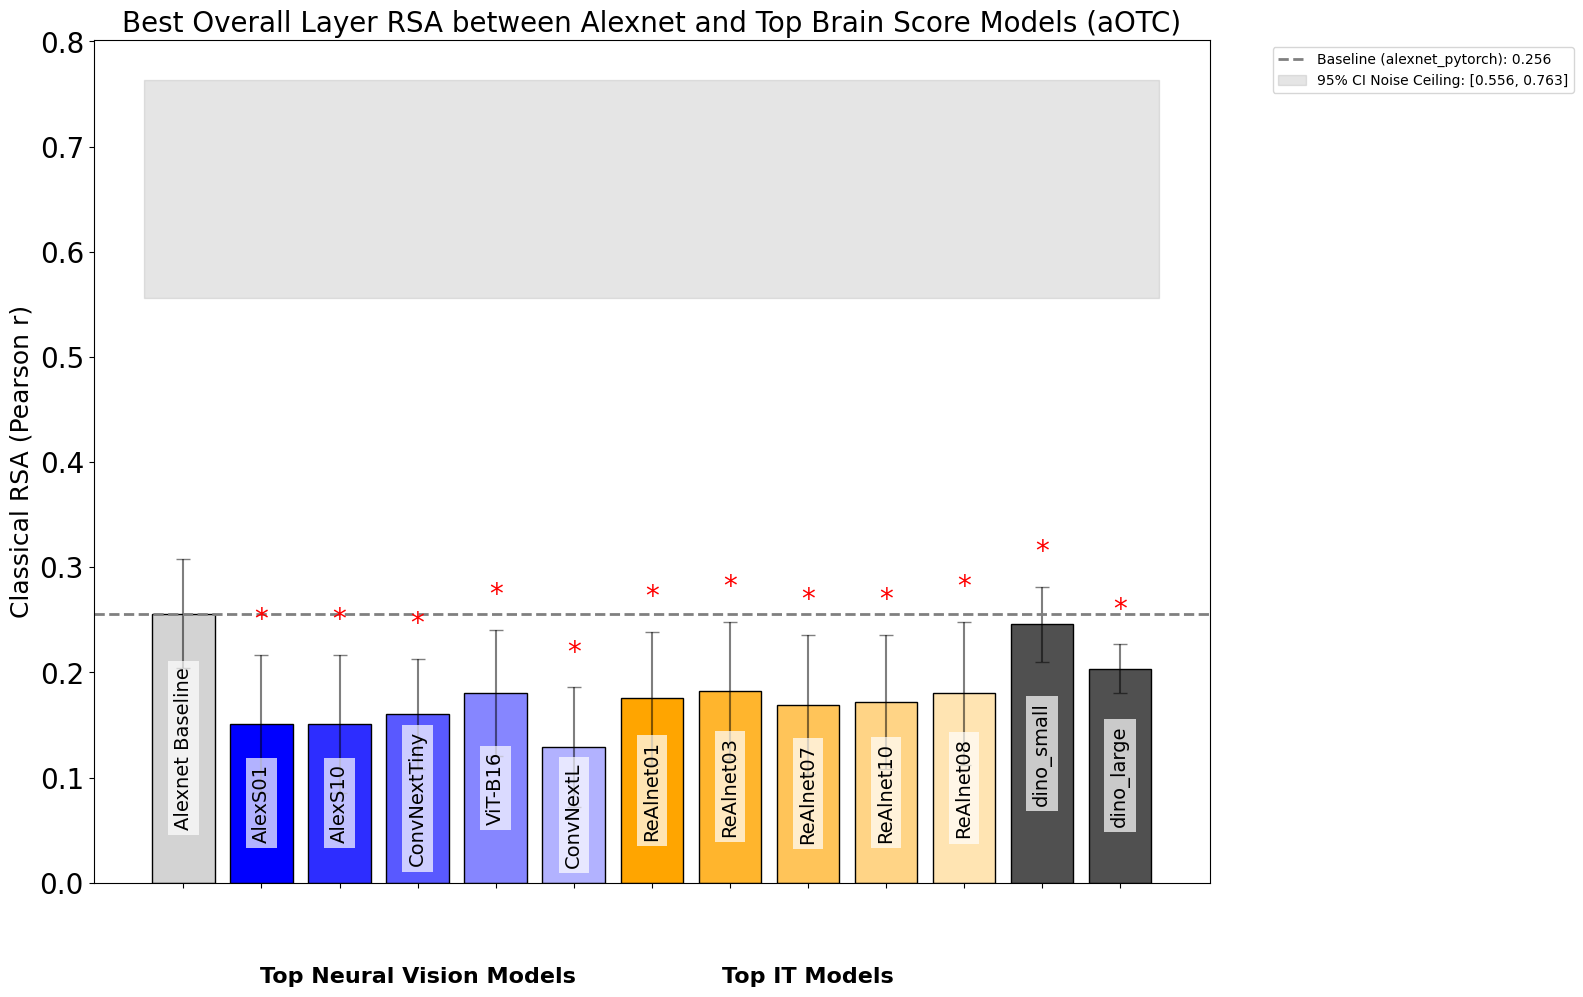

In [140]:
with open('reliable_roi_rdms/aOTC_reliable_rdms.pkl', 'rb') as file:
    aOTC_rdms = pickle.load(file)
aOTC_rdms_array = np.stack(aOTC_rdms)
# Short names
model_short_names = {
    #'Alexnet': "Alexnet Baseline",
    'alexnet_pytorch': "Alexnet Baseline",
    "1: convnext_large_mlp": "ConvNextL",
    "7: vit_relpos_base_patch16": "ViT-B16",
    "15: convnext_tiny_imagenet_full": "ConvNextTiny",
    "145: alexnet_training_seed_01": "AlexS01",
    "150: alexnet_training_seed_10": "AlexS10",
    "128: ReAlnet01_cornet": "ReAlnet01",
    "134: ReAlnet03_cornet": "ReAlnet03",
    "123: ReAlnet07_cornet": "ReAlnet07",
    "115: ReAlnet10_cornet:laion2b_ft_in1k": "ReAlnet10",
    "118: ReAlnet08_cornet: openai_ft_in1k": "ReAlnet08",
    "aOTC_dinov2": "dino_small"
  
}
# 4. PLOTTING THE BAR GRAPH
# ---------------------------
plt.figure(figsize=(16, 10))
x = np.arange(len(all_summaries))

# Use the newly assigned shaded colors from our DataFrame
bar_colors = all_summaries["shaded_color"].tolist()

# Draw the bars with error bars
plt.bar(x, all_summaries["group1_mean_corr"], color=bar_colors, edgecolor='k')
plt.errorbar(x, all_summaries["group1_mean_corr"],
             yerr=all_summaries["error"],
             fmt='none', ecolor='black', alpha=0.5, capsize=5)

# Plot baseline horizontal line
baseline_mean = all_summaries.loc[all_summaries["model"] == baseline, "group1_mean_corr"].iloc[0]
plt.axhline(baseline_mean, color='grey', linestyle='--', linewidth=2,
            label=f"Baseline ({baseline}): {baseline_mean:.3f}")

# Hide x-axis tick labels (we'll add our own short names on top of the bars)
plt.xticks(x, [""] * len(x))

# Place short names inside bars
for i, row in all_summaries.iterrows():
    model = row["model"]
    short_name = model_short_names.get(model, model)
    bar_height = row["group1_mean_corr"]
    # Place text within the bar (or just above if bar is very short)
    if bar_height > 0:
        y_pos = bar_height / 2
        text_color = "black"
    else:
        y_pos = bar_height - 0.02
        text_color = "black"
    plt.text(x[i], y_pos, short_name,
             ha='center', va='center', color=text_color,
             rotation=90, fontsize=14,
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Add stars if p < 0.05 for significance (one-sided)
for i, row in all_summaries.iterrows():
    model = row["model"]
    if model == baseline:
        continue
    p_val = significance.get(model, np.nan)
    if not np.isnan(p_val) and p_val < 0.05:
        y_val = row["group1_mean_corr"] + row["error"] + 0.02
        plt.text(x[i], y_val, "*", ha='center', va='bottom', color='red', fontsize=20)

# ---------------------------
# 5. ADD GROUP LABELS
# ---------------------------
# Example: If baseline is at index 0 and your groups are defined by order ranges:
#For Top Neural Models (orders 1-5)
neural_indices = np.arange(1, 6)
if len(neural_indices) > 0:
    neural_mid = neural_indices.mean()
    plt.text(neural_mid, -0.1, "Top Neural Vision Models",
             ha='center', va='top', fontsize=16, fontweight='bold',
             transform=plt.gca().get_xaxis_transform())

# For Top V1 Models (orders 6-10)
v1_indices = np.arange(6, 11)
if len(v1_indices) > 0:
    v1_mid = v1_indices.mean()
    plt.text(v1_mid, -0.1, "Top IT Models",
             ha='center', va='top', fontsize=16, fontweight='bold',
             transform=plt.gca().get_xaxis_transform())

# ---------------------------
# 6. ADD NOISE CEILING (OPTIONAL)
# ---------------------------
# (Assuming you have a function compute_noise_ceiling and the EarlyV_rdms_array loaded)
noise_results = compute_noise_ceiling(aOTC_rdms_array, num_splits=None)
noise_ceiling = noise_results["noise_ceiling"]
noise_ci_lower, noise_ci_upper = noise_results["ci"]

plt.fill_between(
    [-0.5, len(all_summaries)-0.5],
    noise_ci_lower,
    noise_ci_upper,
    color='grey', alpha=0.2,
    label=f"95% CI Noise Ceiling: [{noise_ci_lower:.3f}, {noise_ci_upper:.3f}]"
)

# Final plot adjustments
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 20)
plt.ylabel("Classical RSA (Pearson r)", fontsize=18)
plt.title("Best Overall Layer RSA between Alexnet and Top Brain Score Models (aOTC)", fontsize=20) # make ROI more flexible
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
#plt.tight_layout(rect=[0, 0.4, 1, 1])  # bottom=0.2
#plt.bar(-1, 0, color='white')  # or any dummy bar outside range

plt.show()

In [ ]:
# combined short names
model_short_names = {
    # Early V
    # 'alexnet_pytorch': "Alexnet Pytorch Baseline",
    "1: convnext_large_mlp": "ConvNextL",
    "7: vit_relpos_base_patch16": "ViT-B16",
    "15: convnext_tiny_imagenet_full": "ConvNextTiny",
    "145: alexnet_training_seed_01": "AlexS01",
    "150: alexnet_training_seed_10": "AlexS10",
    "151: alexnet_training_seed_07": "AlexS07",
    "163: alexnet_training_seed_09": "AlexS09",
    "166: alexnet_training_seed_02": "AlexS02",

    # pOTC
    # 'alexnet_pytorch': "Alexnet Pytorch Baseline",
    "1: convnext_large_mlp": "ConvNextL",
    "7: vit_relpos_base_patch16": "ViT-B16",
    "15: convnext_tiny_imagenet_full": "ConvNextTiny",
    "145: alexnet_training_seed_01": "AlexS01",
    "150: alexnet_training_seed_10": "AlexS10",
    "2: convnext_xlarge": "ConvNextXL",
    "69: efficientnet_b2_imagenet_full": "Efficientnetb2",
    "39: cvt_cvt-21-384-in1k_4_LucyV4": "Cvt21",

    # aOTC
    'alexnet_pytorch': "Alexnet Baseline",
    "1: convnext_large_mlp": "ConvNextL",
    "7: vit_relpos_base_patch16": "ViT-B16",
    "15: convnext_tiny_imagenet_full": "ConvNextTiny",
    "145: alexnet_training_seed_01": "AlexS01",
    "150: alexnet_training_seed_10": "AlexS10",
    "128: ReAlnet01_cornet": "ReAlnet01",
    "134: ReAlnet03_cornet": "ReAlnet03",
    "123: ReAlnet07_cornet": "ReAlnet07",
    "115: ReAlnet10_cornet:laion2b_ft_in1k": "ReAlnet10",
    "118: ReAlnet08_cornet: openai_ft_in1k": "ReAlnet08",
    "aOTC_dinov2": "dino_small"
    
}

# 4. PLOTTING THE BAR GRAPH
# ---------------------------
plt.figure(figsize=(14, 10))
x = np.arange(len(all_summaries))

# Use the newly assigned shaded colors from our DataFrame
bar_colors = all_summaries["shaded_color"].tolist()

# Draw the bars with error bars
plt.bar(x, all_summaries["group1_mean_corr"], color=bar_colors, edgecolor='k')
plt.errorbar(x, all_summaries["group1_mean_corr"],
             yerr=all_summaries["error"],
             fmt='none', ecolor='black', alpha=0.5, capsize=5)

# Plot baseline horizontal line
baseline_mean = all_summaries.loc[all_summaries["model"] == baseline, "group1_mean_corr"].iloc[0]
plt.axhline(baseline_mean, color='grey', linestyle='--', linewidth=2,
            label=f"Baseline ({baseline}): {baseline_mean:.3f}")

# Hide x-axis tick labels (we'll add our own short names on top of the bars)
plt.xticks(x, [""] * len(x))

# Place short names inside bars
for i, row in all_summaries.iterrows():
    model = row["model"]
    short_name = model_short_names.get(model, model)
    bar_height = row["group1_mean_corr"]
    # Place text within the bar (or just above if bar is very short)
    if bar_height > 0:
        y_pos = bar_height / 2
        text_color = "black"
    else:
        y_pos = bar_height - 0.02
        text_color = "black"
    plt.text(x[i], y_pos, short_name,
             ha='center', va='center', color=text_color,
             rotation=90, fontsize=14,
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Add stars if p < 0.05 for significance (one-sided)
for i, row in all_summaries.iterrows():
    model = row["model"]
    if model == baseline:
        continue
    p_val = significance.get(model, np.nan)
    if not np.isnan(p_val) and p_val < 0.05:
        y_val = row["group1_mean_corr"] + row["error"] + 0.02
        plt.text(x[i], y_val, "*", ha='center', va='bottom', color='red', fontsize=20)

# ---------------------------
# 5. ADD GROUP LABELS
# ---------------------------
# Example: If baseline is at index 0 and your groups are defined by order ranges:
# # For Top Neural Models (orders 1-5)
# neural_indices = np.arange(1, 6)
# if len(neural_indices) > 0:
#     neural_mid = neural_indices.mean()
#     plt.text(neural_mid, -0.1, "Top Neural Vision Models",
#              ha='center', va='top', fontsize=16, fontweight='bold',
#              transform=plt.gca().get_xaxis_transform())

# # For Top V1 Models (orders 6-10)
# v1_indices = np.arange(6, 11)
# if len(v1_indices) > 0:
#     v1_mid = v1_indices.mean()
#     plt.text(v1_mid, -0.1, "Top IT Models",
#              ha='center', va='top', fontsize=16, fontweight='bold',
#              transform=plt.gca().get_xaxis_transform())

# # ---------------------------
# 6. ADD NOISE CEILING (OPTIONAL)
# ---------------------------
# (Assuming you have a function compute_noise_ceiling and the EarlyV_rdms_array loaded)
noise_results = compute_noise_ceiling(EarlyV_rdms_array, num_splits=None)
noise_ceiling = noise_results["noise_ceiling"]
noise_ci_lower, noise_ci_upper = noise_results["ci"]

plt.fill_between(
    [-0.5, len(all_summaries)-0.5],
    noise_ci_lower,
    noise_ci_upper,
    color='grey', alpha=0.2,
    label=f"95% CI Noise Ceiling: [{noise_ci_lower:.3f}, {noise_ci_upper:.3f}]"
)

# Final plot adjustments
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Classical RSA (Pearson r)", fontsize=16)
plt.title("Best Overall Layer RSA between Alexnet and Top Brain Score Models (pOTC)", fontsize=18) # make ROI more flexible
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# start of vertically stacked plots

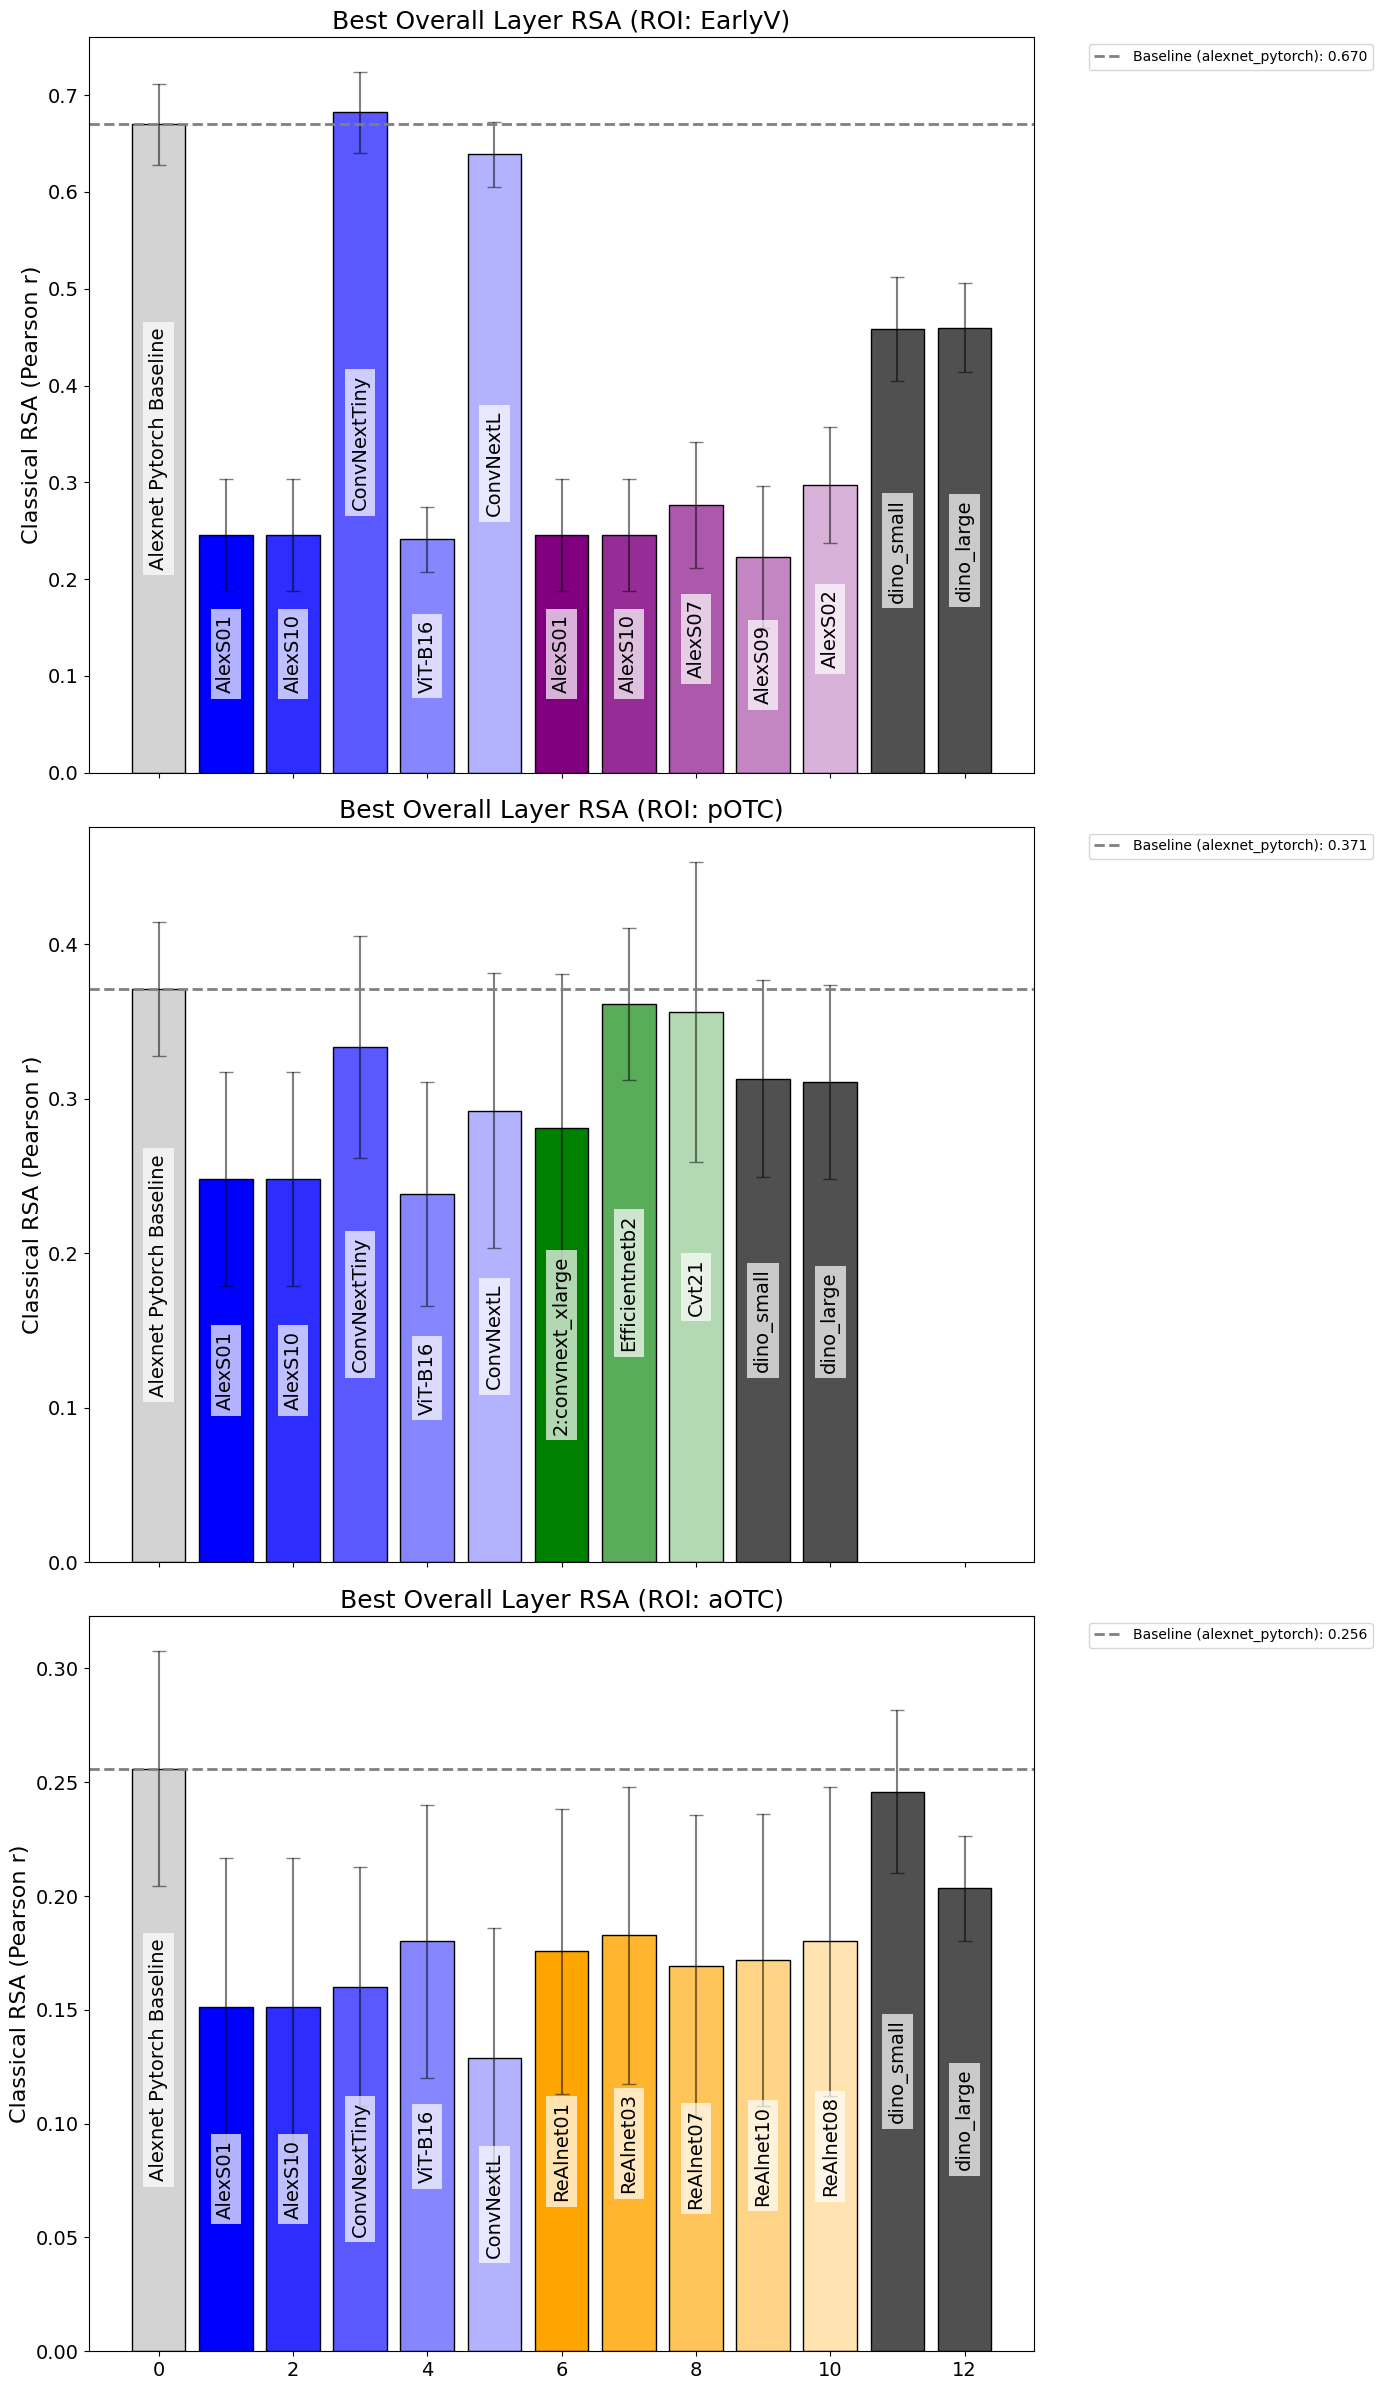

In [113]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define a mapping from ROI name to its corresponding CSV file.
roi_files = {
    "EarlyV": os.path.join("barplot_summaries_roi", "EarlyV_summary_with_categories.csv"),
    "pOTC": os.path.join("barplot_summaries_roi", "pOTC_summary_with_categories.csv"),
    "aOTC": os.path.join("barplot_summaries_roi", "aOTC_summary_with_categories.csv")
}

# Define your shared model short names dictionary.
model_short_names = {
    'alexnet_pytorch': "Alexnet Pytorch Baseline",
    "1: convnext_large_mlp": "ConvNextL",
    "7: vit_relpos_base_patch16": "ViT-B16",
    "15: convnext_tiny_imagenet_full": "ConvNextTiny",
    "145: alexnet_training_seed_01": "AlexS01",
    "150: alexnet_training_seed_10": "AlexS10",
    "151: alexnet_training_seed_07": "AlexS07",
    "163: alexnet_training_seed_09": "AlexS09",
    "166: alexnet_training_seed_02": "AlexS02",
    "2: convnext_xlarge": "ConvNextXL",
    "69: efficientnet_b2_imagenet_full": "Efficientnetb2",
    "39: cvt_cvt-21-384-in1k_4_LucyV4": "Cvt21",
    "128: ReAlnet01_cornet": "ReAlnet01",
    "134: ReAlnet03_cornet": "ReAlnet03",
    "123: ReAlnet07_cornet": "ReAlnet07",
    "115: ReAlnet10_cornet:laion2b_ft_in1k": "ReAlnet10",
    "118: ReAlnet08_cornet: openai_ft_in1k": "ReAlnet08",
    "aOTC_dinov2": "dino_small"
}

# We'll create one figure with a subplot per ROI.
n_rois = len(roi_files)
fig, axs = plt.subplots(nrows=n_rois, ncols=1,
                        figsize=(14, 8 * n_rois),
                        sharex=True)  # share the x-axis if desired

# If you have only one ROI, ensure axs is iterable.
if n_rois == 1:
    axs = [axs]

# Loop through each ROI and plot its data.
for ax, (roi, csv_path) in zip(axs, roi_files.items()):
    # Load the CSV file for the ROI.
    df = pd.read_csv(csv_path)
    x = np.arange(len(df))
    
    # Grab bar colors from the precomputed "shaded_color" column.
    bar_colors = df["shaded_color"].tolist()
    
    # Draw bars with error bars.
    ax.bar(x, df["group1_mean_corr"], color=bar_colors, edgecolor='k')
    ax.errorbar(x, df["group1_mean_corr"],
                yerr=df["error"],
                fmt='none', ecolor='black', alpha=0.5, capsize=5)
    
    # (Optional) Plot the baseline horizontal line if the baseline model is present.
    baseline = "alexnet_pytorch"
    if baseline in df["model"].values:
        baseline_mean = df.loc[df["model"] == baseline, "group1_mean_corr"].iloc[0]
        ax.axhline(baseline_mean, color='grey', linestyle='--', linewidth=2,
                   label=f"Baseline ({baseline}): {baseline_mean:.3f}")
    
    # Place short model names inside bars.
    for i, row in df.iterrows():
        model = row["model"]
        # Look up the short name; if not found, use the model name.
        short_name = model_short_names.get(model, model)
        bar_height = row["group1_mean_corr"]
        # Adjust y-position so the text is centered (or slightly above for very short bars)
        if bar_height > 0:
            y_pos = bar_height / 2
        else:
            y_pos = bar_height - 0.02
        ax.text(x[i], y_pos, short_name,
                ha='center', va='center', color='black',
                rotation=90, fontsize=14,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    
    # (Optional) Add significance stars if you have a significance dictionary.
    # For example:
    # for i, row in df.iterrows():
    #     model = row["model"]
    #     if model == baseline:
    #         continue
    #     p_val = significance.get(model, np.nan)
    #     if not np.isnan(p_val) and p_val < 0.05:
    #         y_val = row["group1_mean_corr"] + row["error"] + 0.02
    #         ax.text(x[i], y_val, "*", ha='center', va='bottom', color='red', fontsize=20)
    
    # Add group labels if desired (e.g., based on order ranges).
    # (This depends on your grouping logic.)
    
    # Set the title to include the current ROI.
    ax.set_title(f"Best Overall Layer RSA (ROI: {roi})", fontsize=18)
    ax.set_ylabel("Classical RSA (Pearson r)", fontsize=16)
    ax.tick_params(axis="both", labelsize=14)
    
    # Put the legend outside the plot area.
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")



plt.tight_layout()
plt.show()


Loaded EarlyV data from: barplot_summaries_roi/EarlyV_summary_with_categories.csv
Loaded pOTC data from: barplot_summaries_roi/pOTC_summary_with_categories.csv
Loaded aOTC data from: barplot_summaries_roi/aOTC_summary_with_categories.csv


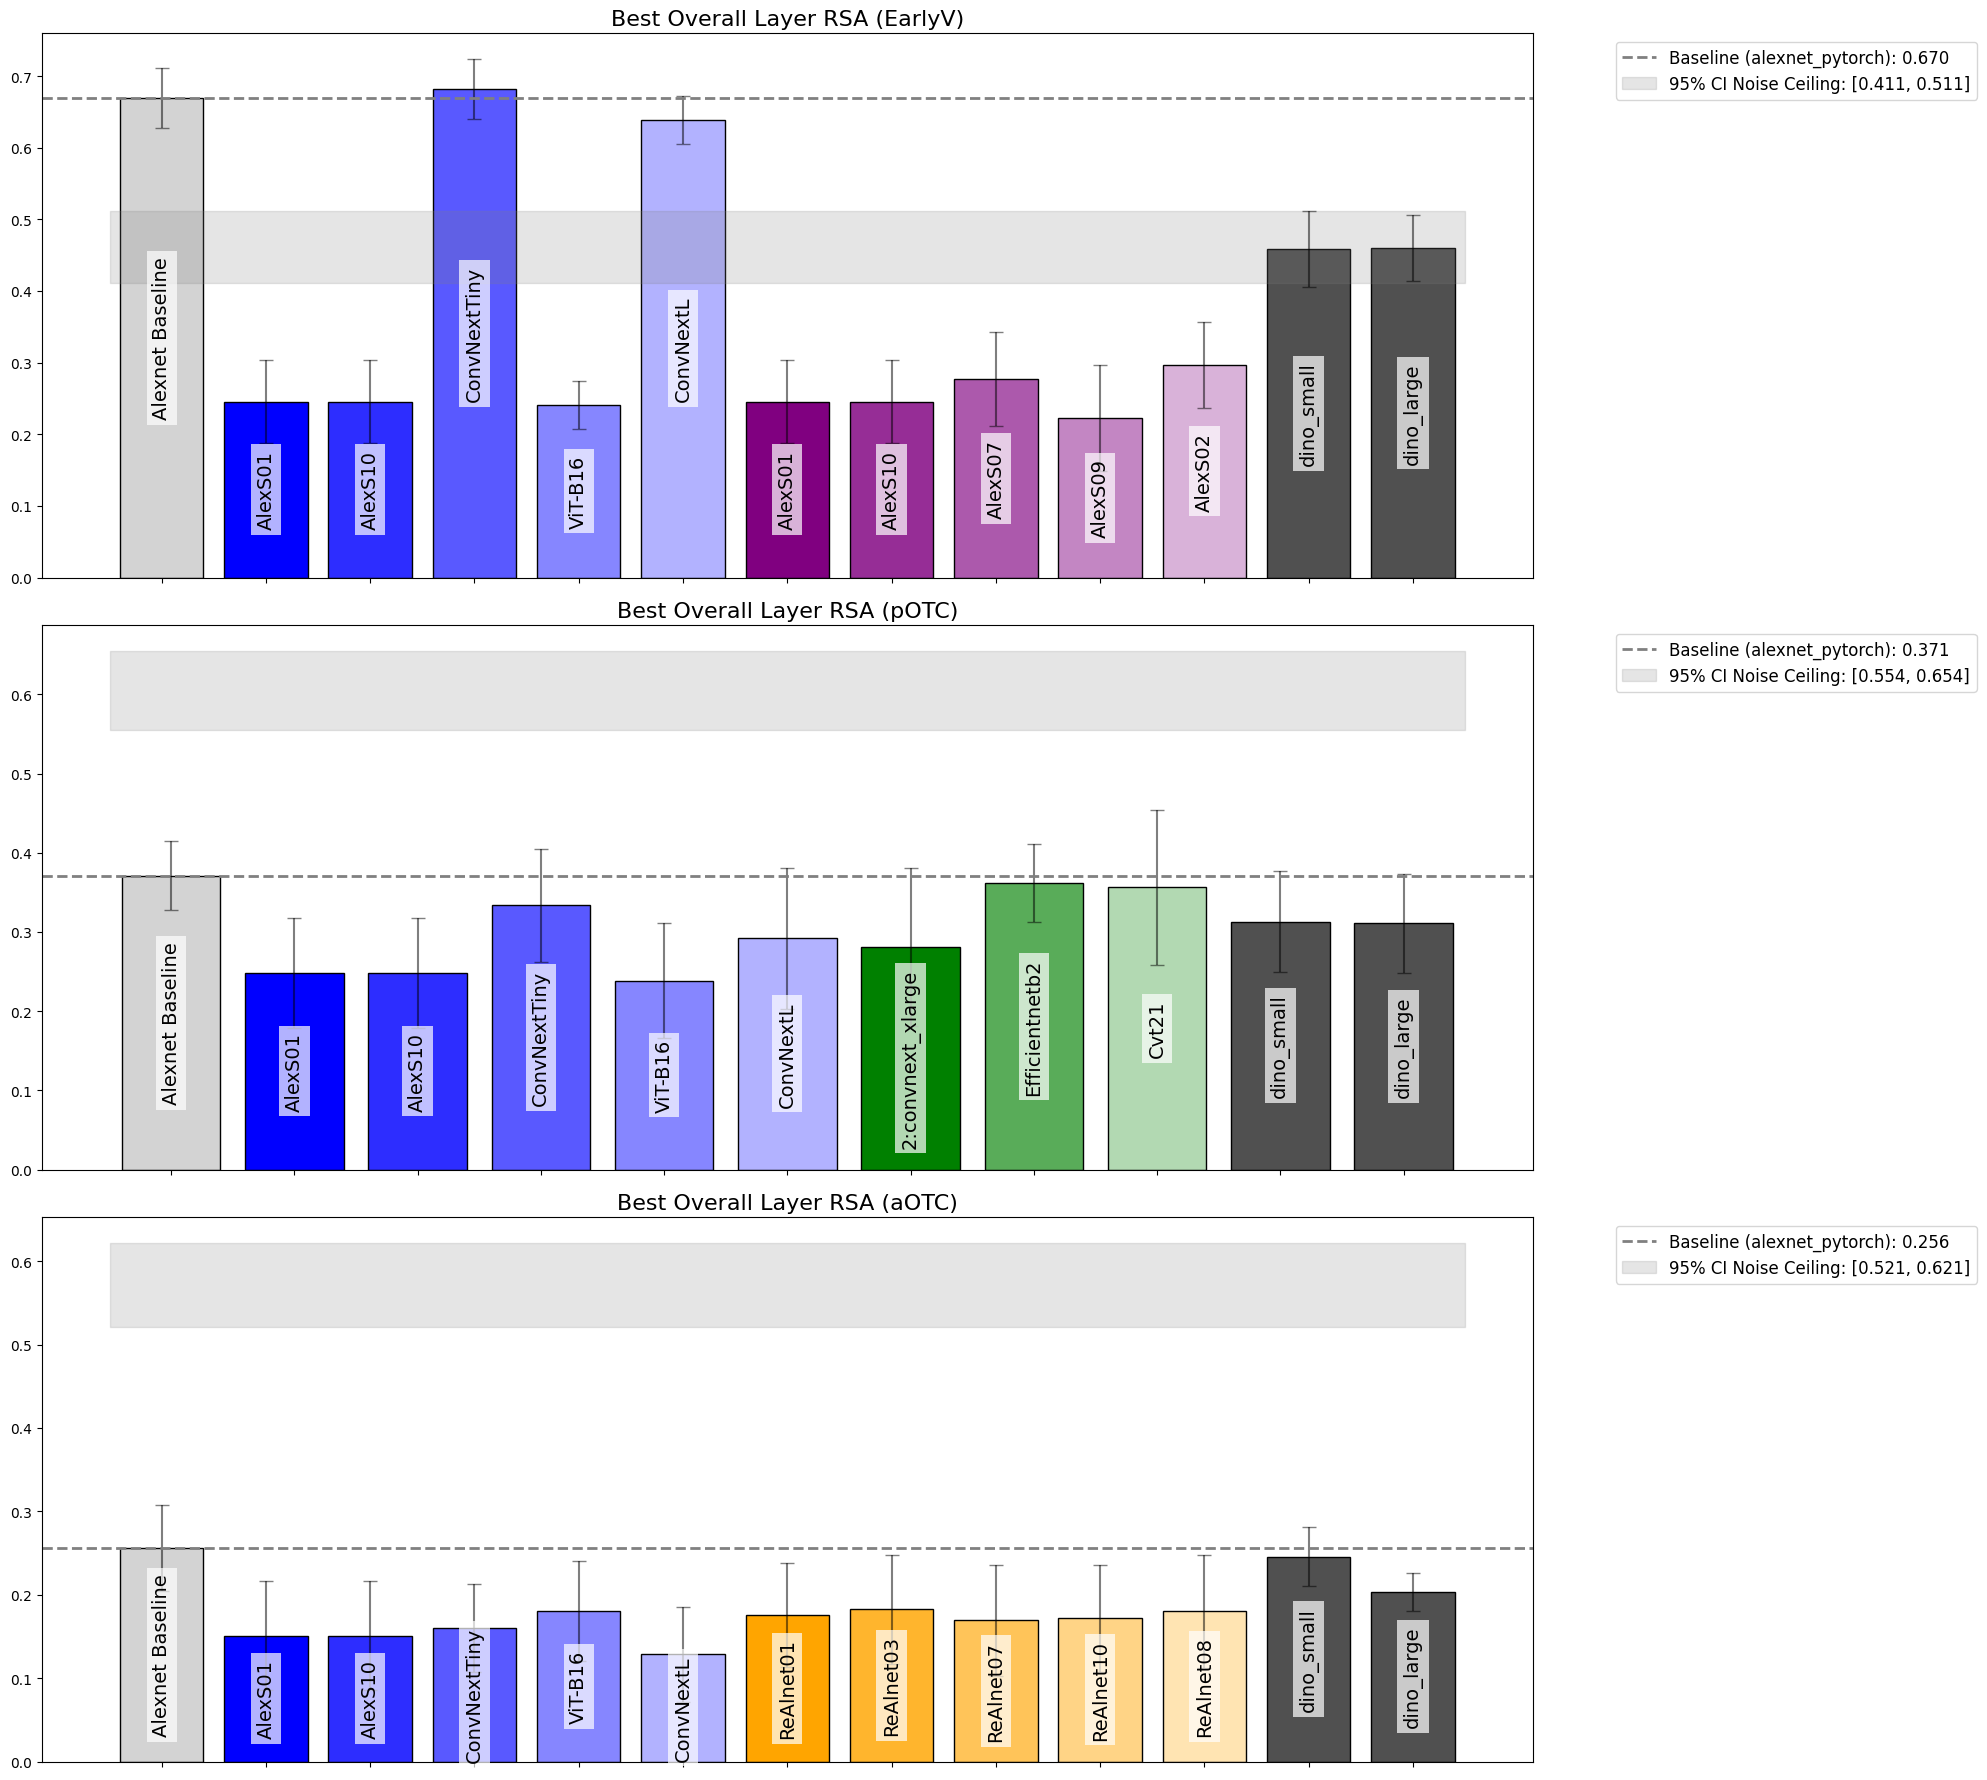

In [114]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy.stats import ttest_rel  # if needed for significance

# --- Example: load your RDMs (if needed later) ---
with open('reliable_roi_rdms/EarlyV_reliable_rdms.pkl', 'rb') as file:
    EarlyV_rdms = pickle.load(file)
EarlyV_rdms_array = np.stack(EarlyV_rdms)

with open('reliable_roi_rdms/pOTC_reliable_rdms.pkl', 'rb') as file:
    pOTC_rdms = pickle.load(file)
pOTC_rdms_array = np.stack(pOTC_rdms)

with open('reliable_roi_rdms/aOTC_reliable_rdms.pkl', 'rb') as file:
    aOTC_rdms = pickle.load(file)
aOTC_rdms_array = np.stack(aOTC_rdms)

# --- Define a mapping from ROI name to its corresponding CSV file ---
roi_files = {
    "EarlyV": os.path.join("barplot_summaries_roi", "EarlyV_summary_with_categories.csv"),
    "pOTC": os.path.join("barplot_summaries_roi", "pOTC_summary_with_categories.csv"),
    "aOTC": os.path.join("barplot_summaries_roi", "aOTC_summary_with_categories.csv")
}

# Combined short names dictionary (you can extend or modify it as needed)
model_short_names = {
    'alexnet_pytorch': "Alexnet Baseline",
    "1: convnext_large_mlp": "ConvNextL",
    "7: vit_relpos_base_patch16": "ViT-B16",
    "15: convnext_tiny_imagenet_full": "ConvNextTiny",
    "145: alexnet_training_seed_01": "AlexS01",
    "150: alexnet_training_seed_10": "AlexS10",
    "151: alexnet_training_seed_07": "AlexS07",
    "163: alexnet_training_seed_09": "AlexS09",
    "166: alexnet_training_seed_02": "AlexS02",
    "2: convnext_xlarge": "ConvNextXL",
    "69: efficientnet_b2_imagenet_full": "Efficientnetb2",
    "39: cvt_cvt-21-384-in1k_4_LucyV4": "Cvt21",
    "128: ReAlnet01_cornet": "ReAlnet01",
    "134: ReAlnet03_cornet": "ReAlnet03",
    "123: ReAlnet07_cornet": "ReAlnet07",
    "115: ReAlnet10_cornet:laion2b_ft_in1k": "ReAlnet10",
    "118: ReAlnet08_cornet: openai_ft_in1k": "ReAlnet08",
    "aOTC_dinov2": "dino_small"
}

# If you already computed significance values and stored them in your CSV (or later in another file),
# you can load them too. For flexibility, you may choose to recompute them here if you also saved/load
# an 'intermediates_data' dictionary. Otherwise, if you are simply plotting the CSV summaries,
# you might omit significance stars (or have pre-saved significance values as a column).

# Here, we assume that the CSV already contains all columns needed (including "shaded_color").
# If not, make sure to run your assign_shade_colors() function and save the result prior to plotting.

# Determine the number of ROIs:
rois = list(roi_files.keys())
n_rois = len(rois)

# Create a figure with vertically stacked subplots.
fig, axes = plt.subplots(n_rois, 1, figsize=(20, 6*n_rois), sharex=False)

# If there is only one ROI, put the axes in a list for consistency.
if n_rois == 1:
    axes = [axes]

# Loop over ROIs and plot each one.
for ax, roi in zip(axes, rois):
    # Load the CSV for this ROI.
    csv_path = roi_files[roi]
    df = pd.read_csv(csv_path)
    print(f"Loaded {roi} data from: {csv_path}")
    
    # Prepare x-axis positions.
    x = np.arange(len(df))
    
    # Retrieve the pre-assigned shaded colors.
    bar_colors = df["shaded_color"].tolist()
    
    # Plot the bars with error bars.
    ax.bar(x, df["group1_mean_corr"], color=bar_colors, edgecolor='k')
    ax.errorbar(x, df["group1_mean_corr"],
                yerr=df["error"],
                fmt='none', ecolor='black', alpha=0.5, capsize=5)
    
    # Plot the baseline horizontal line.
    baseline = "alexnet_pytorch"
    if baseline in df["model"].values:
        baseline_mean = df.loc[df["model"] == baseline, "group1_mean_corr"].iloc[0]
        ax.axhline(baseline_mean, color='grey', linestyle='--', linewidth=2,
                   label=f"Baseline ({baseline}): {baseline_mean:.3f}")
    
    # (Optionally) Add significance stars.
    # If you have a "significance" column saved in df, you can use it.
    # Otherwise, if significance is not stored, you might skip this block or add your own logic.
    # For demonstration, if you have an external significance dictionary for this ROI, you would do:
    # for i, row in df.iterrows():
    #     model = row["model"]
    #     if model == baseline:
    #         continue
    #     p_val = significance.get(model, np.nan)
    #     if not np.isnan(p_val) and p_val < 0.05:
    #         y_val = row["group1_mean_corr"] + row["error"] + 0.02
    #         ax.text(x[i], y_val, "*", ha='center', va='bottom', color='red', fontsize=20)
    
    # Place model short names inside or on top of the bars.
    for i, row in df.iterrows():
        model = row["model"]
        short_name = model_short_names.get(model, model)
        bar_height = row["group1_mean_corr"]
        # Adjust y-position depending on bar height.
        y_pos = bar_height / 2 if bar_height > 0 else bar_height - 0.02
        ax.text(x[i], y_pos, short_name,
                ha='center', va='center', color='black',
                rotation=90, fontsize=14,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    
    # Plot noise ceiling if desired.
    # Here we assume you want the same noise ceiling for all ROIs.
    # You can switch among EarlyV_rdms_array, pOTC_rdms_array, or aOTC_rdms_array based on the ROI.
    if roi == "EarlyV":
        rdms_array = EarlyV_rdms_array
    elif roi == "pOTC":
        rdms_array = pOTC_rdms_array
    elif roi == "aOTC":
        rdms_array = aOTC_rdms_array
    else:
        rdms_array = EarlyV_rdms_array  # default
    
    # Compute noise ceiling with your function (assumed to be defined elsewhere).
    noise_results = compute_noise_ceiling(rdms_array, num_splits=None)
    noise_ceiling = noise_results["noise_ceiling"]
    noise_ci_lower, noise_ci_upper = noise_results["ci"]
    ax.fill_between(
        [-0.5, len(df)-0.5],
        noise_ci_lower,
        noise_ci_upper,
        color='grey', alpha=0.2,
        label=f"95% CI Noise Ceiling: [{noise_ci_lower:.3f}, {noise_ci_upper:.3f}]"
    )
    
    # Set title that incorporates the ROI name.
    ax.set_title(f"Best Overall Layer RSA ({roi})", fontsize=16)
    
    # Optionally, set custom x-tick labels (for example, leave empty or set model indices).
    ax.set_xticks(x)
    # Here you can later update the tick labels if desired.
    ax.set_xticklabels([""] * len(x), fontsize=14)
    
    # Place the legend outside the plot area.
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=12)

# Adjust layout so that subplots do not overlap.
plt.tight_layout()
plt.show()


Loaded EarlyV data from: barplot_summaries_roi/EarlyV_summary_with_categories.csv
Loaded pOTC data from: barplot_summaries_roi/pOTC_summary_with_categories.csv
Loaded aOTC data from: barplot_summaries_roi/aOTC_summary_with_categories.csv


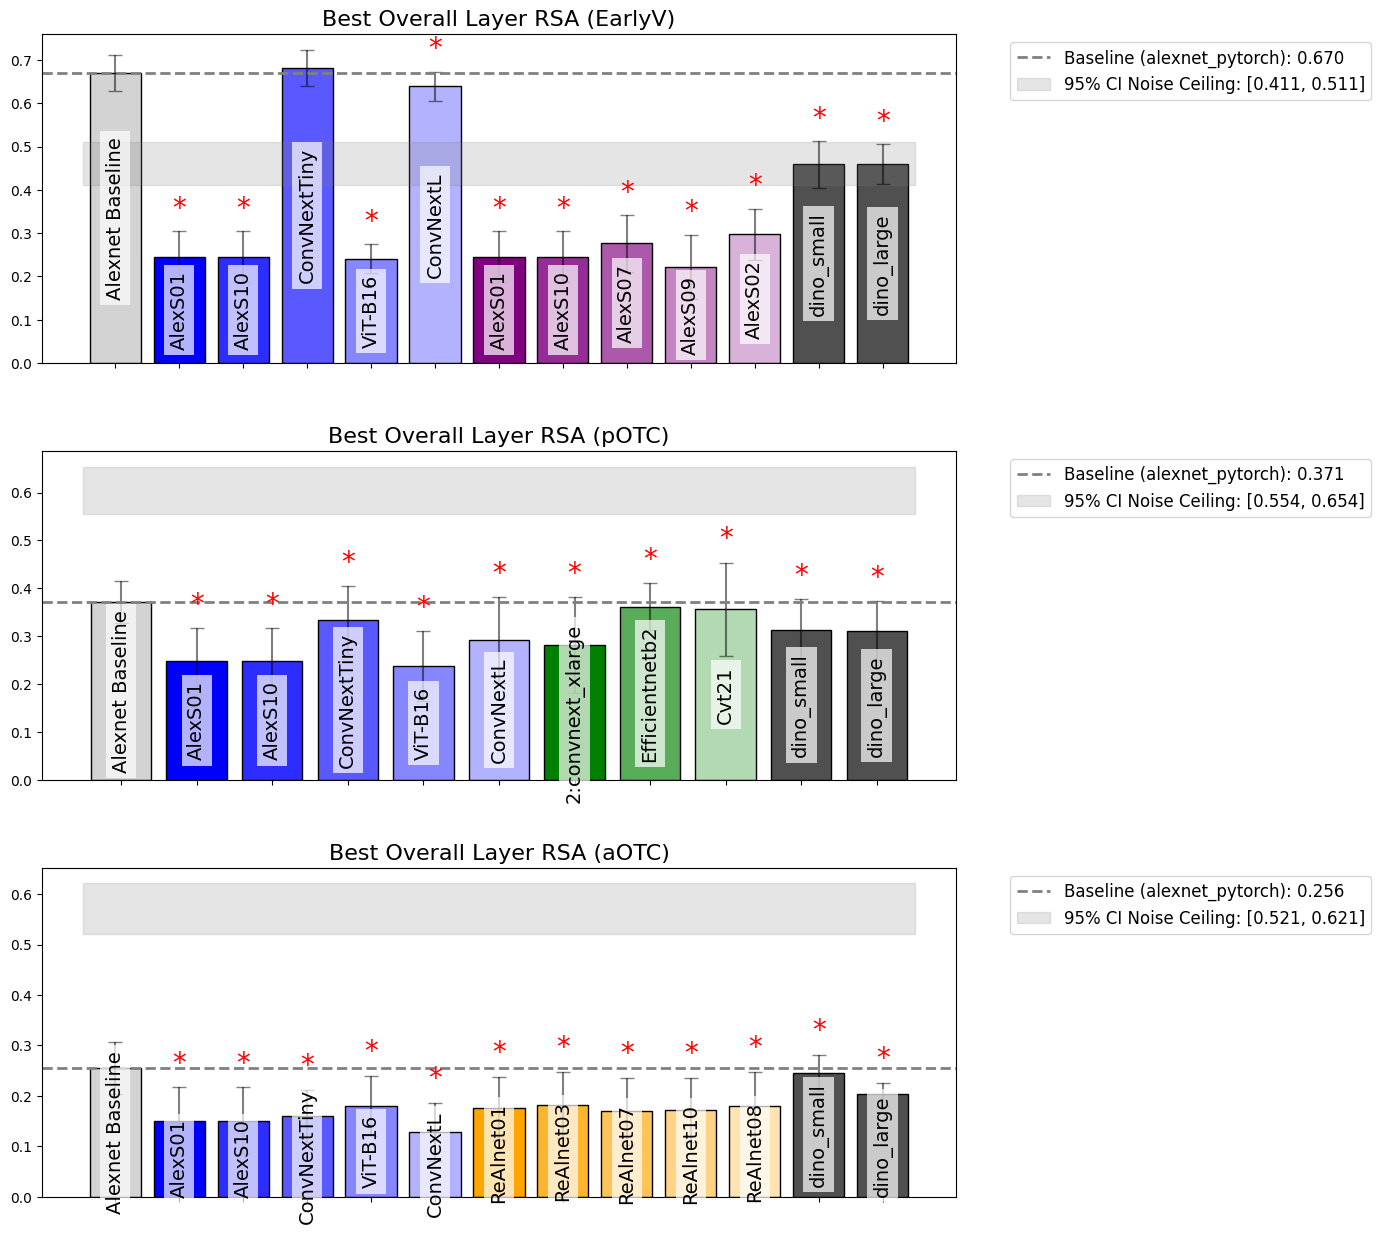

In [115]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# --- Load RDMs (if needed for noise ceiling) ---
with open('reliable_roi_rdms/EarlyV_reliable_rdms.pkl', 'rb') as file:
    EarlyV_rdms = pickle.load(file)
EarlyV_rdms_array = np.stack(EarlyV_rdms)

with open('reliable_roi_rdms/pOTC_reliable_rdms.pkl', 'rb') as file:
    pOTC_rdms = pickle.load(file)
pOTC_rdms_array = np.stack(pOTC_rdms)

with open('reliable_roi_rdms/aOTC_reliable_rdms.pkl', 'rb') as file:
    aOTC_rdms = pickle.load(file)
aOTC_rdms_array = np.stack(aOTC_rdms)

# --- Define a mapping from ROI name to its corresponding CSV file ---
roi_files = {
    "EarlyV": os.path.join("barplot_summaries_roi", "EarlyV_summary_with_categories.csv"),
    "pOTC": os.path.join("barplot_summaries_roi", "pOTC_summary_with_categories.csv"),
    "aOTC": os.path.join("barplot_summaries_roi", "aOTC_summary_with_categories.csv")
}

# Combined short names dictionary (update as needed)
model_short_names = {
    'alexnet_pytorch': "Alexnet Baseline",
    "1: convnext_large_mlp": "ConvNextL",
    "7: vit_relpos_base_patch16": "ViT-B16",
    "15: convnext_tiny_imagenet_full": "ConvNextTiny",
    "145: alexnet_training_seed_01": "AlexS01",
    "150: alexnet_training_seed_10": "AlexS10",
    "151: alexnet_training_seed_07": "AlexS07",
    "163: alexnet_training_seed_09": "AlexS09",
    "166: alexnet_training_seed_02": "AlexS02",
    "2: convnext_xlarge": "ConvNextXL",
    "69: efficientnet_b2_imagenet_full": "Efficientnetb2",
    "39: cvt_cvt-21-384-in1k_4_LucyV4": "Cvt21",
    "128: ReAlnet01_cornet": "ReAlnet01",
    "134: ReAlnet03_cornet": "ReAlnet03",
    "123: ReAlnet07_cornet": "ReAlnet07",
    "115: ReAlnet10_cornet:laion2b_ft_in1k": "ReAlnet10",
    "118: ReAlnet08_cornet: openai_ft_in1k": "ReAlnet08",
    "aOTC_dinov2": "dino_small"
}

# --- Create a figure with vertically stacked subplots for each ROI ---
rois = list(roi_files.keys())
n_rois = len(rois)

# Create figure and axes with extra bottom margin
fig, axes = plt.subplots(n_rois, 1, figsize=(14, 6 * n_rois))
plt.subplots_adjust(bottom=0.5)  # Increase bottom margin for later custom x-axis labels

# Ensure axes is a list (even when there's only one ROI)
if n_rois == 1:
    axes = [axes]

# Loop over each ROI
for ax, roi in zip(axes, rois):
    # Load the CSV summary for this ROI.
    csv_path = roi_files[roi]
    df = pd.read_csv(csv_path)
    print(f"Loaded {roi} data from: {csv_path}")

    # Prepare x positions.
    x = np.arange(len(df))
    
    # Retrieve pre-assigned shaded colors.
    bar_colors = df["shaded_color"].tolist()
    
    # Draw the bars and error bars.
    ax.bar(x, df["group1_mean_corr"], color=bar_colors, edgecolor='k')
    ax.errorbar(x, df["group1_mean_corr"],
                yerr=df["error"],
                fmt='none', ecolor='black', alpha=0.5, capsize=5)
    
    # Plot the baseline horizontal line (if baseline model exists).
    baseline = "alexnet_pytorch"
    if baseline in df["model"].values:
        baseline_mean = df.loc[df["model"] == baseline, "group1_mean_corr"].iloc[0]
        ax.axhline(baseline_mean, color='grey', linestyle='--', linewidth=2,
                   label=f"Baseline ({baseline}): {baseline_mean:.3f}")
    
    # --- Add significance stars using the "significance" column ---
    for i, row in df.iterrows():
        model = row["model"]
        if model == baseline:
            continue
        p_val = row["significance"]  # p-value saved in the CSV
        if p_val < 0.05:
            y_val = row["group1_mean_corr"] + row["error"] + 0.02
            ax.text(x[i], y_val, "*", ha='center', va='bottom', color='red', fontsize=20)
    
    # Place model short names inside or on top of each bar.
    for i, row in df.iterrows():
        model = row["model"]
        short_name = model_short_names.get(model, model)
        
        bar_height = row["group1_mean_corr"]
        # Adjust y position based on bar height.
        y_pos = bar_height / 2 if bar_height > 0 else bar_height - 0.02
        ax.text(x[i], y_pos, short_name,
                ha='center', va='center', color='black',
                rotation=90, fontsize=14,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    
    # --- Plot noise ceiling ---
    if roi == "EarlyV":
        rdms_array = EarlyV_rdms_array
    elif roi == "pOTC":
        rdms_array = pOTC_rdms_array
    elif roi == "aOTC":
        rdms_array = aOTC_rdms_array
    else:
        rdms_array = EarlyV_rdms_array  # default
    # Compute noise ceiling using your defined function.
    noise_results = compute_noise_ceiling(rdms_array, num_splits=None)
    noise_ceiling = noise_results["noise_ceiling"]
    noise_ci_lower, noise_ci_upper = noise_results["ci"]
    ax.fill_between(
        [-0.5, len(df)-0.5],
        noise_ci_lower,
        noise_ci_upper,
        color='grey', alpha=0.2,
        label=f"95% CI Noise Ceiling: [{noise_ci_lower:.3f}, {noise_ci_upper:.3f}]"
    )
    
    # Set the title (with the ROI name) and other axis settings.
    ax.set_title(f"Best Overall Layer RSA ({roi})", fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels([""] * len(x), fontsize=14)
    
    # Place the legend outside the plot area.
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=12)

# Adjust layout so subplots do not overlap.
plt.tight_layout(rect=[0, 0.3, 1, 1])
plt.show()


Loaded EarlyV data from: barplot_summaries_roi/EarlyV_summary_with_categories.csv
Loaded pOTC data from: barplot_summaries_roi/pOTC_summary_with_categories.csv
Loaded aOTC data from: barplot_summaries_roi/aOTC_summary_with_categories.csv


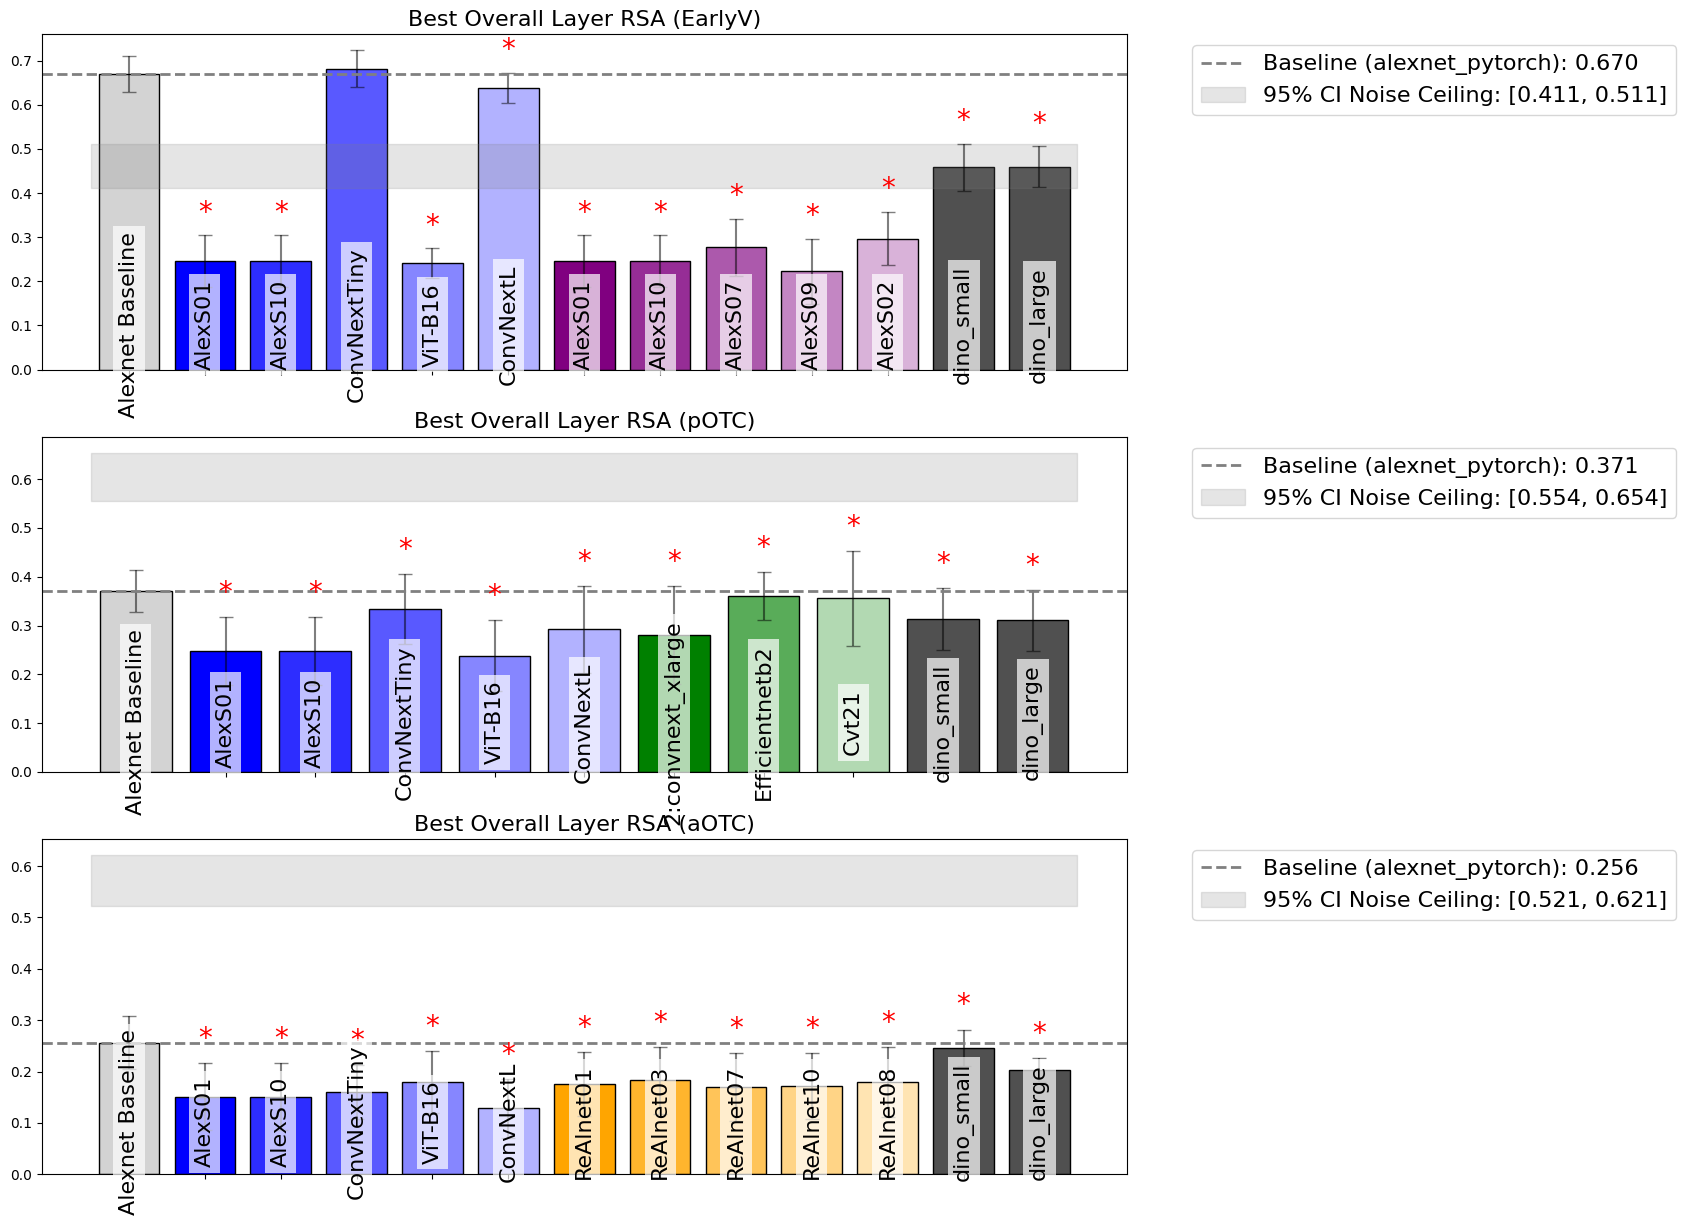

In [116]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# --- Load RDMs (if needed for noise ceiling) ---
with open('reliable_roi_rdms/EarlyV_reliable_rdms.pkl', 'rb') as file:
    EarlyV_rdms = pickle.load(file)
EarlyV_rdms_array = np.stack(EarlyV_rdms)

with open('reliable_roi_rdms/pOTC_reliable_rdms.pkl', 'rb') as file:
    pOTC_rdms = pickle.load(file)
pOTC_rdms_array = np.stack(pOTC_rdms)

with open('reliable_roi_rdms/aOTC_reliable_rdms.pkl', 'rb') as file:
    aOTC_rdms = pickle.load(file)
aOTC_rdms_array = np.stack(aOTC_rdms)

# --- Define a mapping from ROI name to its corresponding CSV file ---
roi_files = {
    "EarlyV": os.path.join("barplot_summaries_roi", "EarlyV_summary_with_categories.csv"),
    "pOTC": os.path.join("barplot_summaries_roi", "pOTC_summary_with_categories.csv"),
    "aOTC": os.path.join("barplot_summaries_roi", "aOTC_summary_with_categories.csv")
}

# Combined short names dictionary (update as needed)
model_short_names = {
    'alexnet_pytorch': "Alexnet Baseline",
    "1: convnext_large_mlp": "ConvNextL",
    "7: vit_relpos_base_patch16": "ViT-B16",
    "15: convnext_tiny_imagenet_full": "ConvNextTiny",
    "145: alexnet_training_seed_01": "AlexS01",
    "150: alexnet_training_seed_10": "AlexS10",
    "151: alexnet_training_seed_07": "AlexS07",
    "163: alexnet_training_seed_09": "AlexS09",
    "166: alexnet_training_seed_02": "AlexS02",
    "2: convnext_xlarge": "ConvNextXL",
    "69: efficientnet_b2_imagenet_full": "Efficientnetb2",
    "39: cvt_cvt-21-384-in1k_4_LucyV4": "Cvt21",
    "128: ReAlnet01_cornet": "ReAlnet01",
    "134: ReAlnet03_cornet": "ReAlnet03",
    "123: ReAlnet07_cornet": "ReAlnet07",
    "115: ReAlnet10_cornet:laion2b_ft_in1k": "ReAlnet10",
    "118: ReAlnet08_cornet: openai_ft_in1k": "ReAlnet08",
    "aOTC_dinov2": "dino_small"
}

# --- Create a figure with vertically stacked subplots for each ROI ---
rois = list(roi_files.keys())
n_rois = len(rois)

# Create figure and axes with extra bottom margin
fig, axes = plt.subplots(n_rois, 1, figsize=(14, 10 * n_rois))
plt.subplots_adjust(bottom=0.5)  # Increase bottom margin for later custom x-axis labels

# Ensure axes is a list (even when there's only one ROI)
if n_rois == 1:
    axes = [axes]

# Loop over each ROI
for ax, roi in zip(axes, rois):
    # Load the CSV summary for this ROI.
    csv_path = roi_files[roi]
    df = pd.read_csv(csv_path)
    print(f"Loaded {roi} data from: {csv_path}")

    # Prepare x positions.
    x = np.arange(len(df))
    
    # Retrieve pre-assigned shaded colors.
    bar_colors = df["shaded_color"].tolist()
    
    # Draw the bars and error bars.
    ax.bar(x, df["group1_mean_corr"], color=bar_colors, edgecolor='k')
    ax.errorbar(x, df["group1_mean_corr"],
                yerr=df["error"],
                fmt='none', ecolor='black', alpha=0.5, capsize=5)
    
    # Plot the baseline horizontal line (if baseline model exists).
    baseline = "alexnet_pytorch"
    if baseline in df["model"].values:
        baseline_mean = df.loc[df["model"] == baseline, "group1_mean_corr"].iloc[0]
        ax.axhline(baseline_mean, color='grey', linestyle='--', linewidth=2,
                   label=f"Baseline ({baseline}): {baseline_mean:.3f}")
    
    # --- Add significance stars using the "significance" column ---
    for i, row in df.iterrows():
        model = row["model"]
        if model == baseline:
            continue
        p_val = row["significance"]  # p-value saved in the CSV
        if p_val < 0.05:
            y_val = row["group1_mean_corr"] + row["error"] + 0.02
            ax.text(x[i], y_val, "*", ha='center', va='bottom', color='red', fontsize=20)
    
    # Place model short names inside or on top of each bar.
    for i, row in df.iterrows():
        model = row["model"]
        short_name = model_short_names.get(model, model)
        
        # bar_height = row["group1_mean_corr"]
        # # Adjust y position based on bar height.
        # y_pos = bar_height / 2 if bar_height > 0 else bar_height - 0.02
        # ax.text(x[i], y_pos, short_name,
        #         ha='center', va='center', color='black',
        #         rotation=90, fontsize=14,
        #         bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
           # Base font size
        base_font = 16

        # If bar_height < 0.1 (an example threshold), reduce the font size
        if bar_height < 0.1:
            font_size = 10
            y_pos = bar_height + 0.01
            va = 'bottom'
        else:
            font_size = base_font
            y_pos = bar_height / 2
            va = 'center'

        ax.text(
            x[i], y_pos, short_name,
            ha='center', va=va,
            rotation=90, fontsize=font_size,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
        )
    # --- Plot noise ceiling ---
    if roi == "EarlyV":
        rdms_array = EarlyV_rdms_array
    elif roi == "pOTC":
        rdms_array = pOTC_rdms_array
    elif roi == "aOTC":
        rdms_array = aOTC_rdms_array
    else:
        rdms_array = EarlyV_rdms_array  # default
    # Compute noise ceiling using your defined function.
    noise_results = compute_noise_ceiling(rdms_array, num_splits=None)
    noise_ceiling = noise_results["noise_ceiling"]
    noise_ci_lower, noise_ci_upper = noise_results["ci"]
    ax.fill_between(
        [-0.5, len(df)-0.5],
        noise_ci_lower,
        noise_ci_upper,
        color='grey', alpha=0.2,
        label=f"95% CI Noise Ceiling: [{noise_ci_lower:.3f}, {noise_ci_upper:.3f}]"
    )
    
    # Set the title (with the ROI name) and other axis settings.
    ax.set_title(f"Best Overall Layer RSA ({roi})", fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels([""] * len(x), fontsize=18)
    
    # Place the legend outside the plot area.
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=16)

# Adjust layout so subplots do not overlap.
#plt.tight_layout(rect=[0, 0.3, 1, 1])
plt.show()


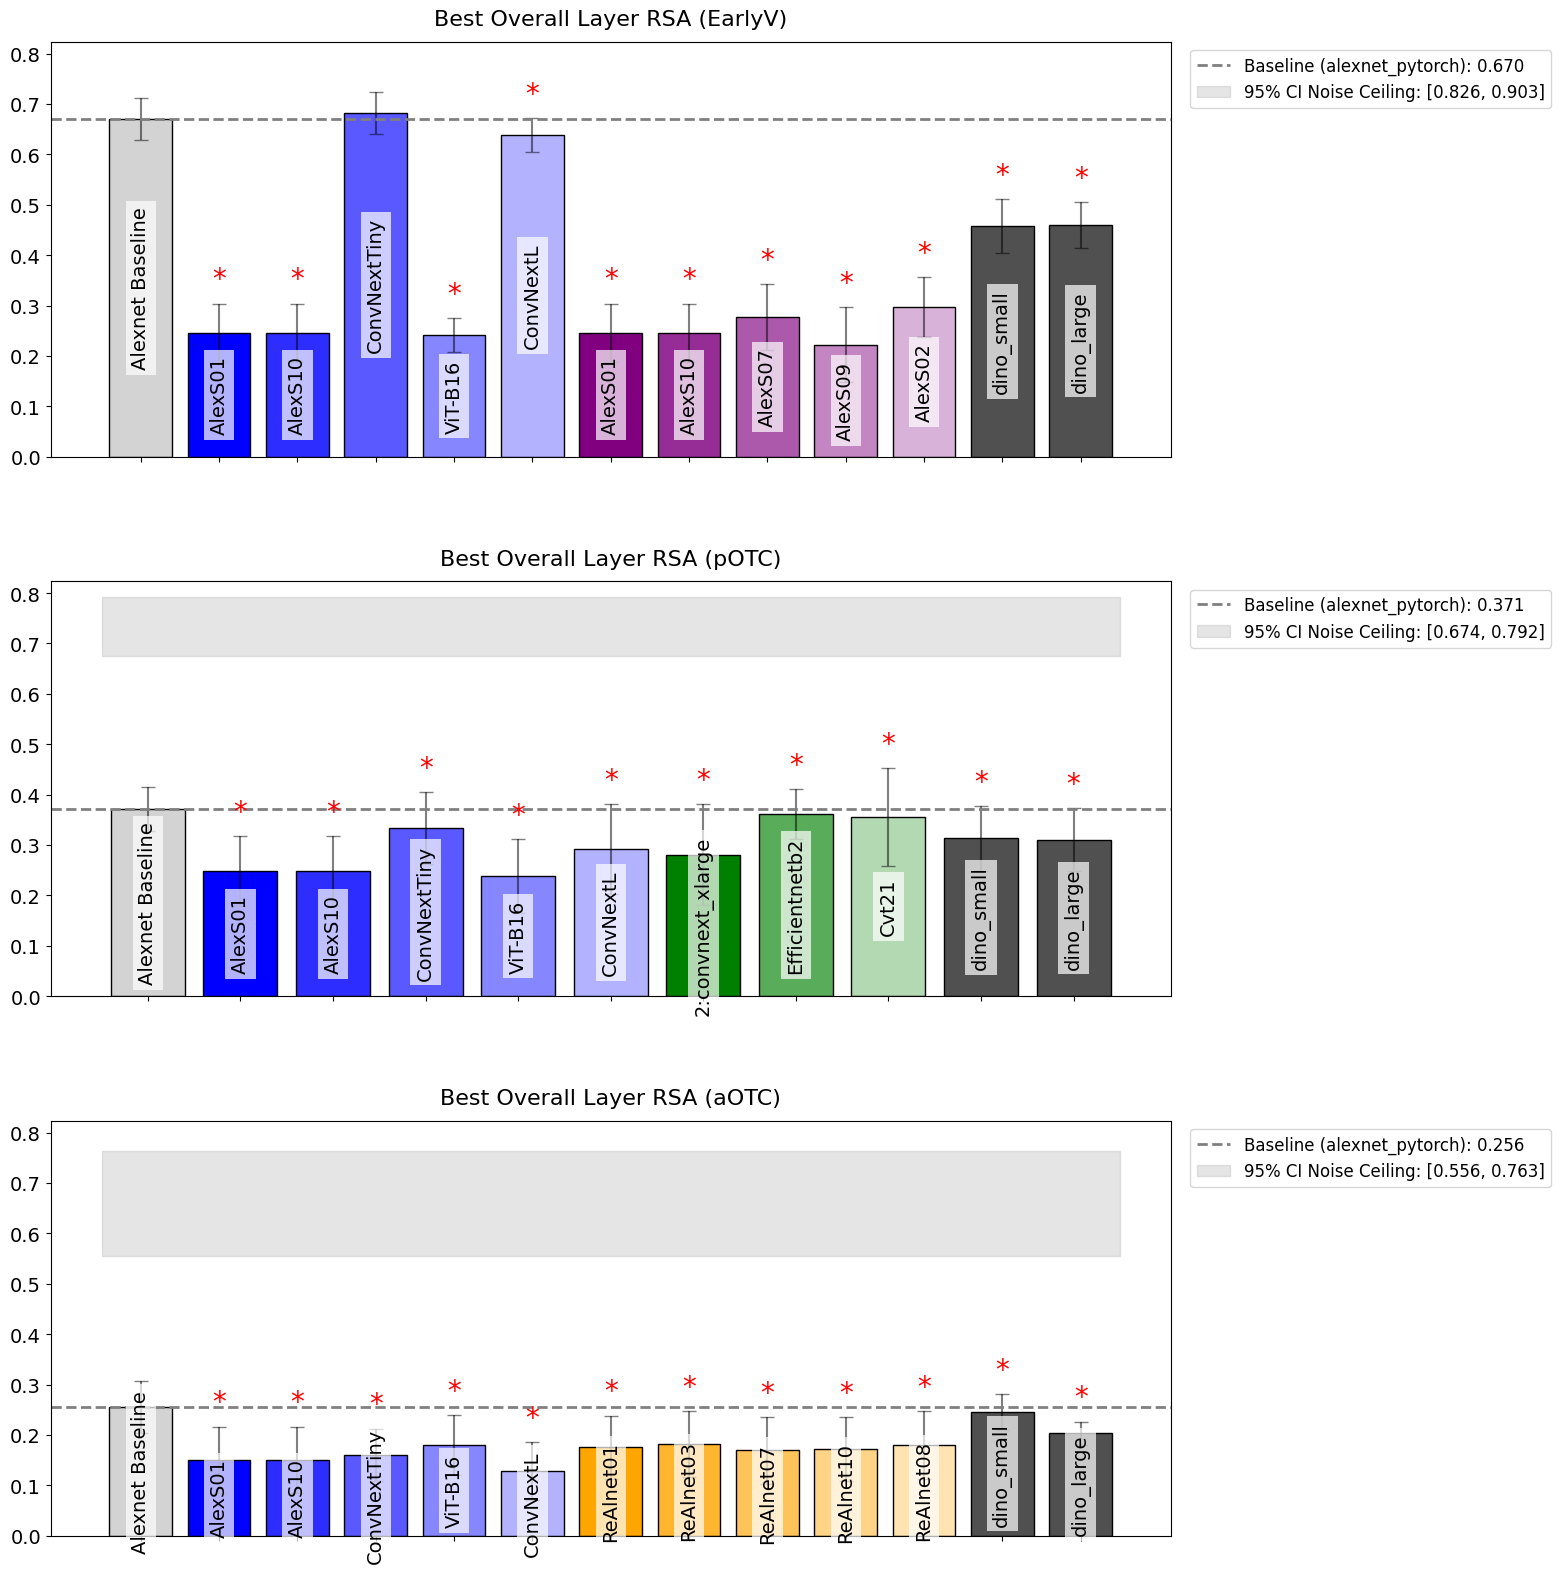

In [80]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# --------------------------------------------------------------------------------
# 1) Load Your RDMs (If Needed for Noise Ceiling)
# --------------------------------------------------------------------------------
with open('reliable_roi_rdms/EarlyV_reliable_rdms.pkl', 'rb') as file:
    EarlyV_rdms = pickle.load(file)
EarlyV_rdms_array = np.stack(EarlyV_rdms)

with open('reliable_roi_rdms/pOTC_reliable_rdms.pkl', 'rb') as file:
    pOTC_rdms = pickle.load(file)
pOTC_rdms_array = np.stack(pOTC_rdms)

with open('reliable_roi_rdms/aOTC_reliable_rdms.pkl', 'rb') as file:
    aOTC_rdms = pickle.load(file)
aOTC_rdms_array = np.stack(aOTC_rdms)

# --------------------------------------------------------------------------------
# 2) Define a Mapping from ROI Name to CSV and Load Summaries
# --------------------------------------------------------------------------------
roi_files = {
    "EarlyV": os.path.join("barplot_summaries_roi", "EarlyV_summary_with_categories.csv"),
    "pOTC":   os.path.join("barplot_summaries_roi", "pOTC_summary_with_categories.csv"),
    "aOTC":   os.path.join("barplot_summaries_roi", "aOTC_summary_with_categories.csv")
}

# If you know you'll want the *same* y-limit for all subplots (so they look comparable),
# you need to figure out the maximum bar+error across *all* CSVs ahead of time.
# We'll gather them below.
all_max = 0.0
roi_dfs = {}  # store loaded data so we don't re-read

for roi, csv_path in roi_files.items():
    df = pd.read_csv(csv_path)
    roi_dfs[roi] = df  # keep it in memory

    # Compute the max of (mean_corr + error) in this ROI
    max_for_roi = (df["group1_mean_corr"] + df["error"]).max()
    if max_for_roi > all_max:
        all_max = max_for_roi

# Slight buffer above the tallest bar
global_ymax = all_max + 0.1


# --------------------------------------------------------------------------------
# 3) Combined Short Names (Adjust as needed)
# --------------------------------------------------------------------------------
model_short_names = {
    'alexnet_pytorch': "Alexnet Baseline",
    "1: convnext_large_mlp": "ConvNextL",
    "7: vit_relpos_base_patch16": "ViT-B16",
    "15: convnext_tiny_imagenet_full": "ConvNextTiny",
    "145: alexnet_training_seed_01": "AlexS01",
    "150: alexnet_training_seed_10": "AlexS10",
    "151: alexnet_training_seed_07": "AlexS07",
    "163: alexnet_training_seed_09": "AlexS09",
    "166: alexnet_training_seed_02": "AlexS02",
    "2: convnext_xlarge": "ConvNextXL",
    "69: efficientnet_b2_imagenet_full": "Efficientnetb2",
    "39: cvt_cvt-21-384-in1k_4_LucyV4": "Cvt21",
    "128: ReAlnet01_cornet": "ReAlnet01",
    "134: ReAlnet03_cornet": "ReAlnet03",
    "123: ReAlnet07_cornet": "ReAlnet07",
    "115: ReAlnet10_cornet:laion2b_ft_in1k": "ReAlnet10",
    "118: ReAlnet08_cornet: openai_ft_in1k": "ReAlnet08",
    "aOTC_dinov2": "dino_small"
}

baseline_model = "alexnet_pytorch"

# --------------------------------------------------------------------------------
# 4) Create Figure with Stacked Subplots
# --------------------------------------------------------------------------------
rois = list(roi_files.keys())
n_rois = len(rois)

# Make the figure tall enough and share y-axis to keep the same scale:
fig, axes = plt.subplots(
    nrows=n_rois, ncols=1, 
    figsize=(14, 6 * n_rois),
    sharey=True  # ensures all subplots use the same y-limits
)

# If there's only one ROI, wrap axes in a list for consistency
if n_rois == 1:
    axes = [axes]

# Provide some extra space between subplots
fig.subplots_adjust(hspace=0.3, bottom=0.1, left=0.08, right=0.88, top=0.93)

# --------------------------------------------------------------------------------
# 5) Plot Each ROI in Its Subplot
# --------------------------------------------------------------------------------
for ax, roi in zip(axes, rois):
    df = roi_dfs[roi]  # already read

    x = np.arange(len(df))
    bar_colors = df["shaded_color"].tolist()

    # Plot bars
    ax.bar(x, df["group1_mean_corr"], color=bar_colors, edgecolor='k')
    ax.errorbar(
        x, df["group1_mean_corr"],
        yerr=df["error"],
        fmt='none', ecolor='black', alpha=0.5, capsize=5
    )

    # Horizontal baseline line (if in df)
    if baseline_model in df["model"].values:
        baseline_mean = df.loc[df["model"] == baseline_model, "group1_mean_corr"].iloc[0]
        ax.axhline(
            baseline_mean, color='grey', linestyle='--', linewidth=2,
            label=f"Baseline ({baseline_model}): {baseline_mean:.3f}"
        )

    # Add significance stars from the "significance" column (if p < 0.05)
    for i, row in df.iterrows():
        if row["model"] == baseline_model:
            continue
        p_val = row.get("significance", np.nan)
        if p_val < 0.05:
            star_y = row["group1_mean_corr"] + row["error"] + 0.02
            ax.text(x[i], star_y, "*", ha='center', va='bottom', color='red', fontsize=20)

    # Conditionally place short names (with smaller font if the bar is short)
    for i, row in df.iterrows():
        bar_height = row["group1_mean_corr"]
        short_name = model_short_names.get(row["model"], row["model"])

        # If bar is too short, place text above the bar with smaller font
        if bar_height < 0.1:
            y_pos = bar_height + 0.01
            va = 'bottom'
            txt_fontsize = 10
        else:
            y_pos = bar_height / 2
            va = 'center'
            txt_fontsize = 14

        ax.text(
            x[i], y_pos, short_name,
            ha='center', va=va,
            rotation=90, fontsize=txt_fontsize,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
        )

    # Plot noise ceiling for this ROI
    if roi == "EarlyV":
        rdms_array = EarlyV_rdms_array
    elif roi == "pOTC":
        rdms_array = pOTC_rdms_array
    elif roi == "aOTC":
        rdms_array = aOTC_rdms_array
    else:
        rdms_array = EarlyV_rdms_array  # fallback

    noise_results = compute_noise_ceiling(rdms_array, num_splits=None)
    noise_ceiling = noise_results["noise_ceiling"]
    noise_ci_lower, noise_ci_upper = noise_results["ci"]

    ax.fill_between(
        [-0.5, len(df)-0.5],
        noise_ci_lower,
        noise_ci_upper,
        color='grey', alpha=0.2,
        label=f"95% CI Noise Ceiling: [{noise_ci_lower:.3f}, {noise_ci_upper:.3f}]"
    )

    # Set uniform y-limit for all subplots
    ax.set_ylim([0, global_ymax])  # or [some_negative_value, global_ymax] if you have negative bars

    # Title and tick labels
    ax.set_title(f"Best Overall Layer RSA ({roi})", fontsize=16, pad=12)
    ax.set_xticks(x)
    ax.set_xticklabels([""] * len(x))  # hide the x-axis labels
    ax.tick_params(axis='y', labelsize=14)  # bigger y-tick font

    # Place legend outside
    ax.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1.01, 1))

# --------------------------------------------------------------------------------
# 6) Show Final Figure
# --------------------------------------------------------------------------------
plt.show()


# Reading summary of intermediates

In [3]:
filepath = 'Stats_additional_models/EarlyV_alexnet_pytorch_intermediates.csv'
read_summary_csv(filepath)

,group1_mean_corr,group2_mean_corr,t_stat,p_val,confidence_interval,best_layer_mode,total_splits_used
0,0.669796,0.660219,2.855064,0.005039,"(0.626391650966858, 0.7100205220782048)",features.3,126
